In [1]:
# Installing the requirements
print('Installing Requirements... ',end='')
%pip install lightning
%pip install wandb
print('Done')

Installing Requirements... Requirement already satisfied: lightning in /system/conda/miniconda3/envs/cloudspace/lib/python3.10/site-packages (2.2.0.post0)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Done


In [2]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
from statistics import mean, median
print('Done')

Importing Libraries... Done


In [3]:
# Loading dataset
path = Path('/teamspace/studios/this_studio/assign1')
df = pd.read_csv('/teamspace/studios/this_studio/assign1/meta/esc50.csv')

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


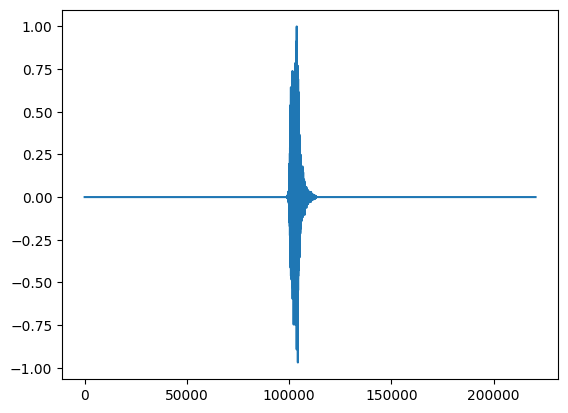

In [4]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(str(wavs[0])) # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(str(path), format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [6]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        # examples = torch.cat(examples)
        examples = torch.stack(examples)
        examples = examples.reshape(examples.size(0),1,-1)
        labels = torch.flatten(torch.tensor(labels))

        return [examples, labels]


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
import wandb

import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [9]:
class Architecture1(nn.Module):
    def __init__(self):
        super(Architecture1, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm1d after first conv layer
        self.conv2 = nn.Conv1d(16, 8, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(8)  # BatchNorm1d after second conv layer

        self.dropout1 = nn.Dropout(p=0.2)  # Dropout after maxpooling

        self.conv3 = nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(4)  # BatchNorm1d after third conv layer
        self.conv4 = nn.Conv1d(4, 2, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(2)

        # self.dropout2 = nn.Dropout(p=0.2)  # Dropout after maxpooling
    
        # self.conv5 = nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1)
        # self.bn5 = nn.BatchNorm1d(1)
        self.fc1 = nn.Linear(1124, 10)
        # self.fc2 = nn.Linear(600, 10)
        # self.fc3 = nn.Linear(2250, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 8)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 8)
        # x = self.dropout2(x)

        # x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 8)
        x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))  # Add ReLU after fc1
        # x = F.relu(self.fc2(x))  # Add ReLU after fc2
        x = F.softmax(self.fc1(x), dim=1)  # Apply softmax on final layer
        return x

In [12]:
learning_rates = [0.001, 0.01]
optimizers = ['Adam', 'SGD']

In [ ]:
# Architecture1 - Model1 

100%|██████████| 80/80 [00:00<00:00, 17278.29it/s]


2 fold, Epoch 1/100, Training Loss: 2.29629984498024, Training Accuracy: 14.583333333333334
2 fold, Epoch 1/100, Validation Loss: 2.302743673324585, Validation Accuracy: 16.25
2 fold, Epoch 2/100, Training Loss: 2.1911403834819794, Training Accuracy: 28.75
2 fold, Epoch 2/100, Validation Loss: 2.304779529571533, Validation Accuracy: 16.25
2 fold, Epoch 3/100, Training Loss: 2.1190838515758514, Training Accuracy: 35.833333333333336
2 fold, Epoch 3/100, Validation Loss: 2.3010525703430176, Validation Accuracy: 20.0
2 fold, Epoch 4/100, Training Loss: 2.087248295545578, Training Accuracy: 40.0
2 fold, Epoch 4/100, Validation Loss: 2.268430233001709, Validation Accuracy: 23.75
2 fold, Epoch 5/100, Training Loss: 2.0514113306999207, Training Accuracy: 42.5
2 fold, Epoch 5/100, Validation Loss: 2.21968666712443, Validation Accuracy: 26.25
2 fold, Epoch 6/100, Training Loss: 2.028993636369705, Training Accuracy: 44.166666666666664
2 fold, Epoch 6/100, Validation Loss: 2.1841398080190024, Vali

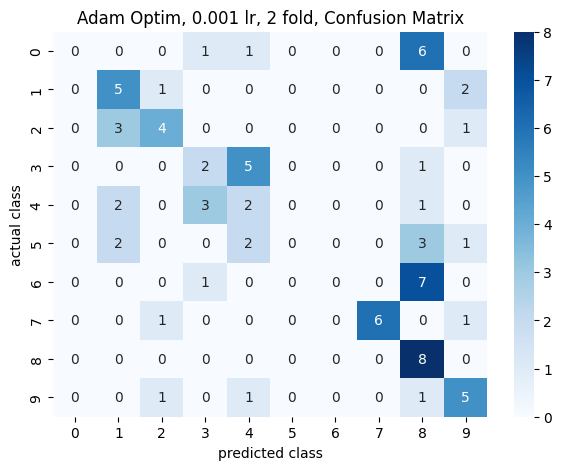

Adam Optim, 0.001 lr, 2 fold, Overall F1 Score: 0.33803675856307436


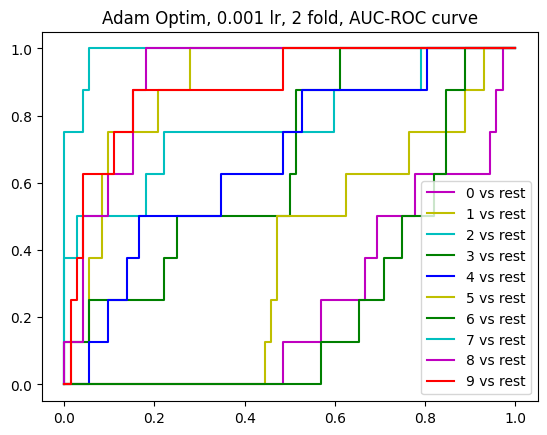

100%|██████████| 80/80 [00:00<00:00, 15711.95it/s]


3 fold, Epoch 1/100, Training Loss: 2.2834666967391968, Training Accuracy: 11.666666666666666
3 fold, Epoch 1/100, Validation Loss: 2.3023290634155273, Validation Accuracy: 11.25
3 fold, Epoch 2/100, Training Loss: 2.175191730260849, Training Accuracy: 30.833333333333332
3 fold, Epoch 2/100, Validation Loss: 2.3023855686187744, Validation Accuracy: 8.75
3 fold, Epoch 3/100, Training Loss: 2.091688722372055, Training Accuracy: 37.916666666666664
3 fold, Epoch 3/100, Validation Loss: 2.2986582120259604, Validation Accuracy: 13.75
3 fold, Epoch 4/100, Training Loss: 2.050295516848564, Training Accuracy: 45.0
3 fold, Epoch 4/100, Validation Loss: 2.278897205988566, Validation Accuracy: 25.0
3 fold, Epoch 5/100, Training Loss: 2.016924187541008, Training Accuracy: 47.916666666666664
3 fold, Epoch 5/100, Validation Loss: 2.2464728355407715, Validation Accuracy: 28.75
3 fold, Epoch 6/100, Training Loss: 1.984915867447853, Training Accuracy: 55.416666666666664
3 fold, Epoch 6/100, Validation L

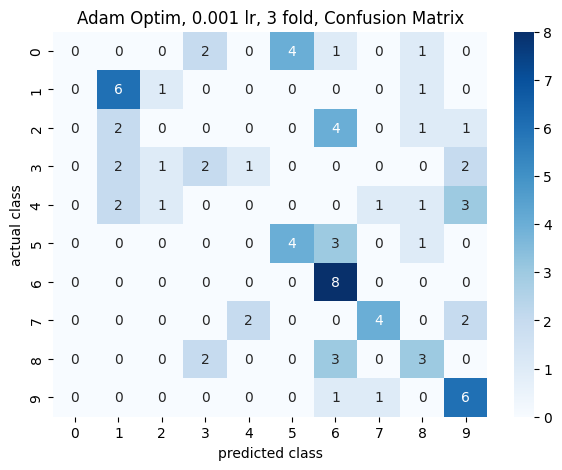

Adam Optim, 0.001 lr, 3 fold, Overall F1 Score: 0.3449025974025974


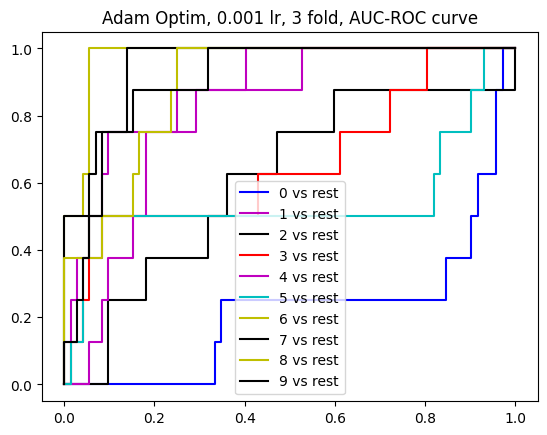

100%|██████████| 80/80 [00:00<00:00, 16145.91it/s]


4 fold, Epoch 1/100, Training Loss: 2.2780519127845764, Training Accuracy: 13.75
4 fold, Epoch 1/100, Validation Loss: 2.3026739756266275, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.2163293957710266, Training Accuracy: 22.083333333333332
4 fold, Epoch 2/100, Validation Loss: 2.3015926678975425, Validation Accuracy: 13.75
4 fold, Epoch 3/100, Training Loss: 2.1824578940868378, Training Accuracy: 25.833333333333332
4 fold, Epoch 3/100, Validation Loss: 2.297288417816162, Validation Accuracy: 23.75
4 fold, Epoch 4/100, Training Loss: 2.1332772076129913, Training Accuracy: 34.166666666666664
4 fold, Epoch 4/100, Validation Loss: 2.280534823735555, Validation Accuracy: 36.25
4 fold, Epoch 5/100, Training Loss: 2.094683200120926, Training Accuracy: 39.166666666666664
4 fold, Epoch 5/100, Validation Loss: 2.2521161238352456, Validation Accuracy: 28.75
4 fold, Epoch 6/100, Training Loss: 2.050155743956566, Training Accuracy: 45.416666666666664
4 fold, Epoch 6/100, Validati

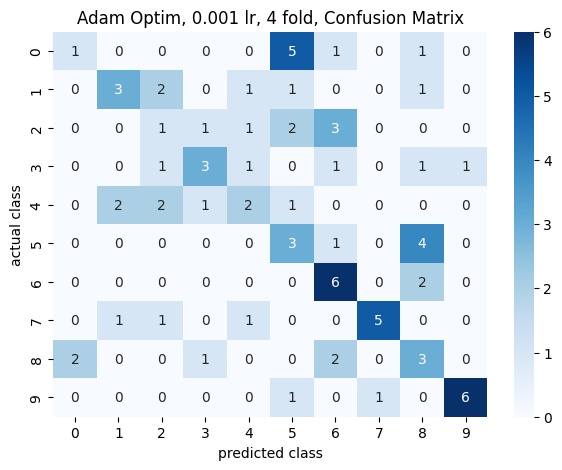

Adam Optim, 0.001 lr, 4 fold, Overall F1 Score: 0.41034632034632035


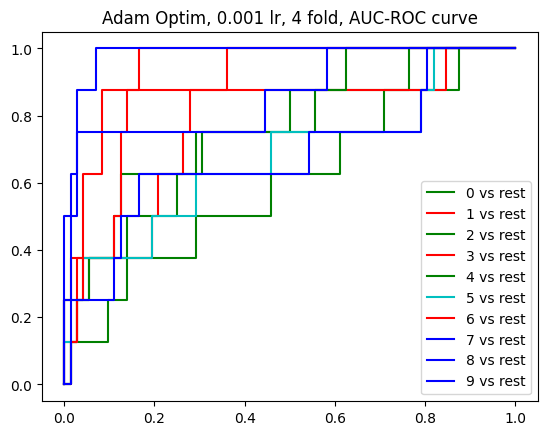

100%|██████████| 80/80 [00:00<00:00, 17020.61it/s]


5 fold, Epoch 1/100, Training Loss: 2.269289553165436, Training Accuracy: 15.0
5 fold, Epoch 1/100, Validation Loss: 2.302504062652588, Validation Accuracy: 13.75
5 fold, Epoch 2/100, Training Loss: 2.1974270939826965, Training Accuracy: 30.833333333333332
5 fold, Epoch 2/100, Validation Loss: 2.304566224416097, Validation Accuracy: 16.25
5 fold, Epoch 3/100, Training Loss: 2.131240427494049, Training Accuracy: 43.333333333333336
5 fold, Epoch 3/100, Validation Loss: 2.305692275365194, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.0871710181236267, Training Accuracy: 50.0
5 fold, Epoch 4/100, Validation Loss: 2.304786284764608, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.021790772676468, Training Accuracy: 53.333333333333336
5 fold, Epoch 5/100, Validation Loss: 2.315899133682251, Validation Accuracy: 10.0
5 fold, Epoch 6/100, Training Loss: 1.9773842096328735, Training Accuracy: 56.666666666666664
5 fold, Epoch 6/100, Validation Loss: 2.2656176090

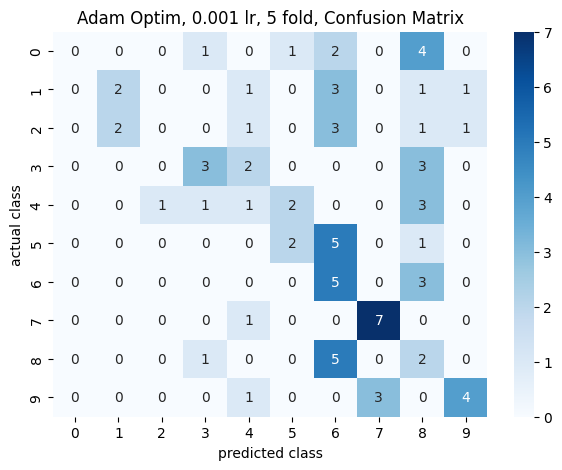

Adam Optim, 0.001 lr, 5 fold, Overall F1 Score: 0.3028563551144196


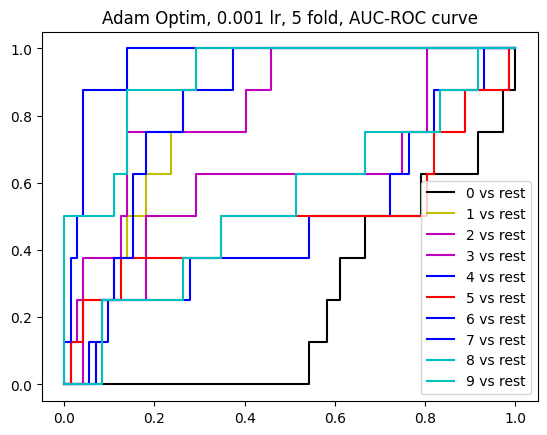

Mean validation accuracy: 35.625
Best test accuracy: 41.25


100%|██████████| 80/80 [00:00<00:00, 16955.25it/s]


2 fold, Epoch 1/100, Training Loss: 2.3019723296165466, Training Accuracy: 12.916666666666666
2 fold, Epoch 1/100, Validation Loss: 2.3022871812184653, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.2008185982704163, Training Accuracy: 24.583333333333332
2 fold, Epoch 2/100, Validation Loss: 2.306114673614502, Validation Accuracy: 13.75
2 fold, Epoch 3/100, Training Loss: 2.1665851175785065, Training Accuracy: 30.833333333333332
2 fold, Epoch 3/100, Validation Loss: 2.3056787649790444, Validation Accuracy: 13.75
2 fold, Epoch 4/100, Training Loss: 2.113373428583145, Training Accuracy: 37.083333333333336
2 fold, Epoch 4/100, Validation Loss: 2.284740765889486, Validation Accuracy: 18.75
2 fold, Epoch 5/100, Training Loss: 2.1011351943016052, Training Accuracy: 37.5
2 fold, Epoch 5/100, Validation Loss: 2.2208693822224936, Validation Accuracy: 26.25
2 fold, Epoch 6/100, Training Loss: 2.083798050880432, Training Accuracy: 37.083333333333336
2 fold, Epoch 6/100, Validatio

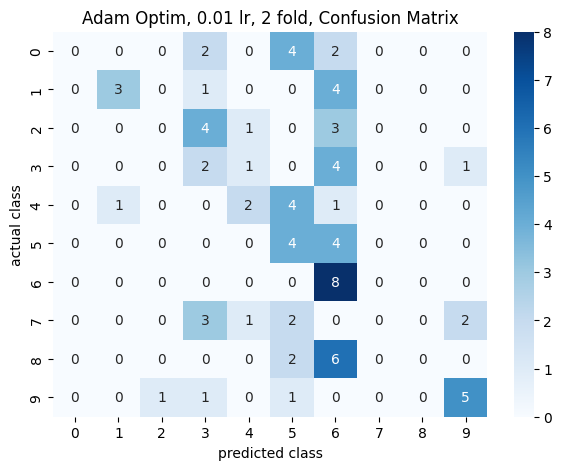

Adam Optim, 0.01 lr, 2 fold, Overall F1 Score: 0.2343168498168498


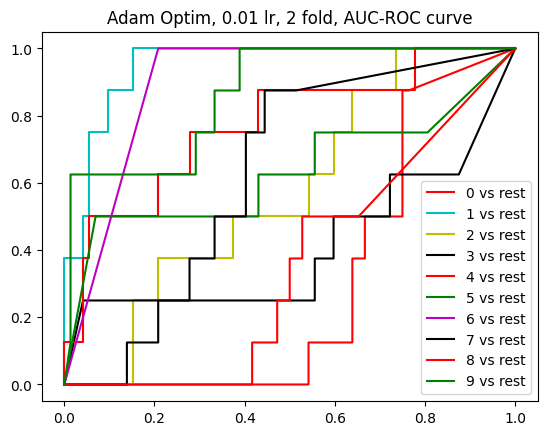

100%|██████████| 80/80 [00:00<00:00, 15985.91it/s]


3 fold, Epoch 1/100, Training Loss: 2.2445936501026154, Training Accuracy: 17.916666666666668
3 fold, Epoch 1/100, Validation Loss: 2.2879722118377686, Validation Accuracy: 13.75
3 fold, Epoch 2/100, Training Loss: 2.168385148048401, Training Accuracy: 31.25
3 fold, Epoch 2/100, Validation Loss: 2.293541113535563, Validation Accuracy: 12.5
3 fold, Epoch 3/100, Training Loss: 2.1344015896320343, Training Accuracy: 37.083333333333336
3 fold, Epoch 3/100, Validation Loss: 2.2944788138071694, Validation Accuracy: 18.75
3 fold, Epoch 4/100, Training Loss: 2.0880531817674637, Training Accuracy: 40.833333333333336
3 fold, Epoch 4/100, Validation Loss: 2.2720460891723633, Validation Accuracy: 25.0
3 fold, Epoch 5/100, Training Loss: 2.088688224554062, Training Accuracy: 40.833333333333336
3 fold, Epoch 5/100, Validation Loss: 2.2052298386891684, Validation Accuracy: 31.25
3 fold, Epoch 6/100, Training Loss: 2.086330011487007, Training Accuracy: 40.0
3 fold, Epoch 6/100, Validation Loss: 2.1848

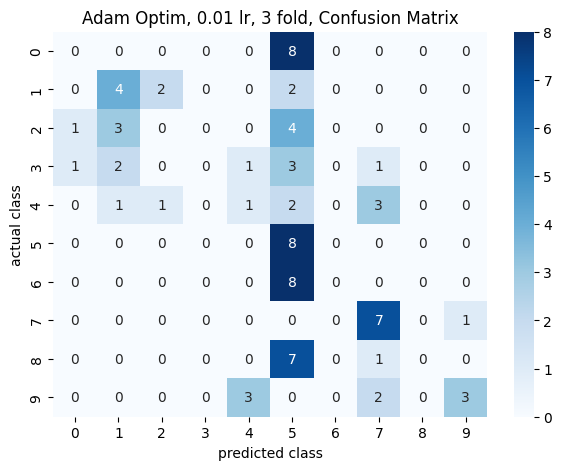

Adam Optim, 0.01 lr, 3 fold, Overall F1 Score: 0.20546542346542349


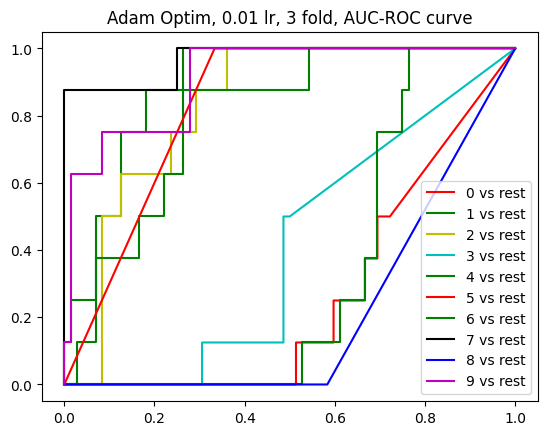

100%|██████████| 80/80 [00:00<00:00, 15464.30it/s]


4 fold, Epoch 1/100, Training Loss: 2.2745185792446136, Training Accuracy: 15.416666666666666
4 fold, Epoch 1/100, Validation Loss: 2.3000951608022056, Validation Accuracy: 16.25
4 fold, Epoch 2/100, Training Loss: 2.261321485042572, Training Accuracy: 22.083333333333332
4 fold, Epoch 2/100, Validation Loss: 2.3014238675435386, Validation Accuracy: 11.25
4 fold, Epoch 3/100, Training Loss: 2.2442212998867035, Training Accuracy: 32.083333333333336
4 fold, Epoch 3/100, Validation Loss: 2.28322704633077, Validation Accuracy: 21.25
4 fold, Epoch 4/100, Training Loss: 2.222248077392578, Training Accuracy: 32.083333333333336
4 fold, Epoch 4/100, Validation Loss: 2.2665712038675943, Validation Accuracy: 20.0
4 fold, Epoch 5/100, Training Loss: 2.1563837230205536, Training Accuracy: 35.0
4 fold, Epoch 5/100, Validation Loss: 2.209152857462565, Validation Accuracy: 30.0
4 fold, Epoch 6/100, Training Loss: 2.1360813677310944, Training Accuracy: 37.5
4 fold, Epoch 6/100, Validation Loss: 2.188961

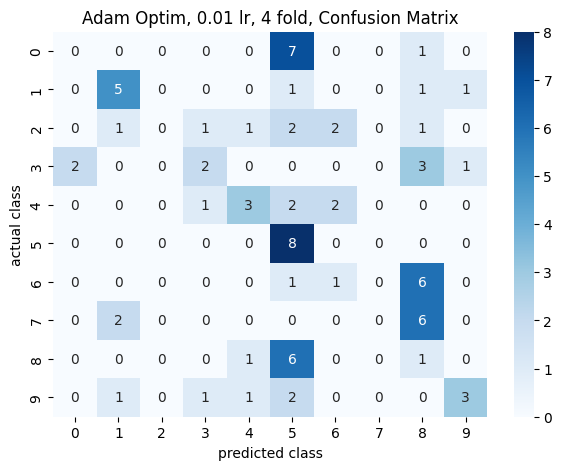

Adam Optim, 0.01 lr, 4 fold, Overall F1 Score: 0.24463901522725054


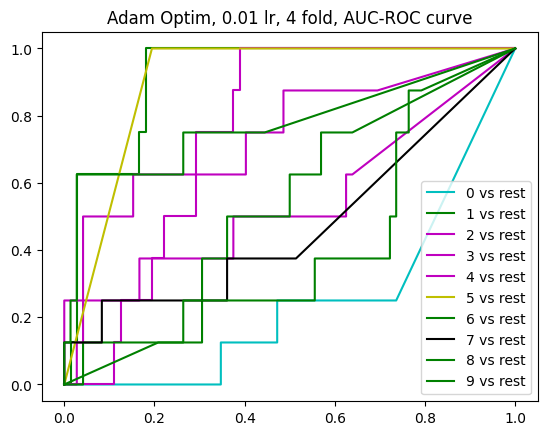

100%|██████████| 80/80 [00:00<00:00, 15407.49it/s]


5 fold, Epoch 1/100, Training Loss: 2.2929967641830444, Training Accuracy: 12.916666666666666
5 fold, Epoch 1/100, Validation Loss: 2.304748058319092, Validation Accuracy: 6.25
5 fold, Epoch 2/100, Training Loss: 2.2348334789276123, Training Accuracy: 26.25
5 fold, Epoch 2/100, Validation Loss: 2.3039414087931314, Validation Accuracy: 13.75
5 fold, Epoch 3/100, Training Loss: 2.187970817089081, Training Accuracy: 33.333333333333336
5 fold, Epoch 3/100, Validation Loss: 2.3009859720865884, Validation Accuracy: 12.5
5 fold, Epoch 4/100, Training Loss: 2.1600725650787354, Training Accuracy: 32.5
5 fold, Epoch 4/100, Validation Loss: 2.2914443810780845, Validation Accuracy: 12.5
5 fold, Epoch 5/100, Training Loss: 2.1518408060073853, Training Accuracy: 35.833333333333336
5 fold, Epoch 5/100, Validation Loss: 2.2767836252848306, Validation Accuracy: 20.0
5 fold, Epoch 6/100, Training Loss: 2.101045548915863, Training Accuracy: 41.25
5 fold, Epoch 6/100, Validation Loss: 2.248095909754435, V

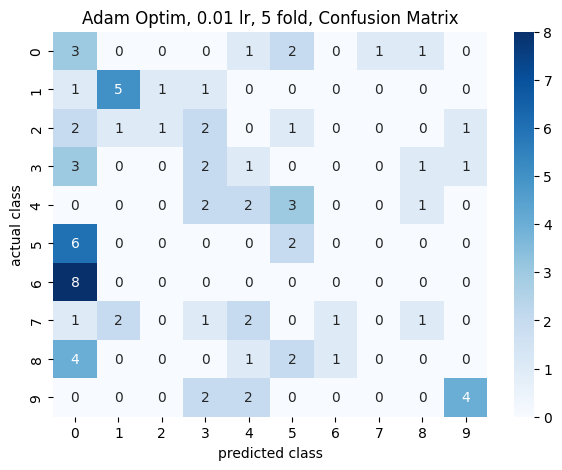

Adam Optim, 0.01 lr, 5 fold, Overall F1 Score: 0.22428338001867418


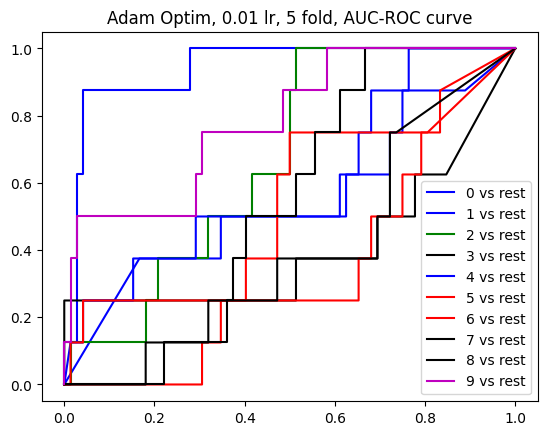

Mean validation accuracy: 29.6875
Best test accuracy: 30.0


100%|██████████| 80/80 [00:00<00:00, 16270.39it/s]


2 fold, Epoch 1/100, Training Loss: 2.296877771615982, Training Accuracy: 11.666666666666666
2 fold, Epoch 1/100, Validation Loss: 2.3027846813201904, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.299387902021408, Training Accuracy: 10.416666666666666
2 fold, Epoch 2/100, Validation Loss: 2.303269863128662, Validation Accuracy: 13.75
2 fold, Epoch 3/100, Training Loss: 2.301890790462494, Training Accuracy: 12.5
2 fold, Epoch 3/100, Validation Loss: 2.3041866620381675, Validation Accuracy: 15.0
2 fold, Epoch 4/100, Training Loss: 2.2965133488178253, Training Accuracy: 12.083333333333334
2 fold, Epoch 4/100, Validation Loss: 2.30448055267334, Validation Accuracy: 15.0
2 fold, Epoch 5/100, Training Loss: 2.289111316204071, Training Accuracy: 14.583333333333334
2 fold, Epoch 5/100, Validation Loss: 2.3034745852152505, Validation Accuracy: 12.5
2 fold, Epoch 6/100, Training Loss: 2.2972911298274994, Training Accuracy: 10.833333333333334
2 fold, Epoch 6/100, Validation Loss

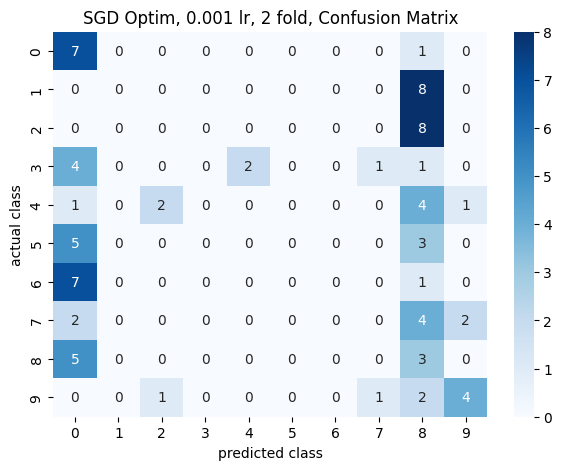

SGD Optim, 0.001 lr, 2 fold, Overall F1 Score: 0.10318425760286225


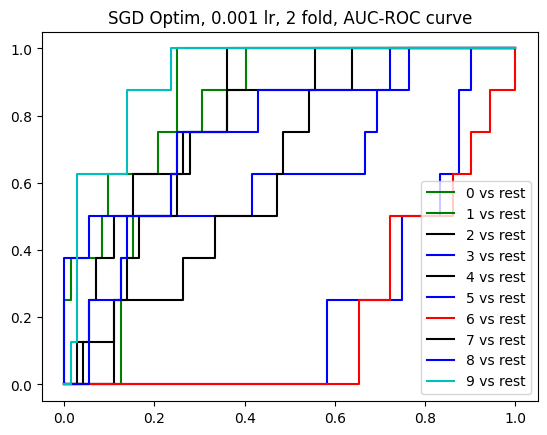

100%|██████████| 80/80 [00:00<00:00, 17208.28it/s]


3 fold, Epoch 1/100, Training Loss: 2.302373856306076, Training Accuracy: 10.416666666666666
3 fold, Epoch 1/100, Validation Loss: 2.3024166425069175, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.2909780740737915, Training Accuracy: 15.0
3 fold, Epoch 2/100, Validation Loss: 2.302510976791382, Validation Accuracy: 11.25
3 fold, Epoch 3/100, Training Loss: 2.2874315977096558, Training Accuracy: 16.25
3 fold, Epoch 3/100, Validation Loss: 2.302990436553955, Validation Accuracy: 12.5
3 fold, Epoch 4/100, Training Loss: 2.2793003916740417, Training Accuracy: 16.25
3 fold, Epoch 4/100, Validation Loss: 2.303401311238607, Validation Accuracy: 15.0
3 fold, Epoch 5/100, Training Loss: 2.270246386528015, Training Accuracy: 15.416666666666666
3 fold, Epoch 5/100, Validation Loss: 2.301196336746216, Validation Accuracy: 18.75
3 fold, Epoch 6/100, Training Loss: 2.269464433193207, Training Accuracy: 15.833333333333334
3 fold, Epoch 6/100, Validation Loss: 2.2954814434051514, Val

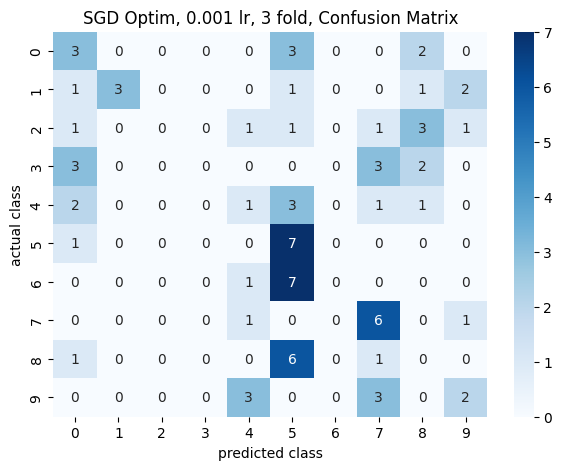

SGD Optim, 0.001 lr, 3 fold, Overall F1 Score: 0.2175130183825836


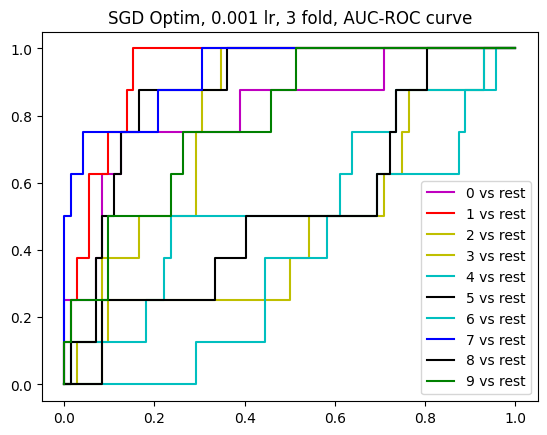

100%|██████████| 80/80 [00:00<00:00, 17033.57it/s]


4 fold, Epoch 1/100, Training Loss: 2.280728667974472, Training Accuracy: 14.583333333333334
4 fold, Epoch 1/100, Validation Loss: 2.3027168909708657, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.267786592245102, Training Accuracy: 16.25
4 fold, Epoch 2/100, Validation Loss: 2.3026734987894693, Validation Accuracy: 12.5
4 fold, Epoch 3/100, Training Loss: 2.2683519423007965, Training Accuracy: 17.5
4 fold, Epoch 3/100, Validation Loss: 2.302680810292562, Validation Accuracy: 16.25
4 fold, Epoch 4/100, Training Loss: 2.2621095180511475, Training Accuracy: 15.416666666666666
4 fold, Epoch 4/100, Validation Loss: 2.3025049368540444, Validation Accuracy: 10.0
4 fold, Epoch 5/100, Training Loss: 2.2672232389450073, Training Accuracy: 16.25
4 fold, Epoch 5/100, Validation Loss: 2.300955375035604, Validation Accuracy: 10.0
4 fold, Epoch 6/100, Training Loss: 2.2616313695907593, Training Accuracy: 17.916666666666668
4 fold, Epoch 6/100, Validation Loss: 2.2978343963623047, V

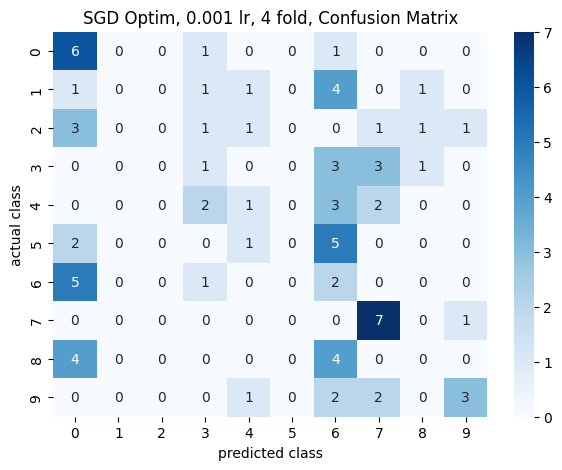

SGD Optim, 0.001 lr, 4 fold, Overall F1 Score: 0.18962067043401373


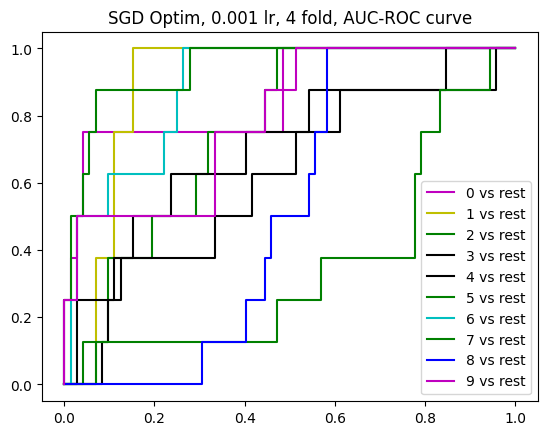

100%|██████████| 80/80 [00:00<00:00, 16852.21it/s]


5 fold, Epoch 1/100, Training Loss: 2.304159462451935, Training Accuracy: 6.25
5 fold, Epoch 1/100, Validation Loss: 2.302706718444824, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.2979332208633423, Training Accuracy: 6.25
5 fold, Epoch 2/100, Validation Loss: 2.3023694356282554, Validation Accuracy: 17.5
5 fold, Epoch 3/100, Training Loss: 2.2956014275550842, Training Accuracy: 10.0
5 fold, Epoch 3/100, Validation Loss: 2.301513115564982, Validation Accuracy: 22.5
5 fold, Epoch 4/100, Training Loss: 2.2984879314899445, Training Accuracy: 8.333333333333334
5 fold, Epoch 4/100, Validation Loss: 2.3004687627156577, Validation Accuracy: 21.25
5 fold, Epoch 5/100, Training Loss: 2.2906655073165894, Training Accuracy: 8.75
5 fold, Epoch 5/100, Validation Loss: 2.2982611656188965, Validation Accuracy: 25.0
5 fold, Epoch 6/100, Training Loss: 2.288410097360611, Training Accuracy: 8.333333333333334
5 fold, Epoch 6/100, Validation Loss: 2.2945619424184165, Validation Accuracy

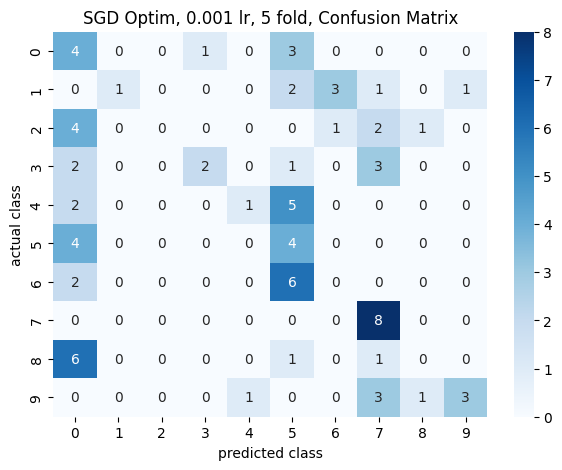

SGD Optim, 0.001 lr, 5 fold, Overall F1 Score: 0.2417909867909868


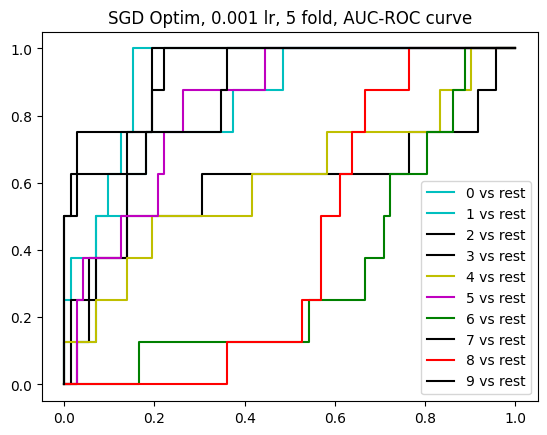

Mean validation accuracy: 26.25
Best test accuracy: 28.75


100%|██████████| 80/80 [00:00<00:00, 14292.47it/s]


2 fold, Epoch 1/100, Training Loss: 2.285892963409424, Training Accuracy: 11.666666666666666
2 fold, Epoch 1/100, Validation Loss: 2.3022069931030273, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.2581742703914642, Training Accuracy: 12.916666666666666
2 fold, Epoch 2/100, Validation Loss: 2.301397720972697, Validation Accuracy: 16.25
2 fold, Epoch 3/100, Training Loss: 2.2697441279888153, Training Accuracy: 16.666666666666668
2 fold, Epoch 3/100, Validation Loss: 2.298802296320597, Validation Accuracy: 13.75
2 fold, Epoch 4/100, Training Loss: 2.24586883187294, Training Accuracy: 19.583333333333332
2 fold, Epoch 4/100, Validation Loss: 2.2922932306925454, Validation Accuracy: 21.25
2 fold, Epoch 5/100, Training Loss: 2.2365479469299316, Training Accuracy: 22.916666666666668
2 fold, Epoch 5/100, Validation Loss: 2.277808427810669, Validation Accuracy: 17.5
2 fold, Epoch 6/100, Training Loss: 2.225427955389023, Training Accuracy: 24.583333333333332
2 fold, Epoch 6/100,

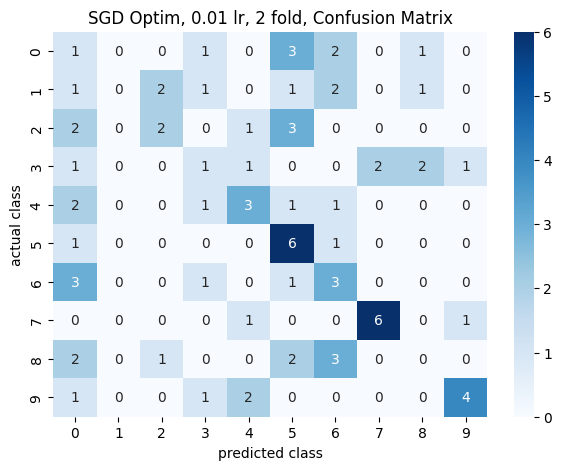

SGD Optim, 0.01 lr, 2 fold, Overall F1 Score: 0.3017887112887113


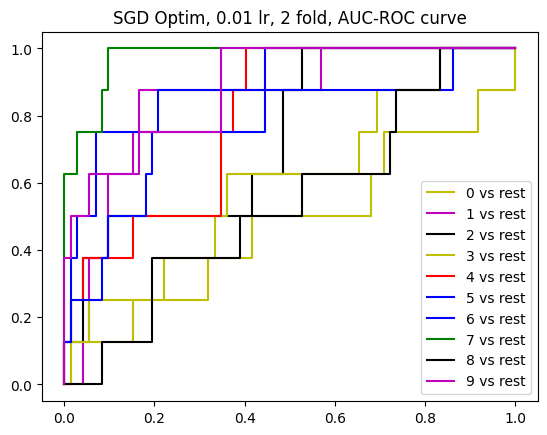

100%|██████████| 80/80 [00:00<00:00, 16008.79it/s]


3 fold, Epoch 1/100, Training Loss: 2.2966634035110474, Training Accuracy: 14.583333333333334
3 fold, Epoch 1/100, Validation Loss: 2.3026331265767417, Validation Accuracy: 11.25
3 fold, Epoch 2/100, Training Loss: 2.284319579601288, Training Accuracy: 17.5
3 fold, Epoch 2/100, Validation Loss: 2.3026047547658286, Validation Accuracy: 10.0
3 fold, Epoch 3/100, Training Loss: 2.271112382411957, Training Accuracy: 18.75
3 fold, Epoch 3/100, Validation Loss: 2.3018129666646323, Validation Accuracy: 12.5
3 fold, Epoch 4/100, Training Loss: 2.234781801700592, Training Accuracy: 23.333333333333332
3 fold, Epoch 4/100, Validation Loss: 2.298237164815267, Validation Accuracy: 22.5
3 fold, Epoch 5/100, Training Loss: 2.210065007209778, Training Accuracy: 24.166666666666668
3 fold, Epoch 5/100, Validation Loss: 2.2876882553100586, Validation Accuracy: 26.25
3 fold, Epoch 6/100, Training Loss: 2.199090987443924, Training Accuracy: 27.916666666666668
3 fold, Epoch 6/100, Validation Loss: 2.2668943

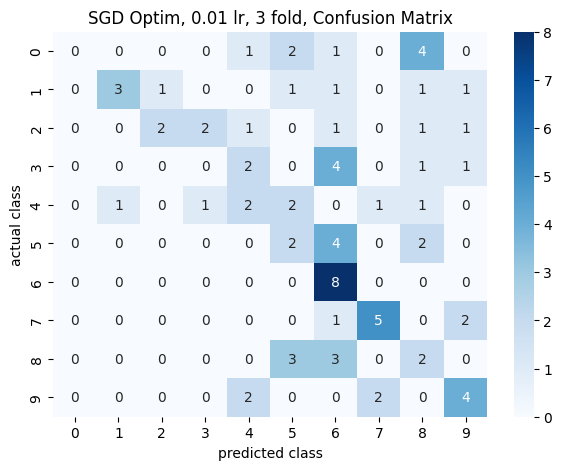

SGD Optim, 0.01 lr, 3 fold, Overall F1 Score: 0.31475758534107684


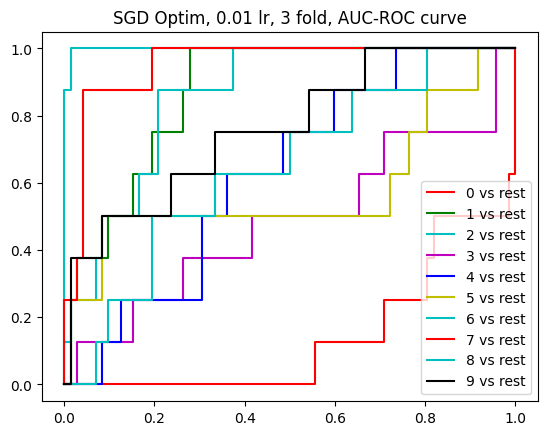

100%|██████████| 80/80 [00:00<00:00, 16440.19it/s]


4 fold, Epoch 1/100, Training Loss: 2.300457239151001, Training Accuracy: 10.0
4 fold, Epoch 1/100, Validation Loss: 2.3025246461232505, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.2751301527023315, Training Accuracy: 14.166666666666666
4 fold, Epoch 2/100, Validation Loss: 2.3018078804016113, Validation Accuracy: 11.25
4 fold, Epoch 3/100, Training Loss: 2.2642149329185486, Training Accuracy: 15.0
4 fold, Epoch 3/100, Validation Loss: 2.2997752825419107, Validation Accuracy: 11.25
4 fold, Epoch 4/100, Training Loss: 2.2607708275318146, Training Accuracy: 16.25
4 fold, Epoch 4/100, Validation Loss: 2.2953967253367105, Validation Accuracy: 12.5
4 fold, Epoch 5/100, Training Loss: 2.2457288205623627, Training Accuracy: 17.5
4 fold, Epoch 5/100, Validation Loss: 2.2898624738057456, Validation Accuracy: 20.0
4 fold, Epoch 6/100, Training Loss: 2.242953836917877, Training Accuracy: 21.666666666666668
4 fold, Epoch 6/100, Validation Loss: 2.2854129473368325, Validation Ac

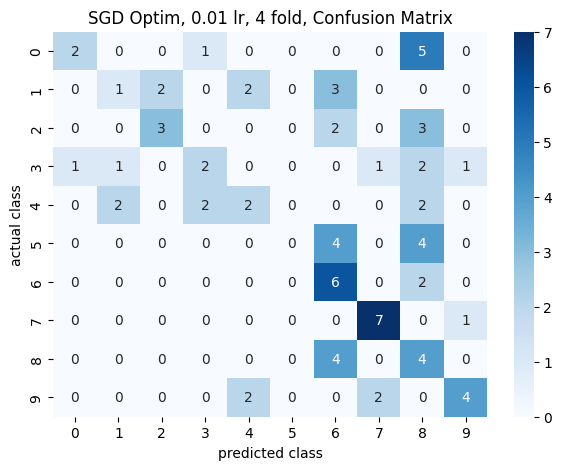

SGD Optim, 0.01 lr, 4 fold, Overall F1 Score: 0.36455655455655456


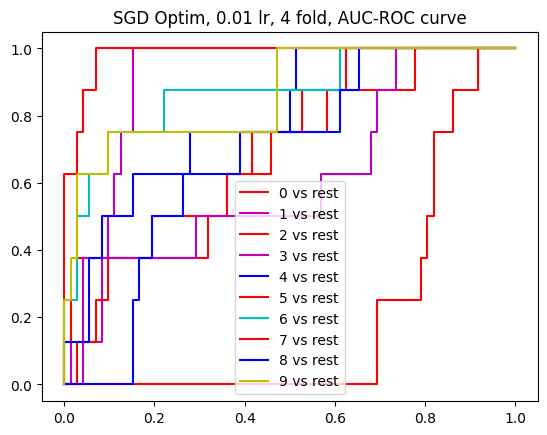

100%|██████████| 80/80 [00:00<00:00, 15890.52it/s]


5 fold, Epoch 1/100, Training Loss: 2.2843251824378967, Training Accuracy: 14.583333333333334
5 fold, Epoch 1/100, Validation Loss: 2.302980979283651, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.2718057930469513, Training Accuracy: 15.833333333333334
5 fold, Epoch 2/100, Validation Loss: 2.3028790950775146, Validation Accuracy: 11.25
5 fold, Epoch 3/100, Training Loss: 2.2593078911304474, Training Accuracy: 16.25
5 fold, Epoch 3/100, Validation Loss: 2.302797873814901, Validation Accuracy: 5.0
5 fold, Epoch 4/100, Training Loss: 2.257665365934372, Training Accuracy: 17.916666666666668
5 fold, Epoch 4/100, Validation Loss: 2.2992239793141684, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.248167932033539, Training Accuracy: 19.166666666666668
5 fold, Epoch 5/100, Validation Loss: 2.2908933957417807, Validation Accuracy: 16.25
5 fold, Epoch 6/100, Training Loss: 2.2346531748771667, Training Accuracy: 20.0
5 fold, Epoch 6/100, Validation Loss: 2.269457

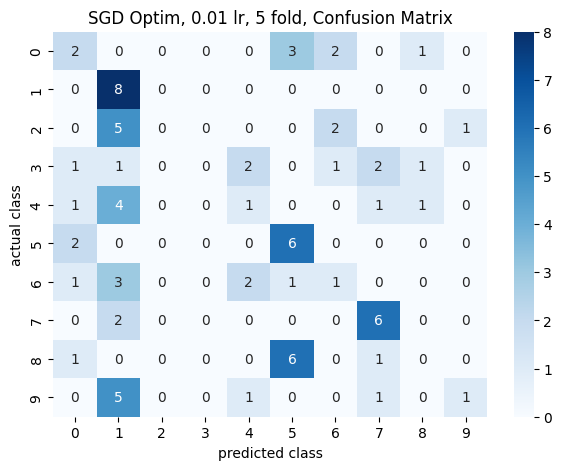

SGD Optim, 0.01 lr, 5 fold, Overall F1 Score: 0.23117376775271517


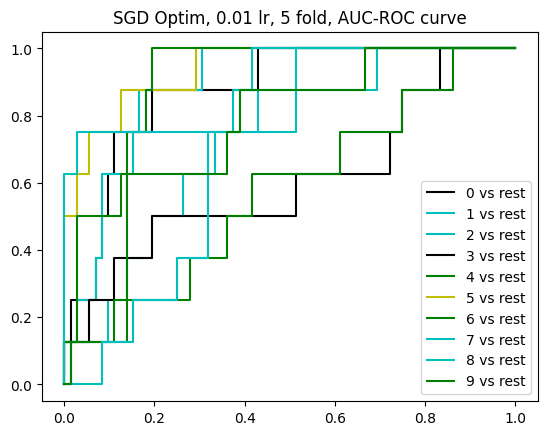

Mean validation accuracy: 36.5625
Best test accuracy: 38.75


In [13]:
for optimizer_type in optimizers:
    for lr_type in learning_rates:

        all_test_accuracy = []
        all_validation_accuracy = []
        valid_samples = [2,3,4,5]
        
        for i in valid_samples:
            # Data Setup
            test_samp = 1 #Do not change this!!
            valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = 32 # Free to change
            num_workers = 2 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                num_workers=num_workers,
                                                data_directory=path,
                                                data_frame=df,
                                                validation_fold=valid_samp,
                                                testing_fold=test_samp,  # set to 0 for no test set
                                                esc_10_flag=True,
                                                file_column='filename',
                                                label_column='category',
                                                sampling_rate=44100,
                                                new_sampling_rate=16000,  # new sample rate for input
                                                sample_length_seconds=1  # new length of input in seconds
                                                )

            custom_data_module.setup()
            
            # Hyperparameters
            num_classes = 10
            lr = lr_type
            epochs = 100
            # Model, Optimizer, Loss function
            model1 = Architecture1().to(device)
            # model2 = Architecture2()
            # optimizer = optim.Adam(model1.parameters(), lr=lr)  
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model1.parameters(), lr=lr)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model1.parameters(), lr=lr)

            criterion = nn.CrossEntropyLoss()

            # WandB initialization
            wandb.init(project="Architecture1_Model1", name=f"{optimizer_type} Optim, {lr} lr, {i} fold")

            # Training loop
            train_acc_track = []
            val_acc_track = []
            train_loss_track = []
            val_loss_track = []

            for epoch in range(epochs):
                model1.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for data, target in custom_data_module.train_dataloader():
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model1(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = output.max(1)

                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()

                train_loss = running_loss / len(custom_data_module.train_dataloader())
                train_acc = 100. * correct / total

                train_loss_track.append(train_loss)
                train_acc_track.append(train_acc)

                print(f'{i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

                # Validation
                model1.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for data, target in custom_data_module.val_dataloader():
                        data, target = data.to(device), target.to(device)
                        output = model1(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()
                        _, predicted = output.max(1)

                        val_total += target.size(0)
                        val_correct += predicted.eq(target).sum().item()

                val_loss /= len(custom_data_module.val_dataloader())
                val_acc = 100. * val_correct / val_total

                val_loss_track.append(val_loss)
                val_acc_track.append(val_acc)

                print(f'{i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

                # # Logging
                wandb.log({"Train Loss": train_loss, "Train Acc": train_acc, "Val Loss": val_loss, "Val Acc": val_acc, "Learning rate": lr, "Optimizer": optimizer_type})


            all_validation_accuracy.append(val_acc)

            # Testing
            model1.eval()
            test_correct = 0
            test_total = 0
            all_labels_test = []
            all_preds_test = []
            all_probabilities = []

            with torch.no_grad():
                for data, target in custom_data_module.test_dataloader():
                    data, target = data.to(device), target.to(device)          
                    output = model1(data)
                    all_probabilities.extend(output.cpu().numpy())
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
                    all_labels_test.extend(target.cpu().numpy())
                    all_preds_test.extend(predicted.cpu().numpy())

            test_acc = 100. * test_correct / test_total
            print(f'{optimizer_type} Optim, {lr} lr, {i} fold, Test Accuracy: {test_acc:.2f}%')
            # print(f'Test Accuracy: {test_acc:.2f}%')
            all_test_accuracy.append(test_acc)

            # Confusion Matrix for test set
            cm = confusion_matrix(all_labels_test, all_preds_test)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, Confusion Matrix')
            # plt.title(f'Confusion Matrix')
            plt.xlabel("predicted class",size=10)
            plt.ylabel("actual class",size=10)
            plt.show()

            # Calculate overall F1 score
            overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

            # print(f'Overall F1 Score: {overall_f1_score}')
            print(f'{optimizer_type} Optim, {lr} lr, {i} fold, Overall F1 Score: {overall_f1_score}')

            # roc curve for classes
            fpr = {}
            tpr = {}
            thresh ={}
            n_class = 10

            for j in range(n_class):
                fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
                plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
            plt.legend()    
            # plt.title("AUC-ROC curve")
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, AUC-ROC curve')
            plt.show()  

            wandb.summary["Test accuracy"] = test_acc
            wandb.finish()

        print(f'Mean validation accuracy: {mean(all_validation_accuracy)}')
        print(f'Best test accuracy: {max(all_test_accuracy)}')

In [27]:
def numel(model1: torch.nn.Module, only_trainable: bool = False):

    parameters = list(model1.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)
               
numel(model1,only_trainable=True),numel(model1,only_trainable=False)-numel(model1,only_trainable=True)

(12212, 0)

In [9]:
class multi_head_self_attention(nn.Module):
    def __init__(self, embed_dim, n_heads, attn_mask=None):
        super(multi_head_self_attention,self).__init__()
        # print(embed_dim,n_heads)
        # print(embed_dim,n_heads.shape)
        assert embed_dim % n_heads == 0  # Ensure divisibility

        self.head_dim = embed_dim // n_heads  # Key/query dimension per head
        self.n_heads = n_heads
        self.embed_dim = embed_dim

        # Linear projections for queries, keys, and values
        self.linear_q = nn.Linear(self.embed_dim, self.embed_dim * self.n_heads)
        self.linear_k = nn.Linear(self.embed_dim, self.embed_dim * self.n_heads)
        self.linear_v = nn.Linear(self.embed_dim, self.embed_dim * self.n_heads)

        self.unifyheads = nn.Linear(self.n_heads * self.embed_dim, self.embed_dim)

    def forward(self, x):
        # print(x.shape)
        batches, N, d = x.size()
        h = self.n_heads

        k = self.linear_k(x).view(batches ,N, h, d)
        q = self.linear_q(x).view(batches ,N, h, d)
        v = self.linear_v(x).view(batches ,N, h, d)

        k = k.transpose(1, 2).contiguous().view(batches * h, N, d)
        q = q.transpose(1, 2).contiguous().view(batches * h, N, d)
        v = v.transpose(1, 2).contiguous().view(batches * h, N, d)

        # Scaled dot-product attention
        scores = torch.bmm(q, k.transpose(-2, -1)) / np.sqrt(d)

        # if attn_mask is not None:
        #     scores = scores.masked_fill(attn_mask == 0, -1e9)

        attn = F.softmax(scores, dim=-1)
        output = torch.bmm(attn, v).view(batches, h, N, d)

        # Combine heads and return output
        output = output.transpose(1, 2).contiguous().view(batches, N, h * d)
        return self.unifyheads(output)
        # return output.view(x.size(0), self.head_dim * self.n_heads)

In [10]:
class Architecture2(nn.Module):
    def __init__(self):
        super(Architecture2, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm1d after first conv layer
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)  # BatchNorm1d after second conv layer
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)  # BatchNorm1d after third conv layer
        self.conv4 = nn.Conv1d(64, 48, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(48)
        self.ad1 = nn.AdaptiveAvgPool2d((47, 48))
        # self.conv5 = nn.Conv1d(48, 16, kernel_size=3, stride=1, padding=1)
        # self.bn5 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(48, 48)
        self.fc2 = nn.Linear(48, 48)
        self.fc3= nn.Linear(48, 10)
        # self.fc3 = nn.Linear(2250, 10)

        self.multi_head_self_attention = multi_head_self_attention(48, 4)
        self.multi_head_self_attention2 = multi_head_self_attention(48, 4)
        self.attention_blocks = [(self.multi_head_self_attention, self.fc1),(self.multi_head_self_attention2, self.fc2) ]

    def forward(self, x):
        # x=x.float()
        x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 12)
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 8)
        x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 4)
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 2)
        x = self.ad1(x)
        # x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 16)
        # x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))  # Add ReLU after fc1
        # x = F.relu(self.fc2(x))  # Add ReLU after fc2
        # x = F.softmax(self.fc2(x), dim=1)  # Apply softmax on final layer
        
        # print(x.shape)
        self.cls_token = nn.Parameter(torch.zeros(1, 48).to(device))
        x = torch.cat((self.cls_token.expand(x.size(0), 1, -1), x), dim=1)
        x = x.to(device)
        # x = torch.cat((cls_token,x), dim=1)
        # print(x.shape)

        #Multi-head self attention
        for blocks in self.attention_blocks:

            #Positional encoding
            x = x + torch.tensor(self.getPositionEncoding(48, 48),dtype = x.dtype).to(device)
            
            multihead = blocks[0] 
            fc = blocks[1]

            y = multihead(x)
            x = x + y

            #layer norm
            x = self.layer_normalization(x)

            #mlp
            y = fc(x)#self.mlp_layer(x)
            x = x + y

            #layer norm
            x = self.layer_normalization(x)

        #final mlp layer for classification
        x = torch.flatten(x[:,0],1)
        # x = self.fc2(x)#self.mlp_layer_final(x)
        x = F.softmax(self.fc3(x), dim=1)  # Apply softmax on final layer

        # print(x.shape)
        return x

    def getPositionEncoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(0,seq_len-1):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k+1, 2*i] = np.sin(k/denominator)
                P[k+1, 2*i+1] = np.cos(k/denominator)
        return P

    def layer_normalization(self, x, eps=1e-6):
        mean = torch.mean(x, dim=-1, keepdim=True)
        std = torch.std(x, dim=-1, keepdim=True) + eps
        return (x - mean) / std

    # def mlp_layer(self, X):
    #     D = X.size(1)  # Infer input dimension
    #     W = torch.randn(D, D)  # Random weight initialization
    #     b = torch.randn(D)  # Random bias initialization

    #     output = torch.matmul(X, W) + b  # Linear transformation with bias
    #     output = torch.nn.functional.relu(output)  # Apply ReLU activation
    #     return output

    # def mlp_layer_final(self, X):
    #     D = X.size(1)  # Infer input dimension
    #     W = torch.randn(D, 10)  # Random weight initialization
    #     b = torch.randn(10)  # Random bias initialization
    #     output = torch.matmul(X, W) + b  # Linear transformation with bias
    #     output = torch.nn.functional.relu(output)  # Apply ReLU activation       
    #     return output


In [11]:
learning_rates = [0.001, 0.01]
optimizers = ['Adam', 'SGD']

In [12]:
#Architecture2 - Model - Head=1

100%|██████████| 80/80 [00:00<00:00, 16238.11it/s]
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m23csa014. Use `wandb login --relogin` to force relogin


2 fold, Epoch 1/100, Training Loss: 2.29755237698555, Training Accuracy: 12.083333333333334
2 fold, Epoch 1/100, Validation Loss: 2.3100357055664062, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.2422715723514557, Training Accuracy: 25.0
2 fold, Epoch 2/100, Validation Loss: 2.3346379597981772, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.199010670185089, Training Accuracy: 27.083333333333332
2 fold, Epoch 3/100, Validation Loss: 2.3407572905222573, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.174321413040161, Training Accuracy: 27.083333333333332
2 fold, Epoch 4/100, Validation Loss: 2.2959072589874268, Validation Accuracy: 13.75
2 fold, Epoch 5/100, Training Loss: 2.1467103362083435, Training Accuracy: 32.916666666666664
2 fold, Epoch 5/100, Validation Loss: 2.2375632921854653, Validation Accuracy: 20.0
2 fold, Epoch 6/100, Training Loss: 2.1285126507282257, Training Accuracy: 38.333333333333336
2 fold, Epoch 6/100, Validation L

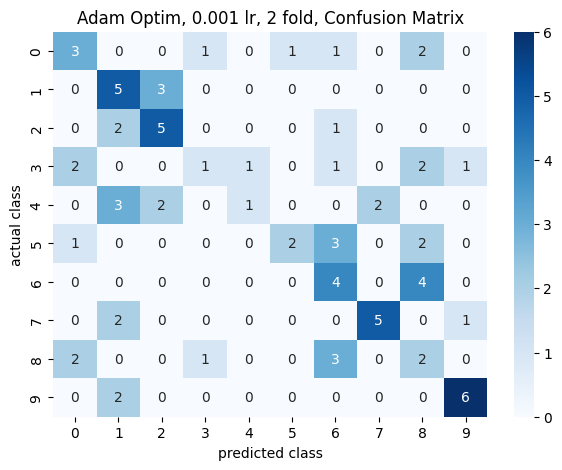

Adam, 0.001 lr, 2 fold, Overall F1 Score: 0.4128174603174603


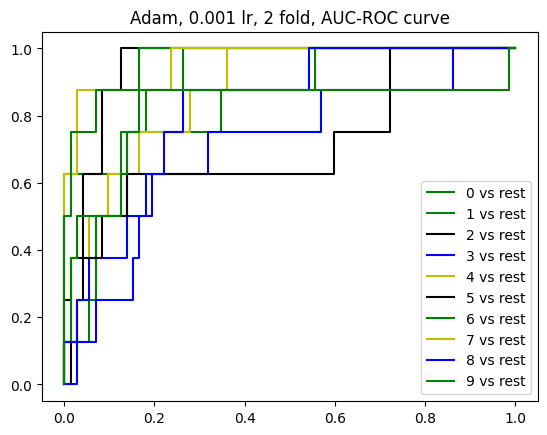

100%|██████████| 80/80 [00:00<00:00, 16191.88it/s]


3 fold, Epoch 1/100, Training Loss: 2.290414661169052, Training Accuracy: 13.75
3 fold, Epoch 1/100, Validation Loss: 2.3076756795247397, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.238904654979706, Training Accuracy: 21.25
3 fold, Epoch 2/100, Validation Loss: 2.300803263982137, Validation Accuracy: 11.25
3 fold, Epoch 3/100, Training Loss: 2.201531410217285, Training Accuracy: 31.666666666666668
3 fold, Epoch 3/100, Validation Loss: 2.2953075567881265, Validation Accuracy: 11.25
3 fold, Epoch 4/100, Training Loss: 2.1673836410045624, Training Accuracy: 33.75
3 fold, Epoch 4/100, Validation Loss: 2.2790168126424155, Validation Accuracy: 13.75
3 fold, Epoch 5/100, Training Loss: 2.1340864300727844, Training Accuracy: 37.083333333333336
3 fold, Epoch 5/100, Validation Loss: 2.2218807538350425, Validation Accuracy: 22.5
3 fold, Epoch 6/100, Training Loss: 2.112686723470688, Training Accuracy: 38.333333333333336
3 fold, Epoch 6/100, Validation Loss: 2.1958401997884116,

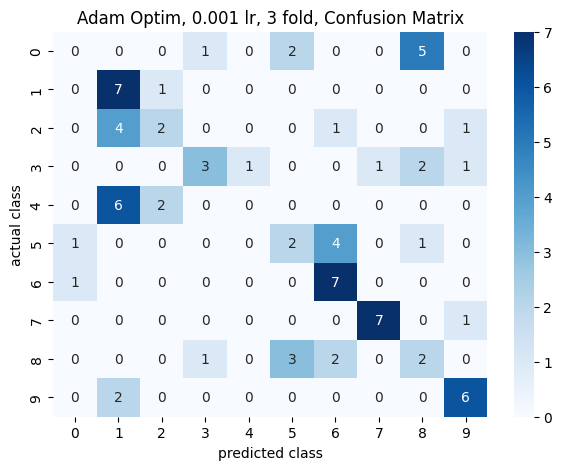

Adam, 0.001 lr, 3 fold, Overall F1 Score: 0.39938841659429897


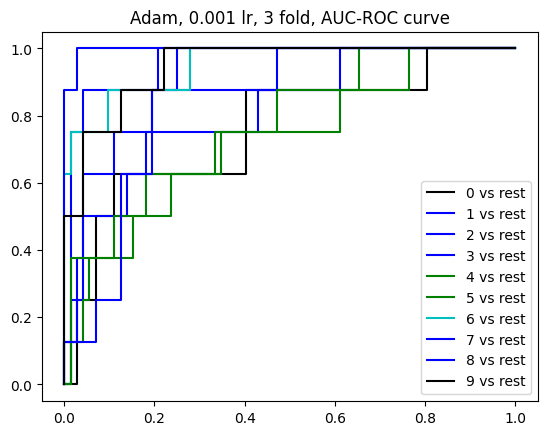

100%|██████████| 80/80 [00:00<00:00, 16416.87it/s]


4 fold, Epoch 1/100, Training Loss: 2.3071866631507874, Training Accuracy: 9.166666666666666
4 fold, Epoch 1/100, Validation Loss: 2.3028311729431152, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.2802727222442627, Training Accuracy: 15.416666666666666
4 fold, Epoch 2/100, Validation Loss: 2.3007725874582925, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.2412117421627045, Training Accuracy: 21.25
4 fold, Epoch 3/100, Validation Loss: 2.3024280865987143, Validation Accuracy: 10.0
4 fold, Epoch 4/100, Training Loss: 2.214261442422867, Training Accuracy: 30.833333333333332
4 fold, Epoch 4/100, Validation Loss: 2.271488825480143, Validation Accuracy: 17.5
4 fold, Epoch 5/100, Training Loss: 2.1764646470546722, Training Accuracy: 31.25
4 fold, Epoch 5/100, Validation Loss: 2.247654676437378, Validation Accuracy: 16.25
4 fold, Epoch 6/100, Training Loss: 2.132868528366089, Training Accuracy: 37.916666666666664
4 fold, Epoch 6/100, Validation Loss: 2.164567

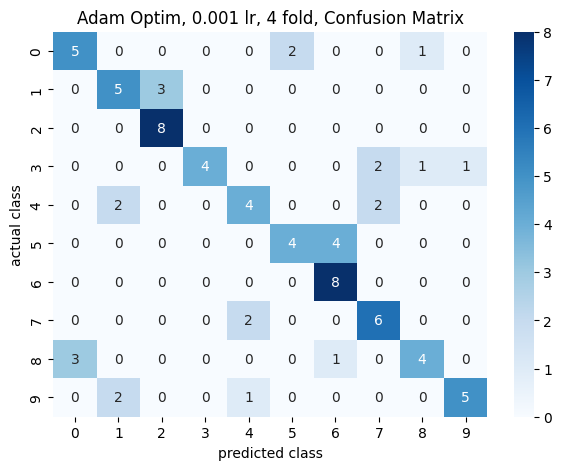

Adam, 0.001 lr, 4 fold, Overall F1 Score: 0.6541054842989827


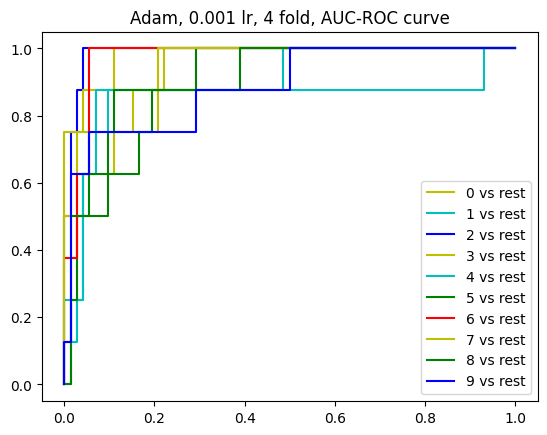

100%|██████████| 80/80 [00:00<00:00, 18202.47it/s]


5 fold, Epoch 1/100, Training Loss: 2.294811576604843, Training Accuracy: 12.916666666666666
5 fold, Epoch 1/100, Validation Loss: 2.3012026151021323, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.2463124990463257, Training Accuracy: 21.666666666666668
5 fold, Epoch 2/100, Validation Loss: 2.303905725479126, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.193282186985016, Training Accuracy: 32.916666666666664
5 fold, Epoch 3/100, Validation Loss: 2.308062712351481, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.155501753091812, Training Accuracy: 34.166666666666664
5 fold, Epoch 4/100, Validation Loss: 2.2889657020568848, Validation Accuracy: 11.25
5 fold, Epoch 5/100, Training Loss: 2.1223356425762177, Training Accuracy: 39.583333333333336
5 fold, Epoch 5/100, Validation Loss: 2.182772715886434, Validation Accuracy: 22.5
5 fold, Epoch 6/100, Training Loss: 2.1035617887973785, Training Accuracy: 42.916666666666664
5 fold, Epoch 6/100, 

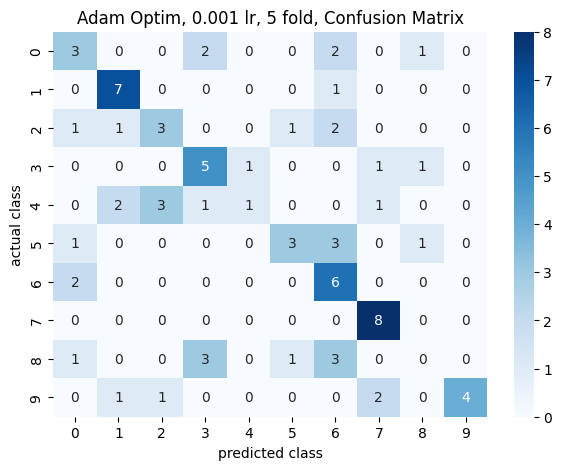

Adam, 0.001 lr, 5 fold, Overall F1 Score: 0.464636302294197


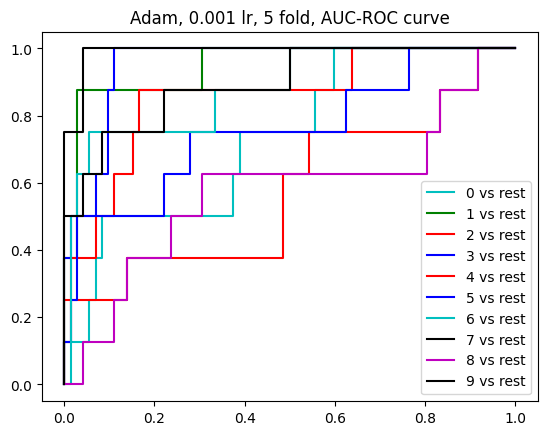

Mean validation accuracy: 53.75
Best test accuracy: 66.25


100%|██████████| 80/80 [00:00<00:00, 16579.10it/s]


2 fold, Epoch 1/100, Training Loss: 2.311189442873001, Training Accuracy: 10.0
2 fold, Epoch 1/100, Validation Loss: 2.3075076738993325, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.241664409637451, Training Accuracy: 18.333333333333332
2 fold, Epoch 2/100, Validation Loss: 2.3145023187001548, Validation Accuracy: 11.25
2 fold, Epoch 3/100, Training Loss: 2.1653294563293457, Training Accuracy: 29.166666666666668
2 fold, Epoch 3/100, Validation Loss: 2.2920031547546387, Validation Accuracy: 15.0
2 fold, Epoch 4/100, Training Loss: 2.18351474404335, Training Accuracy: 26.25
2 fold, Epoch 4/100, Validation Loss: 2.266958316167196, Validation Accuracy: 16.25
2 fold, Epoch 5/100, Training Loss: 2.1548379361629486, Training Accuracy: 30.0
2 fold, Epoch 5/100, Validation Loss: 2.1712180773417153, Validation Accuracy: 27.5
2 fold, Epoch 6/100, Training Loss: 2.1253342032432556, Training Accuracy: 34.166666666666664
2 fold, Epoch 6/100, Validation Loss: 2.2233876387278237, Va

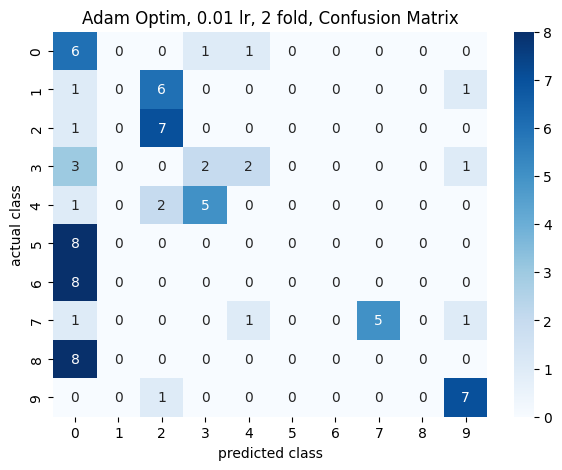

Adam, 0.01 lr, 2 fold, Overall F1 Score: 0.2647008547008547


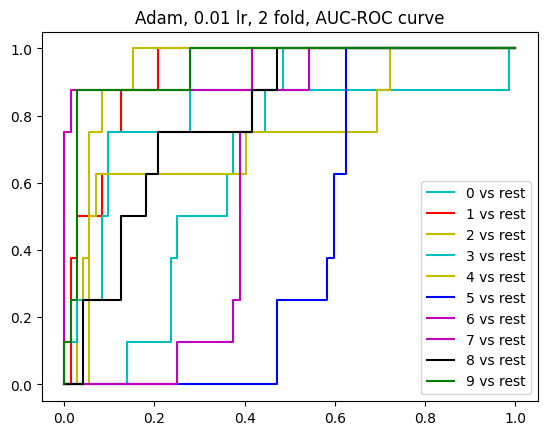

100%|██████████| 80/80 [00:00<00:00, 16977.55it/s]


3 fold, Epoch 1/100, Training Loss: 2.311404436826706, Training Accuracy: 9.583333333333334
3 fold, Epoch 1/100, Validation Loss: 2.294165770212809, Validation Accuracy: 13.75
3 fold, Epoch 2/100, Training Loss: 2.2574892342090607, Training Accuracy: 17.5
3 fold, Epoch 2/100, Validation Loss: 2.26568865776062, Validation Accuracy: 16.25
3 fold, Epoch 3/100, Training Loss: 2.2315987050533295, Training Accuracy: 22.916666666666668
3 fold, Epoch 3/100, Validation Loss: 2.230540911356608, Validation Accuracy: 20.0
3 fold, Epoch 4/100, Training Loss: 2.19817516207695, Training Accuracy: 27.5
3 fold, Epoch 4/100, Validation Loss: 2.2128565311431885, Validation Accuracy: 20.0
3 fold, Epoch 5/100, Training Loss: 2.194190204143524, Training Accuracy: 23.333333333333332
3 fold, Epoch 5/100, Validation Loss: 2.223062753677368, Validation Accuracy: 22.5
3 fold, Epoch 6/100, Training Loss: 2.1779465675354004, Training Accuracy: 27.916666666666668
3 fold, Epoch 6/100, Validation Loss: 2.192120075225

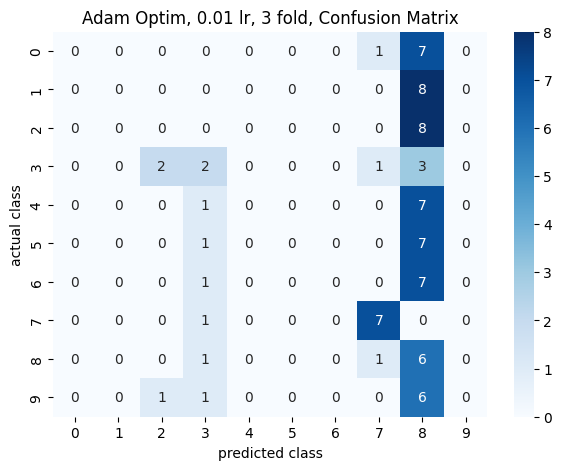

Adam, 0.01 lr, 3 fold, Overall F1 Score: 0.12068822553897181


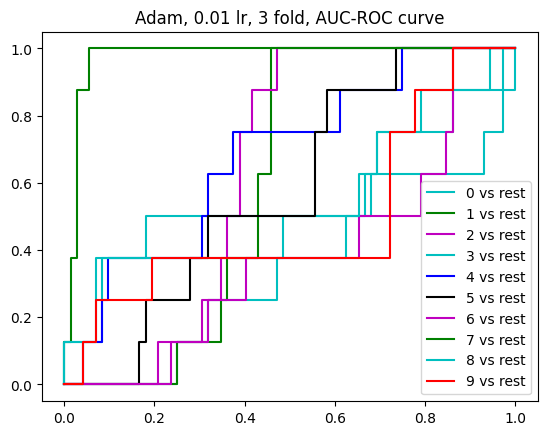

100%|██████████| 80/80 [00:00<00:00, 16309.14it/s]


4 fold, Epoch 1/100, Training Loss: 2.3112962543964386, Training Accuracy: 8.333333333333334
4 fold, Epoch 1/100, Validation Loss: 2.303153912226359, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.3111549615859985, Training Accuracy: 10.416666666666666
4 fold, Epoch 2/100, Validation Loss: 2.302264372507731, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.3048591017723083, Training Accuracy: 10.416666666666666
4 fold, Epoch 3/100, Validation Loss: 2.3010392983754477, Validation Accuracy: 16.25
4 fold, Epoch 4/100, Training Loss: 2.2730307281017303, Training Accuracy: 17.083333333333332
4 fold, Epoch 4/100, Validation Loss: 2.3088180224100747, Validation Accuracy: 10.0
4 fold, Epoch 5/100, Training Loss: 2.3046316504478455, Training Accuracy: 10.833333333333334
4 fold, Epoch 5/100, Validation Loss: 2.305670181910197, Validation Accuracy: 10.0
4 fold, Epoch 6/100, Training Loss: 2.315839111804962, Training Accuracy: 7.5
4 fold, Epoch 6/100, Validation Los

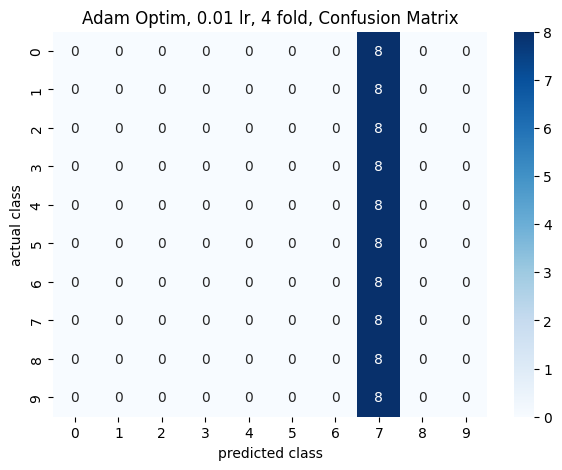

Adam, 0.01 lr, 4 fold, Overall F1 Score: 0.01818181818181818


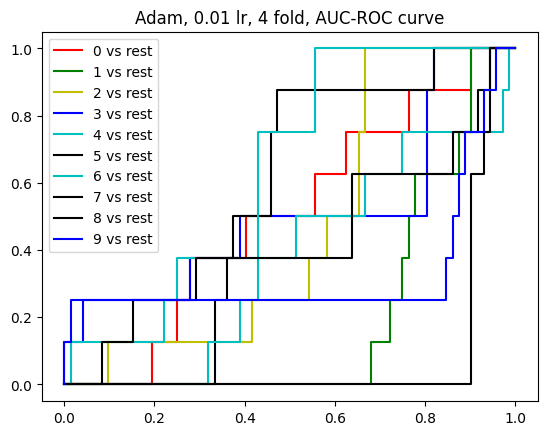

100%|██████████| 80/80 [00:00<00:00, 18289.78it/s]


5 fold, Epoch 1/100, Training Loss: 2.2735482454299927, Training Accuracy: 17.083333333333332
5 fold, Epoch 1/100, Validation Loss: 2.2313296794891357, Validation Accuracy: 18.75
5 fold, Epoch 2/100, Training Loss: 2.213981479406357, Training Accuracy: 22.5
5 fold, Epoch 2/100, Validation Loss: 2.176757017771403, Validation Accuracy: 23.75
5 fold, Epoch 3/100, Training Loss: 2.1704777479171753, Training Accuracy: 27.5
5 fold, Epoch 3/100, Validation Loss: 2.135204633076986, Validation Accuracy: 32.5
5 fold, Epoch 4/100, Training Loss: 2.12679386138916, Training Accuracy: 33.75
5 fold, Epoch 4/100, Validation Loss: 2.12038254737854, Validation Accuracy: 33.75
5 fold, Epoch 5/100, Training Loss: 2.130041480064392, Training Accuracy: 31.666666666666668
5 fold, Epoch 5/100, Validation Loss: 2.1692389647165933, Validation Accuracy: 27.5
5 fold, Epoch 6/100, Training Loss: 2.1811613738536835, Training Accuracy: 24.583333333333332
5 fold, Epoch 6/100, Validation Loss: 2.17797843615214, Valida

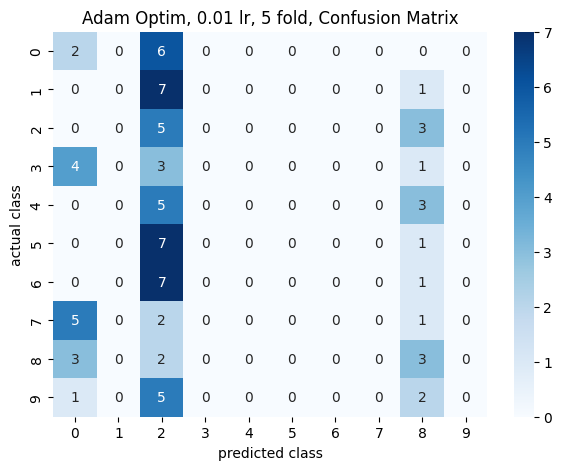

Adam, 0.01 lr, 5 fold, Overall F1 Score: 0.05993516399694889


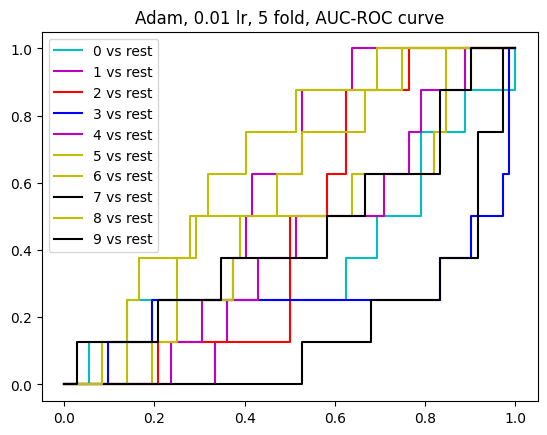

Mean validation accuracy: 20.3125
Best test accuracy: 33.75


100%|██████████| 80/80 [00:00<00:00, 16344.10it/s]


2 fold, Epoch 1/100, Training Loss: 2.3024937212467194, Training Accuracy: 7.916666666666667
2 fold, Epoch 1/100, Validation Loss: 2.3042360146840415, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.3017855286598206, Training Accuracy: 8.75
2 fold, Epoch 2/100, Validation Loss: 2.304612636566162, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.3015263080596924, Training Accuracy: 8.75
2 fold, Epoch 3/100, Validation Loss: 2.3046820958455405, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.30249559879303, Training Accuracy: 9.166666666666666
2 fold, Epoch 4/100, Validation Loss: 2.304509957631429, Validation Accuracy: 10.0
2 fold, Epoch 5/100, Training Loss: 2.302577465772629, Training Accuracy: 7.916666666666667
2 fold, Epoch 5/100, Validation Loss: 2.304044246673584, Validation Accuracy: 11.25
2 fold, Epoch 6/100, Training Loss: 2.30207496881485, Training Accuracy: 9.166666666666666
2 fold, Epoch 6/100, Validation Loss: 2.303349574406942

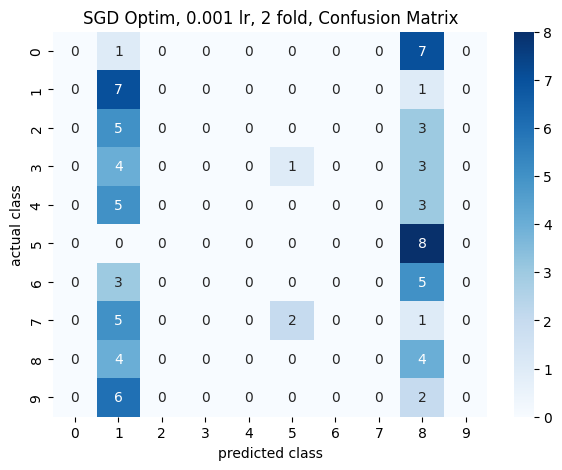

SGD, 0.001 lr, 2 fold, Overall F1 Score: 0.04694444444444444


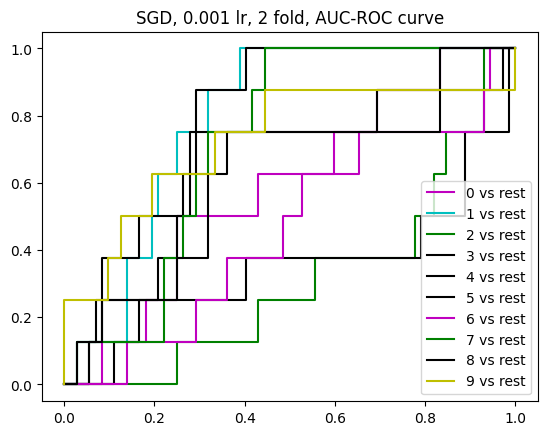

100%|██████████| 80/80 [00:00<00:00, 17588.02it/s]


3 fold, Epoch 1/100, Training Loss: 2.3019241988658905, Training Accuracy: 8.333333333333334
3 fold, Epoch 1/100, Validation Loss: 2.3018115361531577, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.30201256275177, Training Accuracy: 7.5
3 fold, Epoch 2/100, Validation Loss: 2.3016412258148193, Validation Accuracy: 10.0
3 fold, Epoch 3/100, Training Loss: 2.3014742732048035, Training Accuracy: 8.333333333333334
3 fold, Epoch 3/100, Validation Loss: 2.301356554031372, Validation Accuracy: 10.0
3 fold, Epoch 4/100, Training Loss: 2.3014348447322845, Training Accuracy: 7.916666666666667
3 fold, Epoch 4/100, Validation Loss: 2.3013163407643638, Validation Accuracy: 11.25
3 fold, Epoch 5/100, Training Loss: 2.3021616637706757, Training Accuracy: 8.75
3 fold, Epoch 5/100, Validation Loss: 2.3018943468729653, Validation Accuracy: 7.5
3 fold, Epoch 6/100, Training Loss: 2.301391750574112, Training Accuracy: 8.333333333333334
3 fold, Epoch 6/100, Validation Loss: 2.3027298450469

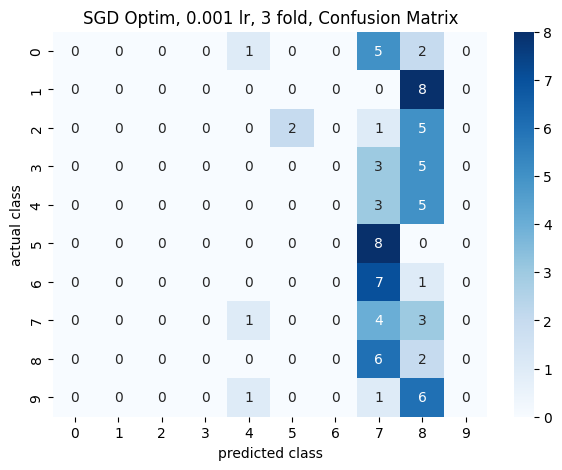

SGD, 0.001 lr, 3 fold, Overall F1 Score: 0.026280193236714978


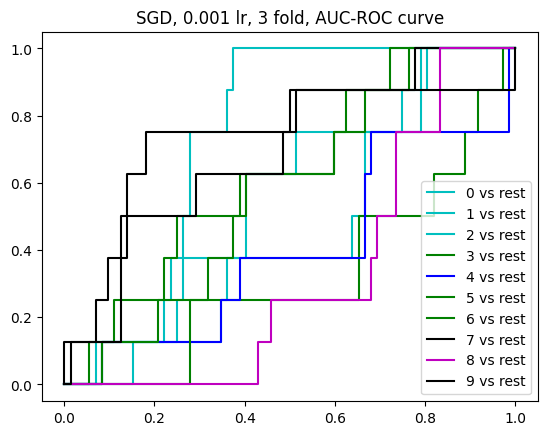

100%|██████████| 80/80 [00:00<00:00, 16309.14it/s]


4 fold, Epoch 1/100, Training Loss: 2.3040250837802887, Training Accuracy: 10.416666666666666
4 fold, Epoch 1/100, Validation Loss: 2.304176171620687, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.3053025901317596, Training Accuracy: 11.666666666666666
4 fold, Epoch 2/100, Validation Loss: 2.304203192392985, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.3052120208740234, Training Accuracy: 11.25
4 fold, Epoch 3/100, Validation Loss: 2.304192622502645, Validation Accuracy: 10.0
4 fold, Epoch 4/100, Training Loss: 2.3044140934944153, Training Accuracy: 11.25
4 fold, Epoch 4/100, Validation Loss: 2.304324467976888, Validation Accuracy: 10.0
4 fold, Epoch 5/100, Training Loss: 2.3027969002723694, Training Accuracy: 11.25
4 fold, Epoch 5/100, Validation Loss: 2.304593086242676, Validation Accuracy: 10.0
4 fold, Epoch 6/100, Training Loss: 2.3055533170700073, Training Accuracy: 11.25
4 fold, Epoch 6/100, Validation Loss: 2.304936726888021, Validation Accur

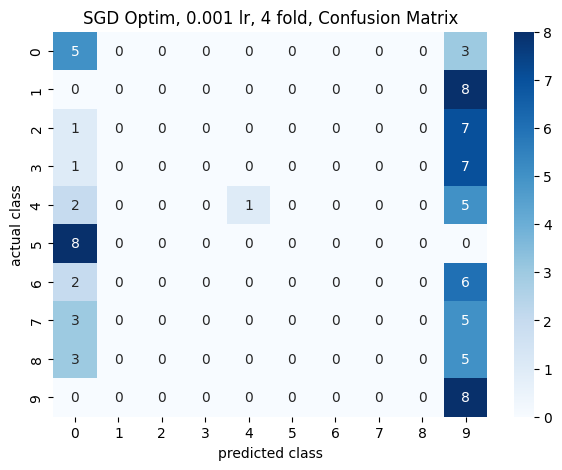

SGD, 0.001 lr, 4 fold, Overall F1 Score: 0.07833170413815575


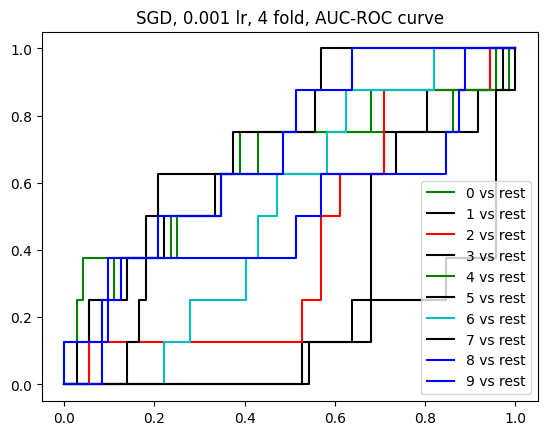

100%|██████████| 80/80 [00:00<00:00, 16471.67it/s]


5 fold, Epoch 1/100, Training Loss: 2.302695006132126, Training Accuracy: 13.333333333333334
5 fold, Epoch 1/100, Validation Loss: 2.301093657811483, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.3050603568553925, Training Accuracy: 12.5
5 fold, Epoch 2/100, Validation Loss: 2.301130533218384, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.3061199486255646, Training Accuracy: 12.916666666666666
5 fold, Epoch 3/100, Validation Loss: 2.301162004470825, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.3041991591453552, Training Accuracy: 13.333333333333334
5 fold, Epoch 4/100, Validation Loss: 2.3009785811106362, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.305555522441864, Training Accuracy: 12.083333333333334
5 fold, Epoch 5/100, Validation Loss: 2.300606648127238, Validation Accuracy: 10.0
5 fold, Epoch 6/100, Training Loss: 2.3033283352851868, Training Accuracy: 12.5
5 fold, Epoch 6/100, Validation Loss: 2.3003156979

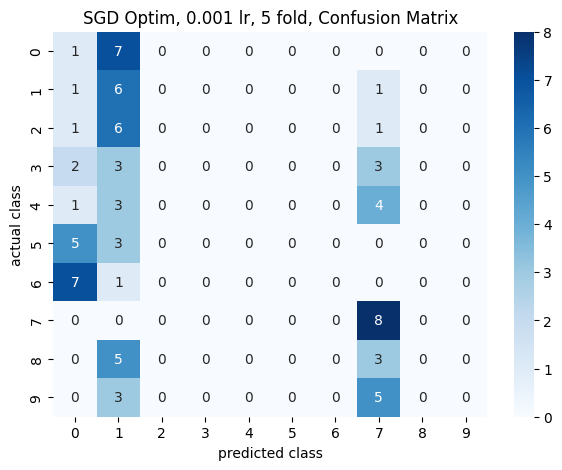

SGD, 0.001 lr, 5 fold, Overall F1 Score: 0.08284382284382284


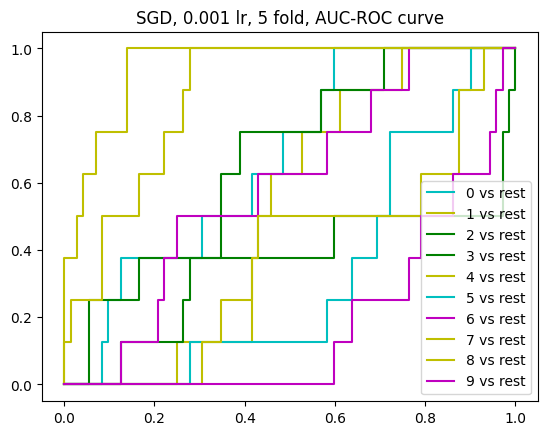

Mean validation accuracy: 15.625
Best test accuracy: 18.75


100%|██████████| 80/80 [00:00<00:00, 16451.48it/s]


2 fold, Epoch 1/100, Training Loss: 2.304418236017227, Training Accuracy: 9.583333333333334
2 fold, Epoch 1/100, Validation Loss: 2.2983477115631104, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.303921550512314, Training Accuracy: 9.166666666666666
2 fold, Epoch 2/100, Validation Loss: 2.2985278765360513, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.3048799335956573, Training Accuracy: 9.583333333333334
2 fold, Epoch 3/100, Validation Loss: 2.298823356628418, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.3040303885936737, Training Accuracy: 9.166666666666666
2 fold, Epoch 4/100, Validation Loss: 2.2989186445871987, Validation Accuracy: 10.0
2 fold, Epoch 5/100, Training Loss: 2.3031910061836243, Training Accuracy: 9.583333333333334
2 fold, Epoch 5/100, Validation Loss: 2.2989630699157715, Validation Accuracy: 10.0
2 fold, Epoch 6/100, Training Loss: 2.3041157722473145, Training Accuracy: 10.0
2 fold, Epoch 6/100, Validation Loss: 

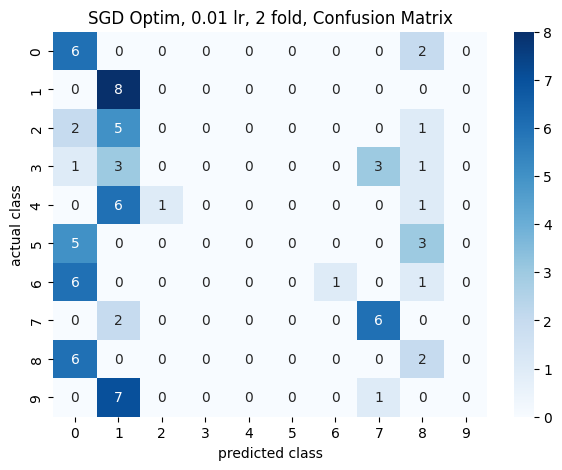

SGD, 0.01 lr, 2 fold, Overall F1 Score: 0.18626127914053608


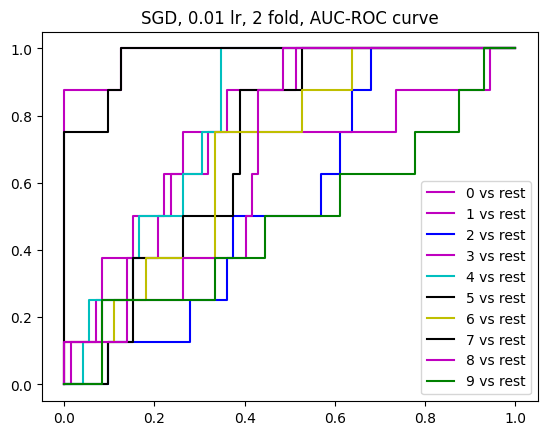

100%|██████████| 80/80 [00:00<00:00, 16575.82it/s]


3 fold, Epoch 1/100, Training Loss: 2.305675059556961, Training Accuracy: 10.0
3 fold, Epoch 1/100, Validation Loss: 2.3070268630981445, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.306180089712143, Training Accuracy: 10.0
3 fold, Epoch 2/100, Validation Loss: 2.3062613010406494, Validation Accuracy: 10.0
3 fold, Epoch 3/100, Training Loss: 2.304353713989258, Training Accuracy: 10.0
3 fold, Epoch 3/100, Validation Loss: 2.305746555328369, Validation Accuracy: 10.0
3 fold, Epoch 4/100, Training Loss: 2.3034603595733643, Training Accuracy: 10.0
3 fold, Epoch 4/100, Validation Loss: 2.3055191040039062, Validation Accuracy: 10.0
3 fold, Epoch 5/100, Training Loss: 2.302617371082306, Training Accuracy: 10.0
3 fold, Epoch 5/100, Validation Loss: 2.3051439921061196, Validation Accuracy: 10.0
3 fold, Epoch 6/100, Training Loss: 2.3040988445281982, Training Accuracy: 10.0
3 fold, Epoch 6/100, Validation Loss: 2.3044752279917398, Validation Accuracy: 10.0
3 fold, Epoch 7/100, 

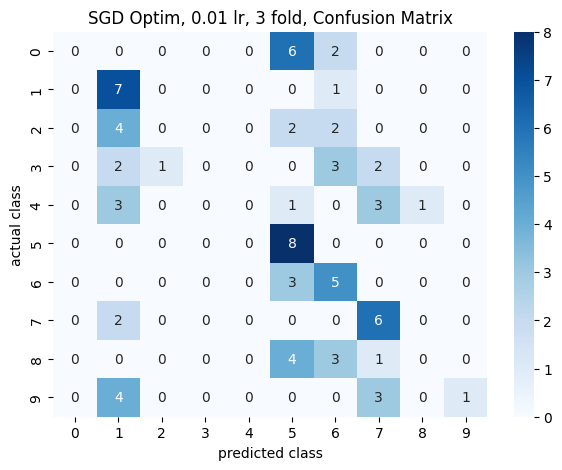

SGD, 0.01 lr, 3 fold, Overall F1 Score: 0.21272946859903383


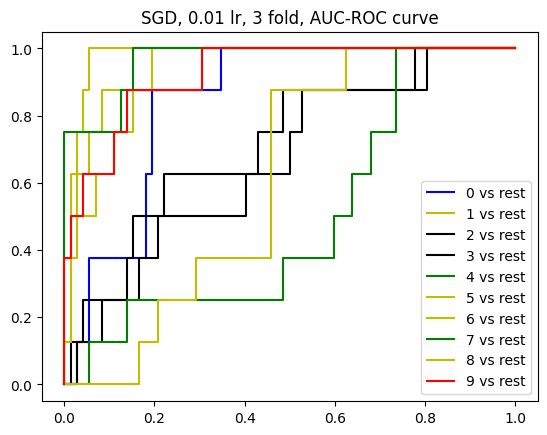

100%|██████████| 80/80 [00:00<00:00, 17796.04it/s]


4 fold, Epoch 1/100, Training Loss: 2.302350789308548, Training Accuracy: 10.0
4 fold, Epoch 1/100, Validation Loss: 2.3038068612416587, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.302079886198044, Training Accuracy: 10.0
4 fold, Epoch 2/100, Validation Loss: 2.3037234942118325, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.3024505376815796, Training Accuracy: 10.0
4 fold, Epoch 3/100, Validation Loss: 2.303567886352539, Validation Accuracy: 10.0
4 fold, Epoch 4/100, Training Loss: 2.3025845885276794, Training Accuracy: 10.0
4 fold, Epoch 4/100, Validation Loss: 2.3033218383789062, Validation Accuracy: 10.0
4 fold, Epoch 5/100, Training Loss: 2.301821082830429, Training Accuracy: 10.0
4 fold, Epoch 5/100, Validation Loss: 2.302849451700846, Validation Accuracy: 10.0
4 fold, Epoch 6/100, Training Loss: 2.3015542030334473, Training Accuracy: 10.0
4 fold, Epoch 6/100, Validation Loss: 2.3022294839223227, Validation Accuracy: 10.0
4 fold, Epoch 7/100, 

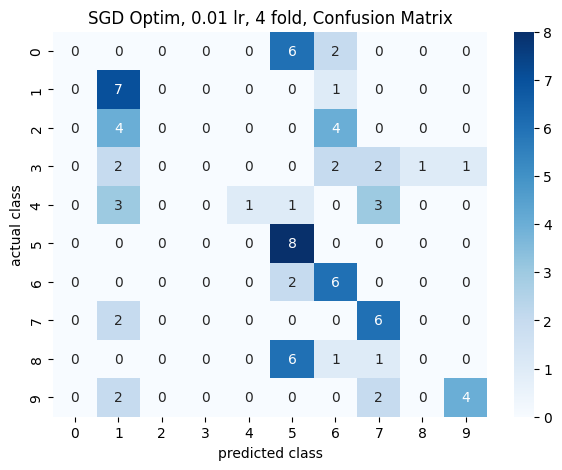

SGD, 0.01 lr, 4 fold, Overall F1 Score: 0.28991904153194475


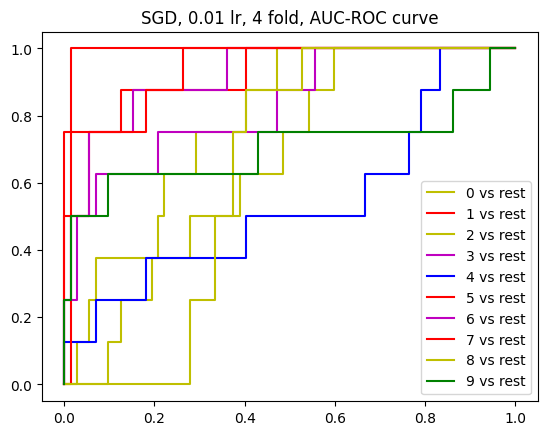

100%|██████████| 80/80 [00:00<00:00, 16492.72it/s]


5 fold, Epoch 1/100, Training Loss: 2.305787295103073, Training Accuracy: 10.416666666666666
5 fold, Epoch 1/100, Validation Loss: 2.308133125305176, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.30599707365036, Training Accuracy: 11.25
5 fold, Epoch 2/100, Validation Loss: 2.3075287342071533, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.3028334081172943, Training Accuracy: 10.416666666666666
5 fold, Epoch 3/100, Validation Loss: 2.307149648666382, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.3051051199436188, Training Accuracy: 11.666666666666666
5 fold, Epoch 4/100, Validation Loss: 2.3066817919413247, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.303218334913254, Training Accuracy: 11.666666666666666
5 fold, Epoch 5/100, Validation Loss: 2.3063270250956216, Validation Accuracy: 10.0
5 fold, Epoch 6/100, Training Loss: 2.30548819899559, Training Accuracy: 11.25
5 fold, Epoch 6/100, Validation Loss: 2.3061166604

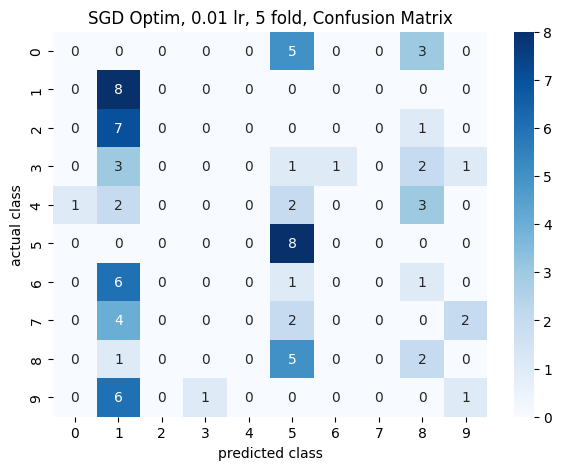

SGD, 0.01 lr, 5 fold, Overall F1 Score: 0.12222222222222223


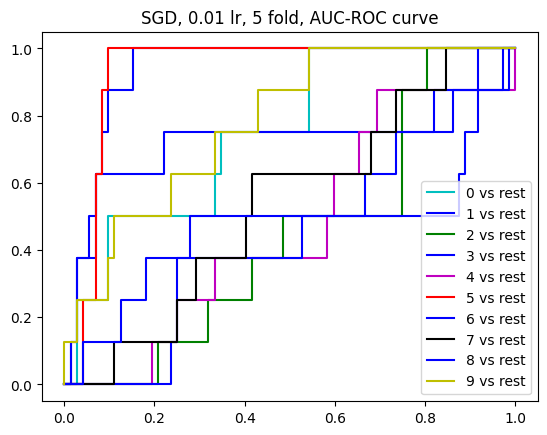

Mean validation accuracy: 30.9375
Best test accuracy: 40.0


In [13]:
for optimizer_type in optimizers:
    for lr_type in learning_rates:

        all_test_accuracy = []
        all_validation_accuracy = []
        valid_samples = [2,3,4,5]
        
        for i in valid_samples:
            # Data Setup
            test_samp = 1 #Do not change this!!
            valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = 32 # Free to change
            num_workers = 2 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                num_workers=num_workers,
                                                data_directory=path,
                                                data_frame=df,
                                                validation_fold=valid_samp,
                                                testing_fold=test_samp,  # set to 0 for no test set
                                                esc_10_flag=True,
                                                file_column='filename',
                                                label_column='category',
                                                sampling_rate=44100,
                                                new_sampling_rate=16000,  # new sample rate for input
                                                sample_length_seconds=1  # new length of input in seconds
                                                )

            custom_data_module.setup()
            
            # Hyperparameters
            num_classes = 10
            lr = lr_type
            epochs = 100
            # Model, Optimizer, Loss function
            model2 = Architecture2().to(device)
            # model2 = Architecture2()
            # optimizer = optim.Adam(model1.parameters(), lr=lr)  
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model2.parameters(), lr=lr)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model2.parameters(), lr=lr)

            criterion = nn.CrossEntropyLoss()

            # WandB initialization
            wandb.init(project="Architecture2_Model2_Head1", name=f"{optimizer_type}, {lr} lr, {i} fold")

            # Training loop
            train_acc_track = []
            val_acc_track = []
            train_loss_track = []
            val_loss_track = []

            for epoch in range(epochs):
                model2.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for data, target in custom_data_module.train_dataloader():
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model2(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = output.max(1)

                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()

                train_loss = running_loss / len(custom_data_module.train_dataloader())
                train_acc = 100. * correct / total

                train_loss_track.append(train_loss)
                train_acc_track.append(train_acc)

                print(f'{i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

                # Validation
                model2.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for data, target in custom_data_module.val_dataloader():
                        data, target = data.to(device), target.to(device)
                        output = model2(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()
                        _, predicted = output.max(1)

                        val_total += target.size(0)
                        val_correct += predicted.eq(target).sum().item()

                val_loss /= len(custom_data_module.val_dataloader())
                val_acc = 100. * val_correct / val_total

                val_loss_track.append(val_loss)
                val_acc_track.append(val_acc)

                print(f'{i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

                # # Logging
                wandb.log({"Train Loss": train_loss, "Train Acc": train_acc, "Val Loss": val_loss, "Val Acc": val_acc, "Learning rate": lr, "Optimizer": optimizer_type})


            all_validation_accuracy.append(val_acc)

            # Testing
            model2.eval()
            test_correct = 0
            test_total = 0
            all_labels_test = []
            all_preds_test = []
            all_probabilities = []

            with torch.no_grad():
                for data, target in custom_data_module.test_dataloader():
                    data, target = data.to(device), target.to(device)          
                    output = model2(data)
                    all_probabilities.extend(output.cpu().numpy())
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
                    all_labels_test.extend(target.cpu().numpy())
                    all_preds_test.extend(predicted.cpu().numpy())

            test_acc = 100. * test_correct / test_total
            print(f'{optimizer_type}, {lr} lr, {i} fold, Test Accuracy: {test_acc:.2f}%')
            # print(f'Test Accuracy: {test_acc:.2f}%')
            all_test_accuracy.append(test_acc)

            # Confusion Matrix for test set
            cm = confusion_matrix(all_labels_test, all_preds_test)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, Confusion Matrix')
            # plt.title(f'Confusion Matrix')
            plt.xlabel("predicted class",size=10)
            plt.ylabel("actual class",size=10)
            plt.show()

            # Calculate overall F1 score
            overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

            # print(f'Overall F1 Score: {overall_f1_score}')
            print(f'{optimizer_type}, {lr} lr, {i} fold, Overall F1 Score: {overall_f1_score}')

            # roc curve for classes
            fpr = {}
            tpr = {}
            thresh ={}
            n_class = 10

            for j in range(n_class):
                fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
                plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
            plt.legend()    
            # plt.title("AUC-ROC curve")
            plt.title(f'{optimizer_type}, {lr} lr, {i} fold, AUC-ROC curve')
            plt.show()  

            wandb.summary["Test accuracy"] = test_acc
            wandb.finish()

        print(f'Mean validation accuracy: {mean(all_validation_accuracy)}')
        print(f'Best test accuracy: {max(all_test_accuracy)}')

In [ ]:
#Architecture2 - Model2 - head = 2

100%|██████████| 80/80 [00:00<00:00, 17394.73it/s]


2 fold, Epoch 1/100, Training Loss: 2.3052702248096466, Training Accuracy: 9.166666666666666
2 fold, Epoch 1/100, Validation Loss: 2.308086395263672, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.246854782104492, Training Accuracy: 27.083333333333332
2 fold, Epoch 2/100, Validation Loss: 2.327566941579183, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.1933063864707947, Training Accuracy: 27.5
2 fold, Epoch 3/100, Validation Loss: 2.330749193827311, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.170184552669525, Training Accuracy: 30.0
2 fold, Epoch 4/100, Validation Loss: 2.316213766733805, Validation Accuracy: 11.25
2 fold, Epoch 5/100, Training Loss: 2.142111897468567, Training Accuracy: 33.75
2 fold, Epoch 5/100, Validation Loss: 2.2236461639404297, Validation Accuracy: 23.75
2 fold, Epoch 6/100, Training Loss: 2.1183599829673767, Training Accuracy: 39.583333333333336
2 fold, Epoch 6/100, Validation Loss: 2.1779117584228516, Valid

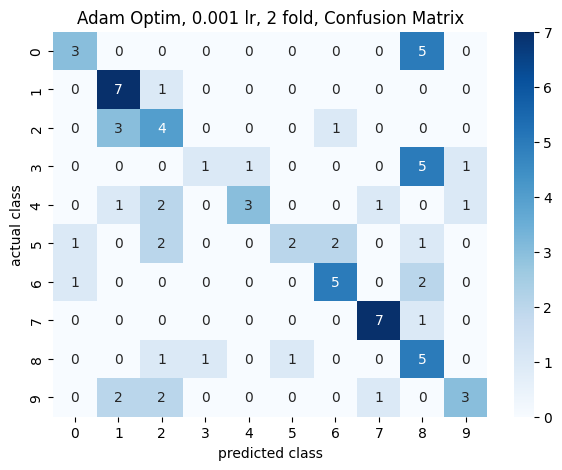

Adam, 0.001 lr, 2 fold, Overall F1 Score: 0.487227973551503


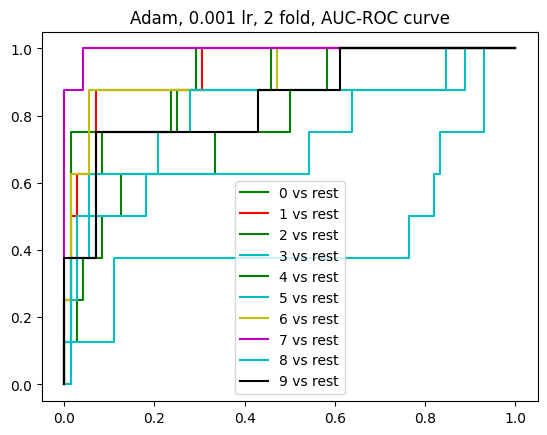

100%|██████████| 80/80 [00:00<00:00, 17026.66it/s]


3 fold, Epoch 1/100, Training Loss: 2.3110198080539703, Training Accuracy: 7.916666666666667
3 fold, Epoch 1/100, Validation Loss: 2.2999679247538247, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.278403013944626, Training Accuracy: 23.75
3 fold, Epoch 2/100, Validation Loss: 2.295027494430542, Validation Accuracy: 11.25
3 fold, Epoch 3/100, Training Loss: 2.2295715510845184, Training Accuracy: 20.416666666666668
3 fold, Epoch 3/100, Validation Loss: 2.288685401280721, Validation Accuracy: 11.25
3 fold, Epoch 4/100, Training Loss: 2.1850329637527466, Training Accuracy: 29.166666666666668
3 fold, Epoch 4/100, Validation Loss: 2.2536502679189048, Validation Accuracy: 15.0
3 fold, Epoch 5/100, Training Loss: 2.152307868003845, Training Accuracy: 33.75
3 fold, Epoch 5/100, Validation Loss: 2.225996971130371, Validation Accuracy: 17.5
3 fold, Epoch 6/100, Training Loss: 2.123146027326584, Training Accuracy: 33.75
3 fold, Epoch 6/100, Validation Loss: 2.1678813298543296, Va

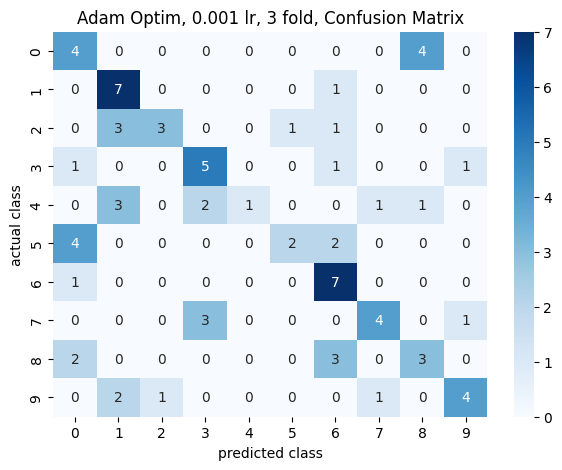

Adam, 0.001 lr, 3 fold, Overall F1 Score: 0.47766625886191105


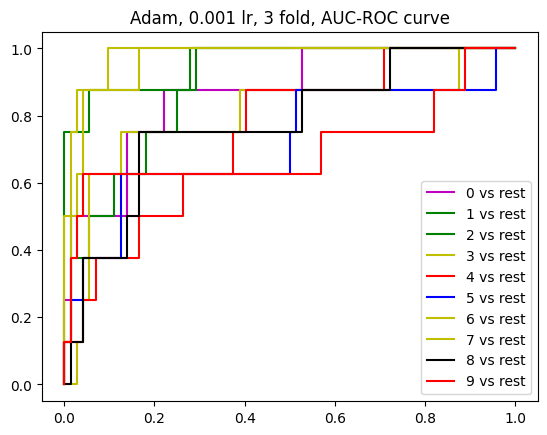

100%|██████████| 80/80 [00:00<00:00, 15673.05it/s]


4 fold, Epoch 1/100, Training Loss: 2.311418265104294, Training Accuracy: 7.5
4 fold, Epoch 1/100, Validation Loss: 2.308225472768148, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.2989516854286194, Training Accuracy: 10.0
4 fold, Epoch 2/100, Validation Loss: 2.305975357691447, Validation Accuracy: 18.75
4 fold, Epoch 3/100, Training Loss: 2.276062935590744, Training Accuracy: 19.583333333333332
4 fold, Epoch 3/100, Validation Loss: 2.3009369373321533, Validation Accuracy: 10.0
4 fold, Epoch 4/100, Training Loss: 2.229145497083664, Training Accuracy: 20.0
4 fold, Epoch 4/100, Validation Loss: 2.2862035433451333, Validation Accuracy: 11.25
4 fold, Epoch 5/100, Training Loss: 2.2048060297966003, Training Accuracy: 25.416666666666668
4 fold, Epoch 5/100, Validation Loss: 2.241502523422241, Validation Accuracy: 17.5
4 fold, Epoch 6/100, Training Loss: 2.177077054977417, Training Accuracy: 32.5
4 fold, Epoch 6/100, Validation Loss: 2.1909722487131753, Validation Accuracy:

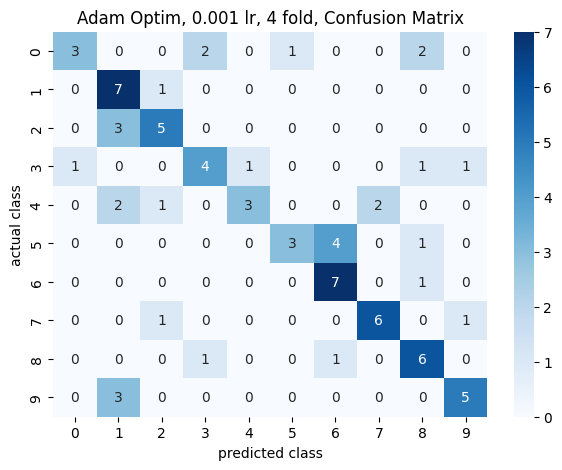

Adam, 0.001 lr, 4 fold, Overall F1 Score: 0.6015274599542335


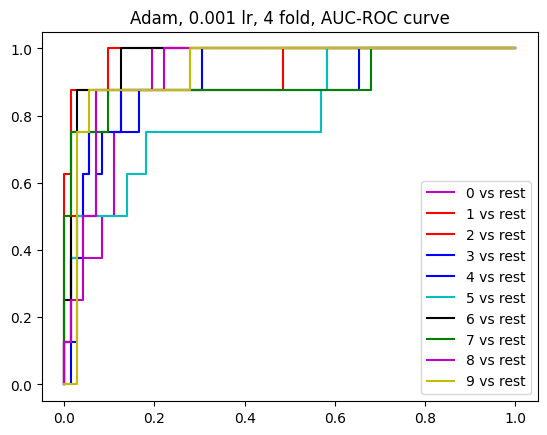

100%|██████████| 80/80 [00:00<00:00, 15569.78it/s]


5 fold, Epoch 1/100, Training Loss: 2.3120353519916534, Training Accuracy: 8.333333333333334
5 fold, Epoch 1/100, Validation Loss: 2.3009875615437827, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.300206810235977, Training Accuracy: 10.0
5 fold, Epoch 2/100, Validation Loss: 2.2993053595225015, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.2920211255550385, Training Accuracy: 18.75
5 fold, Epoch 3/100, Validation Loss: 2.3007094065348306, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.2677446007728577, Training Accuracy: 22.5
5 fold, Epoch 4/100, Validation Loss: 2.298911730448405, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.2158397138118744, Training Accuracy: 27.916666666666668
5 fold, Epoch 5/100, Validation Loss: 2.309863328933716, Validation Accuracy: 8.75
5 fold, Epoch 6/100, Training Loss: 2.168549984693527, Training Accuracy: 35.0
5 fold, Epoch 6/100, Validation Loss: 2.256925662358602, Validation Accuracy

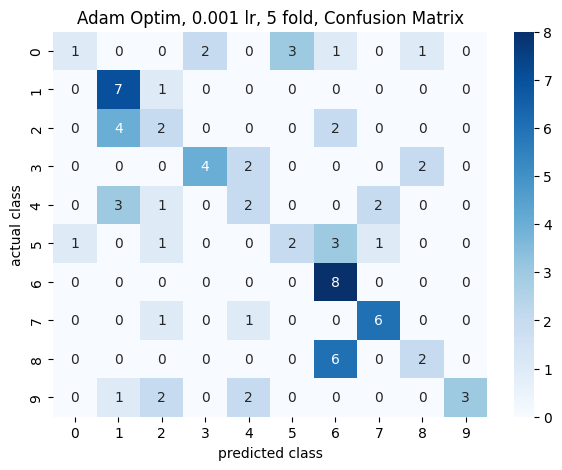

Adam, 0.001 lr, 5 fold, Overall F1 Score: 0.43349409754780605


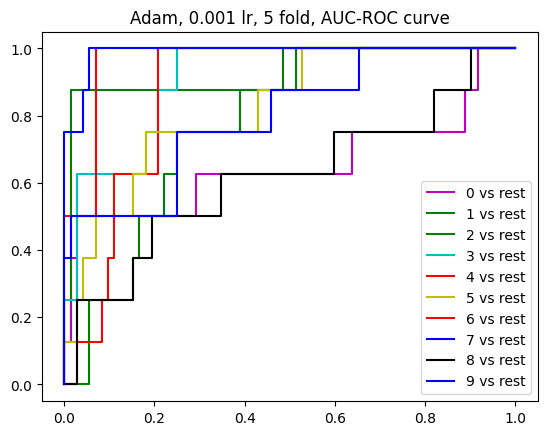

Mean validation accuracy: 54.375
Best test accuracy: 61.25


100%|██████████| 80/80 [00:00<00:00, 16965.53it/s]


2 fold, Epoch 1/100, Training Loss: 2.2884241342544556, Training Accuracy: 13.75
2 fold, Epoch 1/100, Validation Loss: 2.3087588946024575, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.264757424592972, Training Accuracy: 11.25
2 fold, Epoch 2/100, Validation Loss: 2.3071481386820474, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.2447471022605896, Training Accuracy: 17.916666666666668
2 fold, Epoch 3/100, Validation Loss: 2.22082257270813, Validation Accuracy: 13.75
2 fold, Epoch 4/100, Training Loss: 2.278052717447281, Training Accuracy: 17.5
2 fold, Epoch 4/100, Validation Loss: 2.241743485132853, Validation Accuracy: 18.75
2 fold, Epoch 5/100, Training Loss: 2.2490585446357727, Training Accuracy: 18.75
2 fold, Epoch 5/100, Validation Loss: 2.2611726919809976, Validation Accuracy: 15.0
2 fold, Epoch 6/100, Training Loss: 2.2462020814418793, Training Accuracy: 17.083333333333332
2 fold, Epoch 6/100, Validation Loss: 2.211128075917562, Validation Accu

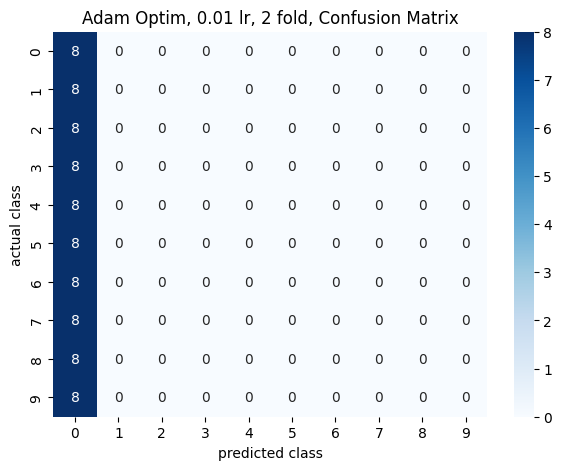

Adam, 0.01 lr, 2 fold, Overall F1 Score: 0.01818181818181818


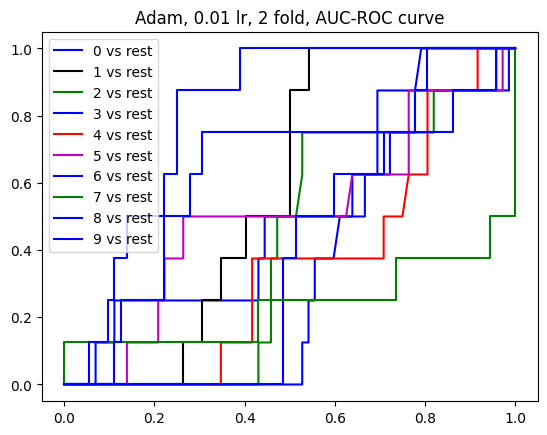

100%|██████████| 80/80 [00:00<00:00, 17321.99it/s]


3 fold, Epoch 1/100, Training Loss: 2.3145412504673004, Training Accuracy: 12.5
3 fold, Epoch 1/100, Validation Loss: 2.3182602723439536, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.253389596939087, Training Accuracy: 18.333333333333332
3 fold, Epoch 2/100, Validation Loss: 2.283180554707845, Validation Accuracy: 15.0
3 fold, Epoch 3/100, Training Loss: 2.1907977163791656, Training Accuracy: 27.5
3 fold, Epoch 3/100, Validation Loss: 2.2759339014689126, Validation Accuracy: 15.0
3 fold, Epoch 4/100, Training Loss: 2.170164406299591, Training Accuracy: 26.25
3 fold, Epoch 4/100, Validation Loss: 2.2386155923207602, Validation Accuracy: 15.0
3 fold, Epoch 5/100, Training Loss: 2.1577217280864716, Training Accuracy: 28.75
3 fold, Epoch 5/100, Validation Loss: 2.186838388442993, Validation Accuracy: 23.75
3 fold, Epoch 6/100, Training Loss: 2.1465984284877777, Training Accuracy: 29.166666666666668
3 fold, Epoch 6/100, Validation Loss: 2.1338656743367515, Validation Accu

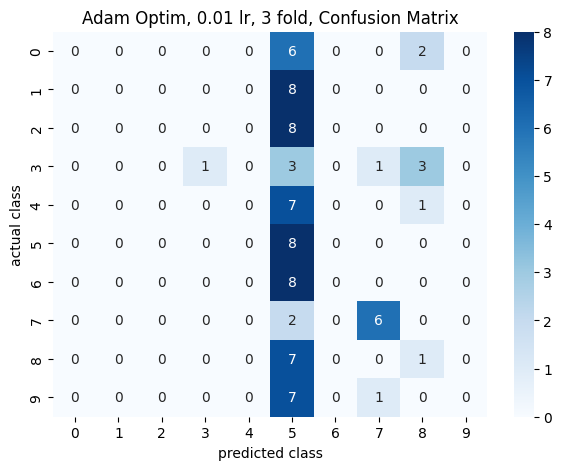

Adam, 0.01 lr, 3 fold, Overall F1 Score: 0.13277777777777777


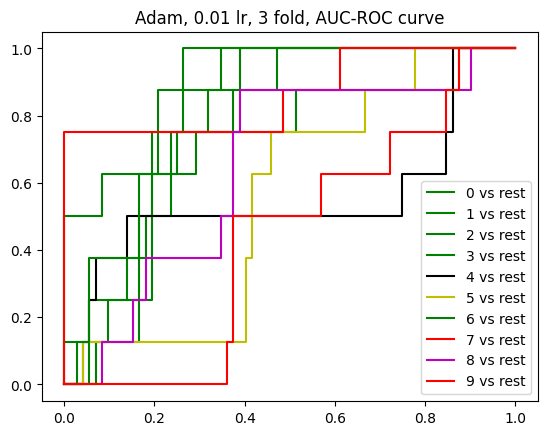

100%|██████████| 80/80 [00:00<00:00, 17156.37it/s]


4 fold, Epoch 1/100, Training Loss: 2.312616765499115, Training Accuracy: 7.5
4 fold, Epoch 1/100, Validation Loss: 2.305889050165812, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.266699582338333, Training Accuracy: 17.083333333333332
4 fold, Epoch 2/100, Validation Loss: 2.3124332427978516, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.313677340745926, Training Accuracy: 11.25
4 fold, Epoch 3/100, Validation Loss: 2.3047702312469482, Validation Accuracy: 10.0
4 fold, Epoch 4/100, Training Loss: 2.310279369354248, Training Accuracy: 7.083333333333333
4 fold, Epoch 4/100, Validation Loss: 2.2939430872599282, Validation Accuracy: 10.0
4 fold, Epoch 5/100, Training Loss: 2.304636836051941, Training Accuracy: 9.166666666666666
4 fold, Epoch 5/100, Validation Loss: 2.2944342295328775, Validation Accuracy: 10.0
4 fold, Epoch 6/100, Training Loss: 2.300305336713791, Training Accuracy: 13.333333333333334
4 fold, Epoch 6/100, Validation Loss: 2.2722551027933

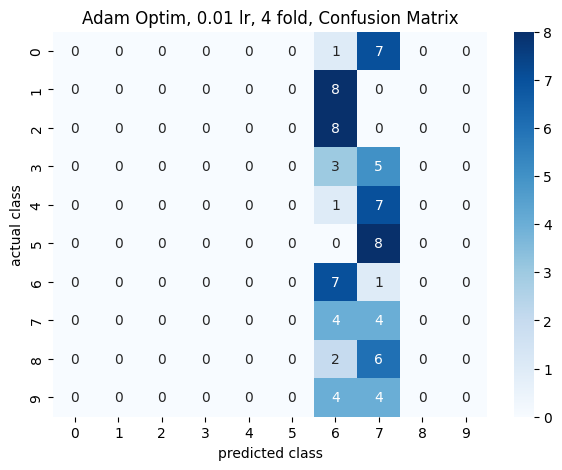

Adam, 0.01 lr, 4 fold, Overall F1 Score: 0.04643478260869566


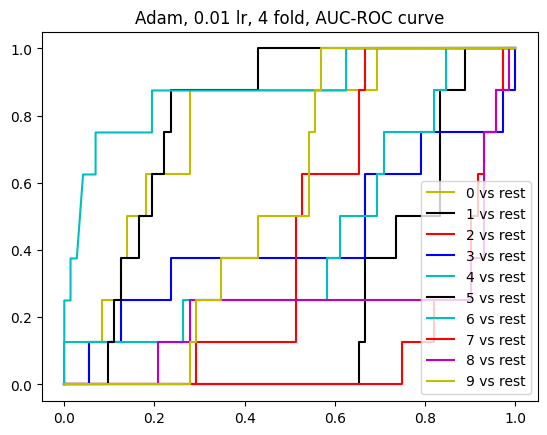

100%|██████████| 80/80 [00:00<00:00, 11667.86it/s]


5 fold, Epoch 1/100, Training Loss: 2.305727034807205, Training Accuracy: 10.833333333333334
5 fold, Epoch 1/100, Validation Loss: 2.2986562252044678, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.2486488819122314, Training Accuracy: 19.583333333333332
5 fold, Epoch 2/100, Validation Loss: 2.3061636288960776, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.249277710914612, Training Accuracy: 14.166666666666666
5 fold, Epoch 3/100, Validation Loss: 2.3110548655192056, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.25639808177948, Training Accuracy: 15.416666666666666
5 fold, Epoch 4/100, Validation Loss: 2.3005854288736978, Validation Accuracy: 11.25
5 fold, Epoch 5/100, Training Loss: 2.3029114603996277, Training Accuracy: 12.5
5 fold, Epoch 5/100, Validation Loss: 2.3142380714416504, Validation Accuracy: 10.0
5 fold, Epoch 6/100, Training Loss: 2.3161514699459076, Training Accuracy: 10.416666666666666
5 fold, Epoch 6/100, Validation L

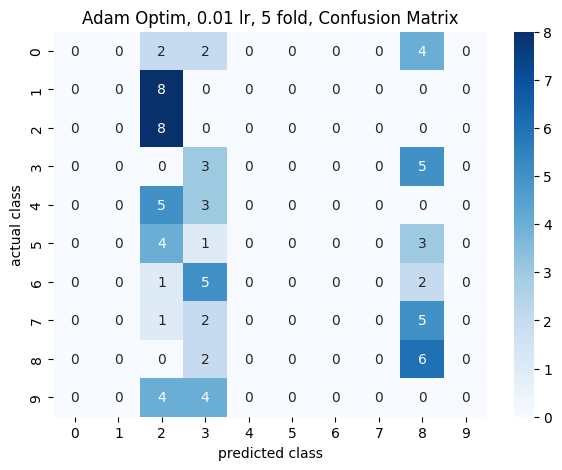

Adam, 0.01 lr, 5 fold, Overall F1 Score: 0.0953880266075388


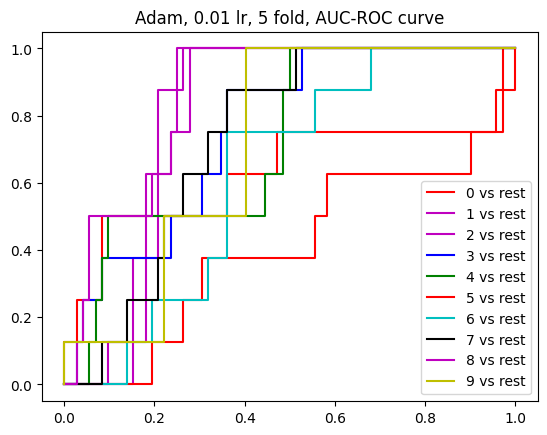

Mean validation accuracy: 15.625
Best test accuracy: 21.25


100%|██████████| 80/80 [00:00<00:00, 16979.27it/s]


2 fold, Epoch 1/100, Training Loss: 2.3042185604572296, Training Accuracy: 13.75
2 fold, Epoch 1/100, Validation Loss: 2.303138335545858, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.3027184307575226, Training Accuracy: 13.75
2 fold, Epoch 2/100, Validation Loss: 2.303098440170288, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.3027524948120117, Training Accuracy: 14.166666666666666
2 fold, Epoch 3/100, Validation Loss: 2.3029752572377524, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.3027841448783875, Training Accuracy: 13.333333333333334
2 fold, Epoch 4/100, Validation Loss: 2.302808920542399, Validation Accuracy: 10.0
2 fold, Epoch 5/100, Training Loss: 2.303578495979309, Training Accuracy: 14.583333333333334
2 fold, Epoch 5/100, Validation Loss: 2.302499453226725, Validation Accuracy: 10.0
2 fold, Epoch 6/100, Training Loss: 2.303761124610901, Training Accuracy: 13.333333333333334
2 fold, Epoch 6/100, Validation Loss: 2.30212712

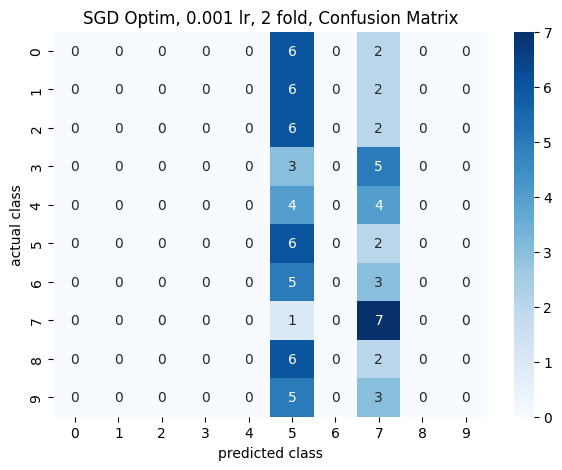

SGD, 0.001 lr, 2 fold, Overall F1 Score: 0.056428571428571425


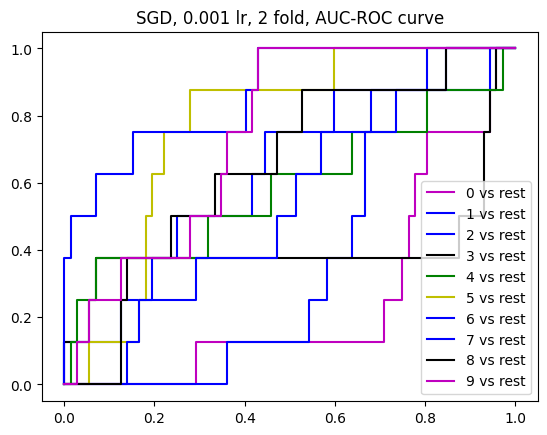

100%|██████████| 80/80 [00:00<00:00, 17075.18it/s]


3 fold, Epoch 1/100, Training Loss: 2.300149977207184, Training Accuracy: 10.833333333333334
3 fold, Epoch 1/100, Validation Loss: 2.3028481801350913, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.300688713788986, Training Accuracy: 10.0
3 fold, Epoch 2/100, Validation Loss: 2.302546739578247, Validation Accuracy: 10.0
3 fold, Epoch 3/100, Training Loss: 2.301151543855667, Training Accuracy: 11.25
3 fold, Epoch 3/100, Validation Loss: 2.302218198776245, Validation Accuracy: 20.0
3 fold, Epoch 4/100, Training Loss: 2.3002712428569794, Training Accuracy: 10.0
3 fold, Epoch 4/100, Validation Loss: 2.3016589482625327, Validation Accuracy: 10.0
3 fold, Epoch 5/100, Training Loss: 2.30058291554451, Training Accuracy: 10.416666666666666
3 fold, Epoch 5/100, Validation Loss: 2.3010082244873047, Validation Accuracy: 8.75
3 fold, Epoch 6/100, Training Loss: 2.300997167825699, Training Accuracy: 11.25
3 fold, Epoch 6/100, Validation Loss: 2.3003361225128174, Validation Accuracy:

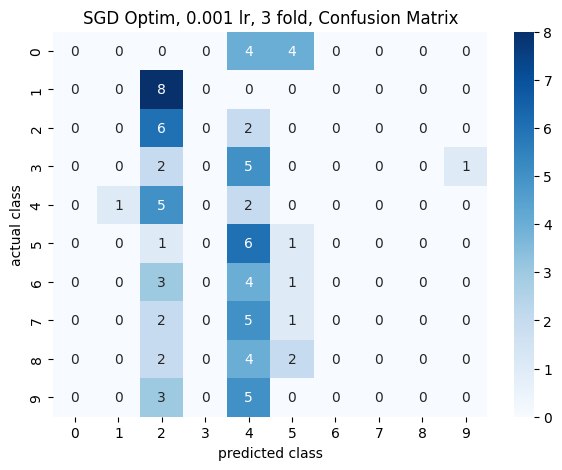

SGD, 0.001 lr, 3 fold, Overall F1 Score: 0.05065359477124183


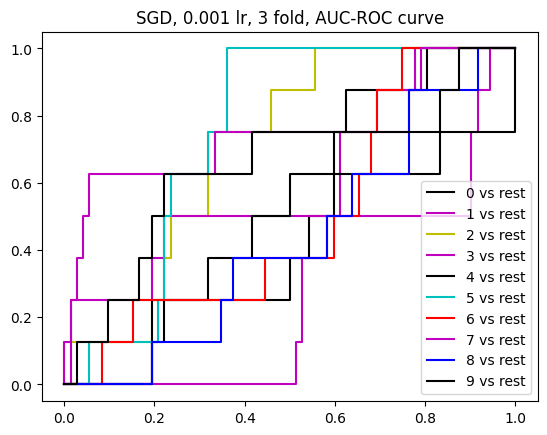

100%|██████████| 80/80 [00:00<00:00, 15791.06it/s]


4 fold, Epoch 1/100, Training Loss: 2.3052569329738617, Training Accuracy: 10.833333333333334
4 fold, Epoch 1/100, Validation Loss: 2.3090872764587402, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.303811013698578, Training Accuracy: 11.666666666666666
4 fold, Epoch 2/100, Validation Loss: 2.308941920598348, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.305952727794647, Training Accuracy: 11.666666666666666
4 fold, Epoch 3/100, Validation Loss: 2.3088045914967856, Validation Accuracy: 10.0
4 fold, Epoch 4/100, Training Loss: 2.3048989474773407, Training Accuracy: 11.25
4 fold, Epoch 4/100, Validation Loss: 2.3085782527923584, Validation Accuracy: 10.0
4 fold, Epoch 5/100, Training Loss: 2.3028315007686615, Training Accuracy: 11.25
4 fold, Epoch 5/100, Validation Loss: 2.30808162689209, Validation Accuracy: 10.0
4 fold, Epoch 6/100, Training Loss: 2.3009359538555145, Training Accuracy: 11.25
4 fold, Epoch 6/100, Validation Loss: 2.307652235031128, Val

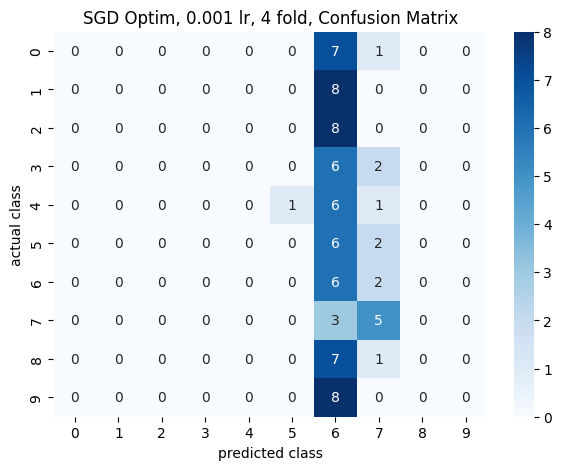

SGD, 0.001 lr, 4 fold, Overall F1 Score: 0.06189290161892902


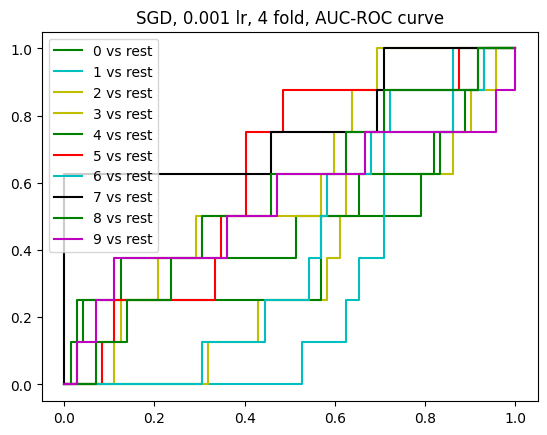

100%|██████████| 80/80 [00:00<00:00, 17197.70it/s]


5 fold, Epoch 1/100, Training Loss: 2.302966296672821, Training Accuracy: 10.0
5 fold, Epoch 1/100, Validation Loss: 2.3056372006734214, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.302032470703125, Training Accuracy: 10.0
5 fold, Epoch 2/100, Validation Loss: 2.3056154251098633, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.302881270647049, Training Accuracy: 10.0
5 fold, Epoch 3/100, Validation Loss: 2.3056055704752603, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.303191304206848, Training Accuracy: 10.0
5 fold, Epoch 4/100, Validation Loss: 2.3055436611175537, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.303088128566742, Training Accuracy: 10.0
5 fold, Epoch 5/100, Validation Loss: 2.3054960568745932, Validation Accuracy: 10.0
5 fold, Epoch 6/100, Training Loss: 2.3028168976306915, Training Accuracy: 9.583333333333334
5 fold, Epoch 6/100, Validation Loss: 2.3055502573649087, Validation Accuracy: 10.0
5 fold, 

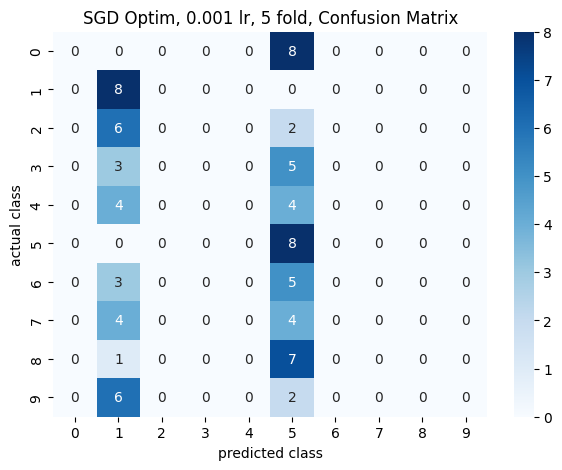

SGD, 0.001 lr, 5 fold, Overall F1 Score: 0.06739798157086441


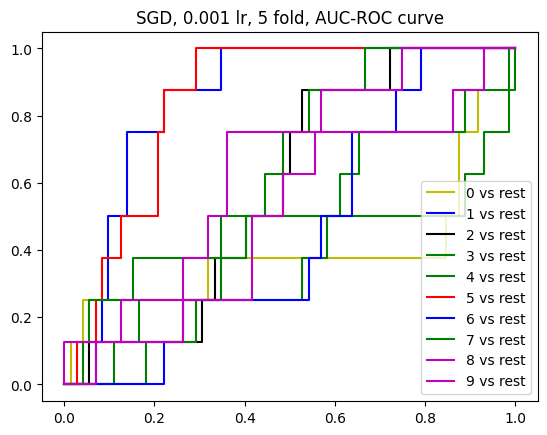

Mean validation accuracy: 16.25
Best test accuracy: 20.0


100%|██████████| 80/80 [00:00<00:00, 10984.53it/s]


2 fold, Epoch 1/100, Training Loss: 2.3049120008945465, Training Accuracy: 10.416666666666666
2 fold, Epoch 1/100, Validation Loss: 2.3070596059163413, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.305012136697769, Training Accuracy: 10.416666666666666
2 fold, Epoch 2/100, Validation Loss: 2.306221882502238, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.3042215704917908, Training Accuracy: 10.416666666666666
2 fold, Epoch 3/100, Validation Loss: 2.305148442586263, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.3030906915664673, Training Accuracy: 10.416666666666666
2 fold, Epoch 4/100, Validation Loss: 2.304689089457194, Validation Accuracy: 10.0
2 fold, Epoch 5/100, Training Loss: 2.3043903708457947, Training Accuracy: 11.25
2 fold, Epoch 5/100, Validation Loss: 2.3039873441060386, Validation Accuracy: 10.0
2 fold, Epoch 6/100, Training Loss: 2.3060300946235657, Training Accuracy: 10.416666666666666
2 fold, Epoch 6/100, Validation L

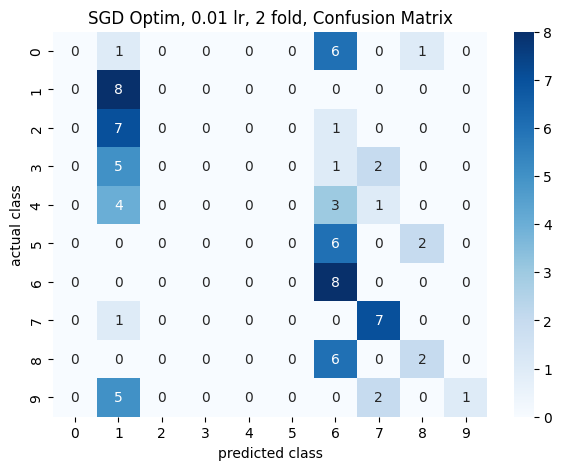

SGD, 0.01 lr, 2 fold, Overall F1 Score: 0.205042735042735


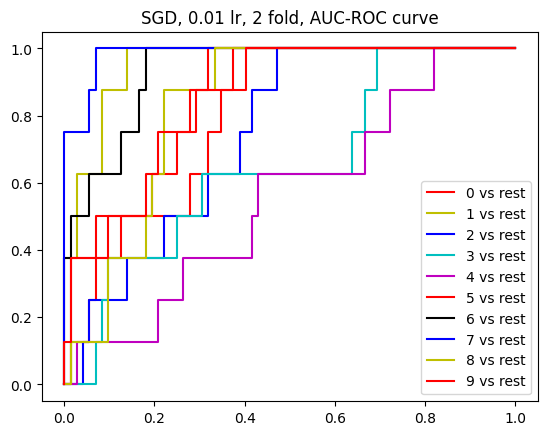

100%|██████████| 80/80 [00:00<00:00, 15889.77it/s]


3 fold, Epoch 1/100, Training Loss: 2.3044050335884094, Training Accuracy: 10.0
3 fold, Epoch 1/100, Validation Loss: 2.3055532773335776, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.304320126771927, Training Accuracy: 8.333333333333334
3 fold, Epoch 2/100, Validation Loss: 2.3055571715037027, Validation Accuracy: 10.0
3 fold, Epoch 3/100, Training Loss: 2.3042928278446198, Training Accuracy: 9.166666666666666
3 fold, Epoch 3/100, Validation Loss: 2.305643161137899, Validation Accuracy: 10.0
3 fold, Epoch 4/100, Training Loss: 2.3038267493247986, Training Accuracy: 9.166666666666666
3 fold, Epoch 4/100, Validation Loss: 2.3059173425038657, Validation Accuracy: 10.0
3 fold, Epoch 5/100, Training Loss: 2.3029984831809998, Training Accuracy: 10.0
3 fold, Epoch 5/100, Validation Loss: 2.3061224619547525, Validation Accuracy: 10.0
3 fold, Epoch 6/100, Training Loss: 2.3030965328216553, Training Accuracy: 10.0
3 fold, Epoch 6/100, Validation Loss: 2.306424697240194, Valida

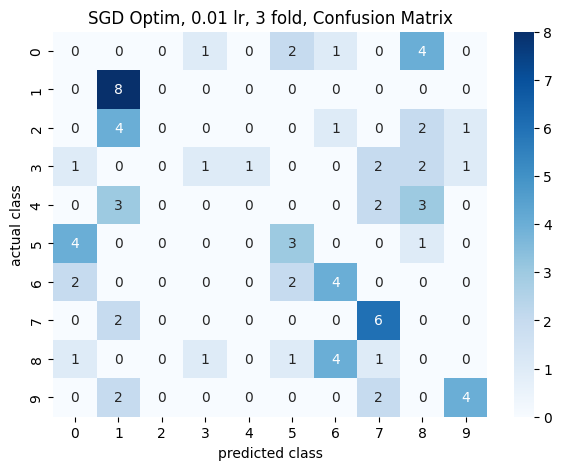

SGD, 0.01 lr, 3 fold, Overall F1 Score: 0.2736712361712362


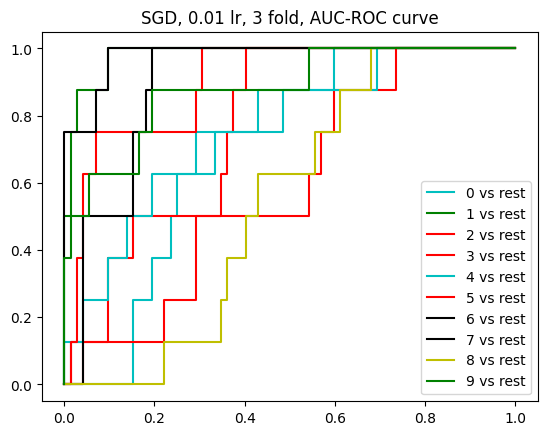

100%|██████████| 80/80 [00:00<00:00, 17057.82it/s]


4 fold, Epoch 1/100, Training Loss: 2.3094204664230347, Training Accuracy: 8.333333333333334
4 fold, Epoch 1/100, Validation Loss: 2.3041775226593018, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.3079888224601746, Training Accuracy: 9.166666666666666
4 fold, Epoch 2/100, Validation Loss: 2.303345521291097, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.307011157274246, Training Accuracy: 10.0
4 fold, Epoch 3/100, Validation Loss: 2.3026980559031167, Validation Accuracy: 10.0
4 fold, Epoch 4/100, Training Loss: 2.3056304156780243, Training Accuracy: 10.416666666666666
4 fold, Epoch 4/100, Validation Loss: 2.302307367324829, Validation Accuracy: 10.0
4 fold, Epoch 5/100, Training Loss: 2.3068031668663025, Training Accuracy: 10.416666666666666
4 fold, Epoch 5/100, Validation Loss: 2.3020833333333335, Validation Accuracy: 10.0
4 fold, Epoch 6/100, Training Loss: 2.3054115176200867, Training Accuracy: 10.416666666666666
4 fold, Epoch 6/100, Validation Los

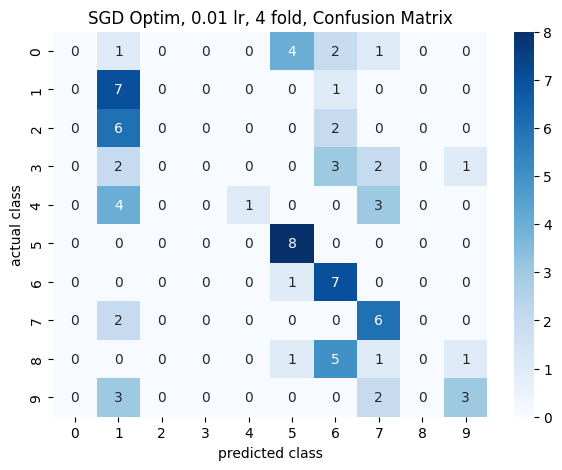

SGD, 0.01 lr, 4 fold, Overall F1 Score: 0.2857014965710618


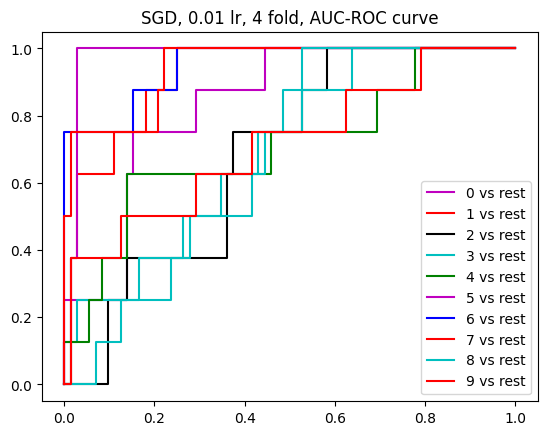

100%|██████████| 80/80 [00:00<00:00, 17295.21it/s]


5 fold, Epoch 1/100, Training Loss: 2.3042429983615875, Training Accuracy: 10.833333333333334
5 fold, Epoch 1/100, Validation Loss: 2.306084394454956, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.3032712638378143, Training Accuracy: 11.25
5 fold, Epoch 2/100, Validation Loss: 2.3060998916625977, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.304030865430832, Training Accuracy: 10.416666666666666
5 fold, Epoch 3/100, Validation Loss: 2.306097904841105, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.3039329648017883, Training Accuracy: 11.25
5 fold, Epoch 4/100, Validation Loss: 2.3059860865275064, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.302096962928772, Training Accuracy: 13.333333333333334
5 fold, Epoch 5/100, Validation Loss: 2.3055379390716553, Validation Accuracy: 10.0
5 fold, Epoch 6/100, Training Loss: 2.303259491920471, Training Accuracy: 14.583333333333334
5 fold, Epoch 6/100, Validation Loss: 2.3047288

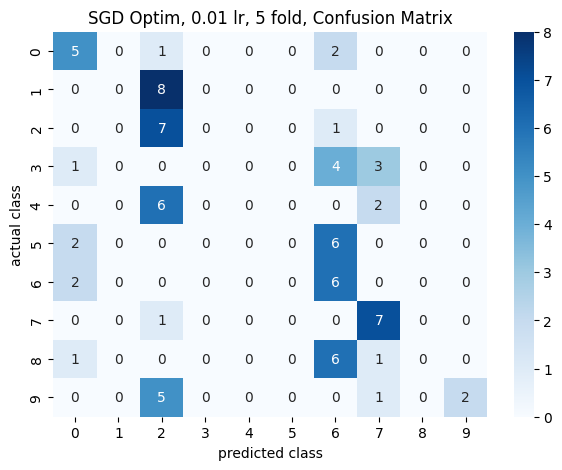

SGD, 0.01 lr, 5 fold, Overall F1 Score: 0.23152046783625732


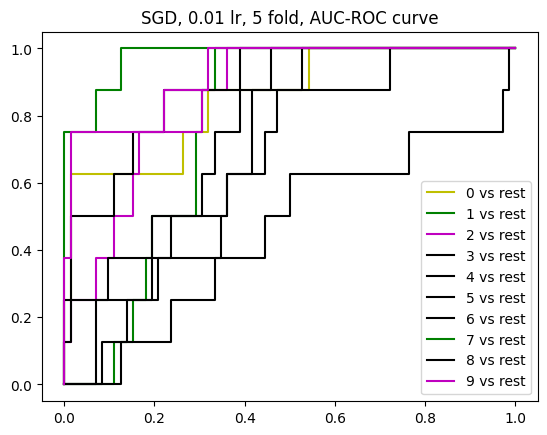

Mean validation accuracy: 33.75
Best test accuracy: 40.0


In [23]:
for optimizer_type in optimizers:
    for lr_type in learning_rates:

        all_test_accuracy = []
        all_validation_accuracy = []
        valid_samples = [2,3,4,5]
        
        for i in valid_samples:
            # Data Setup
            test_samp = 1 #Do not change this!!
            valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = 32 # Free to change
            num_workers = 2 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                num_workers=num_workers,
                                                data_directory=path,
                                                data_frame=df,
                                                validation_fold=valid_samp,
                                                testing_fold=test_samp,  # set to 0 for no test set
                                                esc_10_flag=True,
                                                file_column='filename',
                                                label_column='category',
                                                sampling_rate=44100,
                                                new_sampling_rate=16000,  # new sample rate for input
                                                sample_length_seconds=1  # new length of input in seconds
                                                )

            custom_data_module.setup()
            
            # Hyperparameters
            num_classes = 10
            lr = lr_type
            epochs = 100
            # Model, Optimizer, Loss function
            model2 = Architecture2().to(device)
            # model2 = Architecture2()
            # optimizer = optim.Adam(model1.parameters(), lr=lr)  
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model2.parameters(), lr=lr)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model2.parameters(), lr=lr)

            criterion = nn.CrossEntropyLoss()

            # WandB initialization
            wandb.init(project="Architecture2_Model2", name=f"{optimizer_type}, {lr} lr, {i} fold")

            # Training loop
            train_acc_track = []
            val_acc_track = []
            train_loss_track = []
            val_loss_track = []

            for epoch in range(epochs):
                model2.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for data, target in custom_data_module.train_dataloader():
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model2(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = output.max(1)

                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()

                train_loss = running_loss / len(custom_data_module.train_dataloader())
                train_acc = 100. * correct / total

                train_loss_track.append(train_loss)
                train_acc_track.append(train_acc)

                print(f'{i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

                # Validation
                model2.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for data, target in custom_data_module.val_dataloader():
                        data, target = data.to(device), target.to(device)
                        output = model2(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()
                        _, predicted = output.max(1)

                        val_total += target.size(0)
                        val_correct += predicted.eq(target).sum().item()

                val_loss /= len(custom_data_module.val_dataloader())
                val_acc = 100. * val_correct / val_total

                val_loss_track.append(val_loss)
                val_acc_track.append(val_acc)

                print(f'{i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

                # # Logging
                wandb.log({"Train Loss": train_loss, "Train Acc": train_acc, "Val Loss": val_loss, "Val Acc": val_acc, "Learning rate": lr, "Optimizer": optimizer_type})


            all_validation_accuracy.append(val_acc)

            # Testing
            model2.eval()
            test_correct = 0
            test_total = 0
            all_labels_test = []
            all_preds_test = []
            all_probabilities = []

            with torch.no_grad():
                for data, target in custom_data_module.test_dataloader():
                    data, target = data.to(device), target.to(device)          
                    output = model2(data)
                    all_probabilities.extend(output.cpu().numpy())
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
                    all_labels_test.extend(target.cpu().numpy())
                    all_preds_test.extend(predicted.cpu().numpy())

            test_acc = 100. * test_correct / test_total
            print(f'{optimizer_type}, {lr} lr, {i} fold, Test Accuracy: {test_acc:.2f}%')
            # print(f'Test Accuracy: {test_acc:.2f}%')
            all_test_accuracy.append(test_acc)

            # Confusion Matrix for test set
            cm = confusion_matrix(all_labels_test, all_preds_test)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, Confusion Matrix')
            # plt.title(f'Confusion Matrix')
            plt.xlabel("predicted class",size=10)
            plt.ylabel("actual class",size=10)
            plt.show()

            # Calculate overall F1 score
            overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

            # print(f'Overall F1 Score: {overall_f1_score}')
            print(f'{optimizer_type}, {lr} lr, {i} fold, Overall F1 Score: {overall_f1_score}')

            # roc curve for classes
            fpr = {}
            tpr = {}
            thresh ={}
            n_class = 10

            for j in range(n_class):
                fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
                plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
            plt.legend()    
            # plt.title("AUC-ROC curve")
            plt.title(f'{optimizer_type}, {lr} lr, {i} fold, AUC-ROC curve')
            plt.show()  

            wandb.summary["Test accuracy"] = test_acc
            wandb.finish()

        print(f'Mean validation accuracy: {mean(all_validation_accuracy)}')
        print(f'Best test accuracy: {max(all_test_accuracy)}')

In [ ]:
#Architecture2 - Model2 - Head =4

100%|██████████| 80/80 [00:00<00:00, 11021.33it/s]
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m23csa014. Use `wandb login --relogin` to force relogin


2 fold, Epoch 1/100, Training Loss: 2.311267524957657, Training Accuracy: 9.583333333333334
2 fold, Epoch 1/100, Validation Loss: 2.3109232584635415, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.2723185420036316, Training Accuracy: 19.583333333333332
2 fold, Epoch 2/100, Validation Loss: 2.319997708002726, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.2351244688034058, Training Accuracy: 21.25
2 fold, Epoch 3/100, Validation Loss: 2.3184356689453125, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.204594701528549, Training Accuracy: 25.833333333333332
2 fold, Epoch 4/100, Validation Loss: 2.280017296473185, Validation Accuracy: 16.25
2 fold, Epoch 5/100, Training Loss: 2.1647360026836395, Training Accuracy: 29.166666666666668
2 fold, Epoch 5/100, Validation Loss: 2.2226807276407876, Validation Accuracy: 17.5
2 fold, Epoch 6/100, Training Loss: 2.143334746360779, Training Accuracy: 35.833333333333336
2 fold, Epoch 6/100, Validation Lo

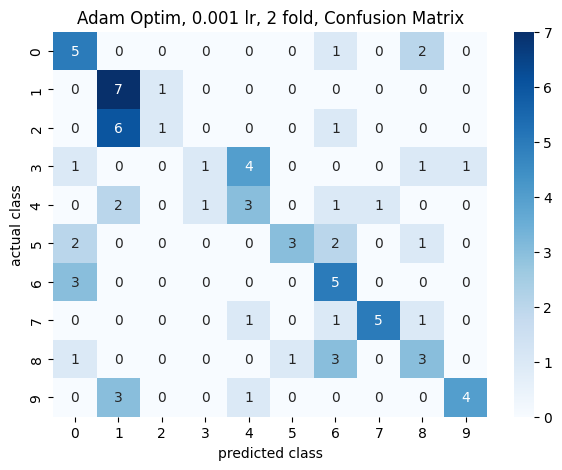

Adam, 0.001 lr, 2 fold, Overall F1 Score: 0.4450618499147911


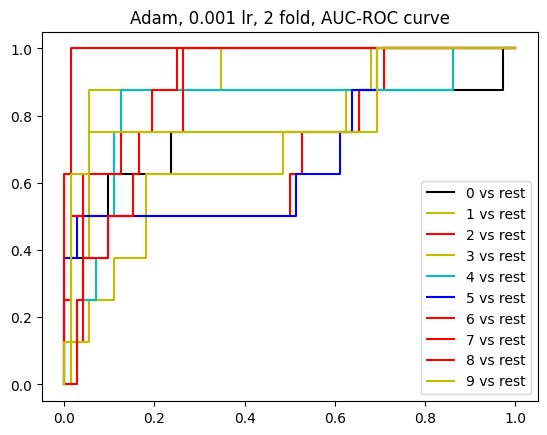

100%|██████████| 80/80 [00:00<00:00, 17229.49it/s]


3 fold, Epoch 1/100, Training Loss: 2.2885031700134277, Training Accuracy: 15.0
3 fold, Epoch 1/100, Validation Loss: 2.307426850001017, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.2405650913715363, Training Accuracy: 18.75
3 fold, Epoch 2/100, Validation Loss: 2.3059858481089273, Validation Accuracy: 10.0
3 fold, Epoch 3/100, Training Loss: 2.196994811296463, Training Accuracy: 26.666666666666668
3 fold, Epoch 3/100, Validation Loss: 2.30029026667277, Validation Accuracy: 11.25
3 fold, Epoch 4/100, Training Loss: 2.1684596836566925, Training Accuracy: 30.833333333333332
3 fold, Epoch 4/100, Validation Loss: 2.295068105061849, Validation Accuracy: 11.25
3 fold, Epoch 5/100, Training Loss: 2.1297149658203125, Training Accuracy: 37.5
3 fold, Epoch 5/100, Validation Loss: 2.245511849721273, Validation Accuracy: 18.75
3 fold, Epoch 6/100, Training Loss: 2.0958532094955444, Training Accuracy: 40.416666666666664
3 fold, Epoch 6/100, Validation Loss: 2.196077585220337, Val

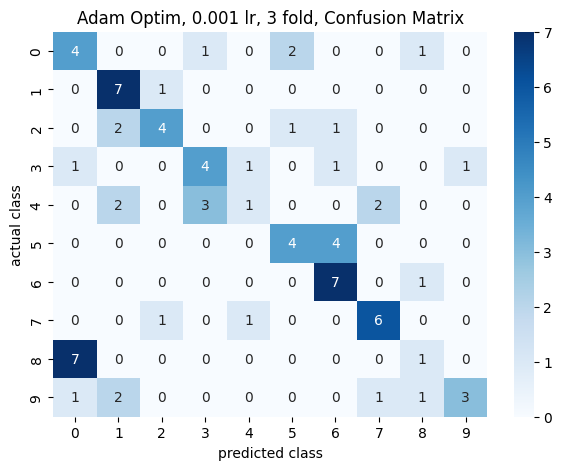

Adam, 0.001 lr, 3 fold, Overall F1 Score: 0.4873414820473645


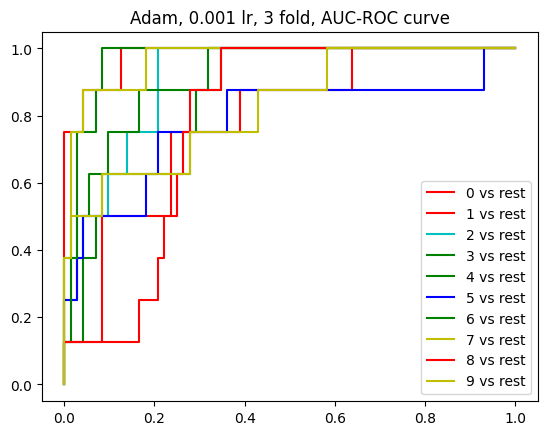

100%|██████████| 80/80 [00:00<00:00, 17501.79it/s]


4 fold, Epoch 1/100, Training Loss: 2.3002534806728363, Training Accuracy: 12.5
4 fold, Epoch 1/100, Validation Loss: 2.3046061197916665, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.243959963321686, Training Accuracy: 24.166666666666668
4 fold, Epoch 2/100, Validation Loss: 2.3154691060384116, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.191730409860611, Training Accuracy: 25.0
4 fold, Epoch 3/100, Validation Loss: 2.303018649419149, Validation Accuracy: 11.25
4 fold, Epoch 4/100, Training Loss: 2.149991363286972, Training Accuracy: 35.833333333333336
4 fold, Epoch 4/100, Validation Loss: 2.2617745399475098, Validation Accuracy: 17.5
4 fold, Epoch 5/100, Training Loss: 2.113963156938553, Training Accuracy: 40.416666666666664
4 fold, Epoch 5/100, Validation Loss: 2.1646323998769126, Validation Accuracy: 26.25
4 fold, Epoch 6/100, Training Loss: 2.0952018797397614, Training Accuracy: 43.333333333333336
4 fold, Epoch 6/100, Validation Loss: 2.1036646

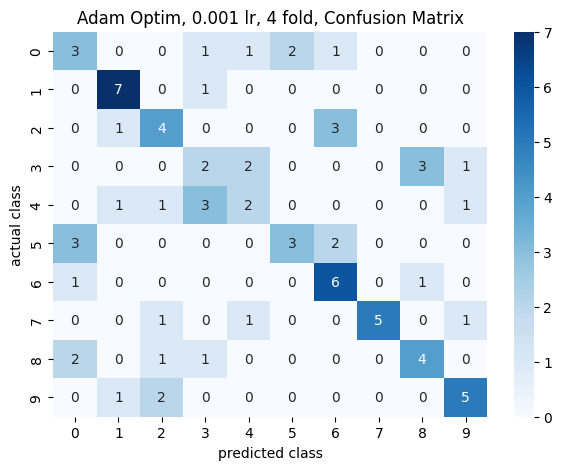

Adam, 0.001 lr, 4 fold, Overall F1 Score: 0.5092790706026


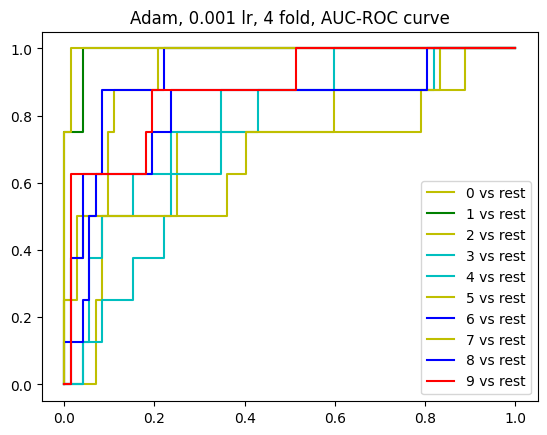

100%|██████████| 80/80 [00:00<00:00, 16017.96it/s]


5 fold, Epoch 1/100, Training Loss: 2.3098050355911255, Training Accuracy: 9.583333333333334
5 fold, Epoch 1/100, Validation Loss: 2.3054699897766113, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.271064668893814, Training Accuracy: 18.75
5 fold, Epoch 2/100, Validation Loss: 2.3066470623016357, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.2178541719913483, Training Accuracy: 31.25
5 fold, Epoch 3/100, Validation Loss: 2.311014095942179, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.1539678275585175, Training Accuracy: 32.5
5 fold, Epoch 4/100, Validation Loss: 2.242607593536377, Validation Accuracy: 20.0
5 fold, Epoch 5/100, Training Loss: 2.1168863773345947, Training Accuracy: 39.166666666666664
5 fold, Epoch 5/100, Validation Loss: 2.1673723061879477, Validation Accuracy: 33.75
5 fold, Epoch 6/100, Training Loss: 2.1016306579113007, Training Accuracy: 39.583333333333336
5 fold, Epoch 6/100, Validation Loss: 2.1414129734039307, V

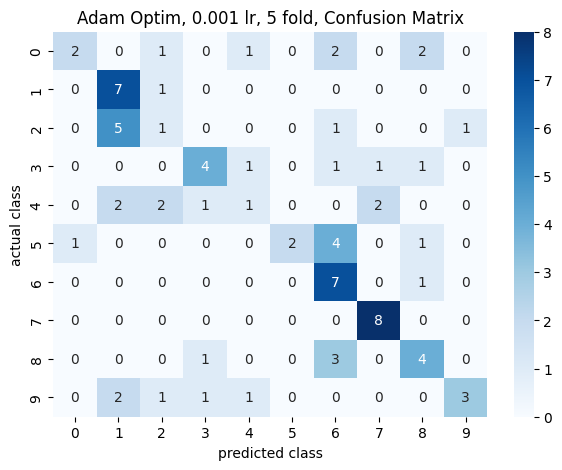

Adam, 0.001 lr, 5 fold, Overall F1 Score: 0.4540981876740391


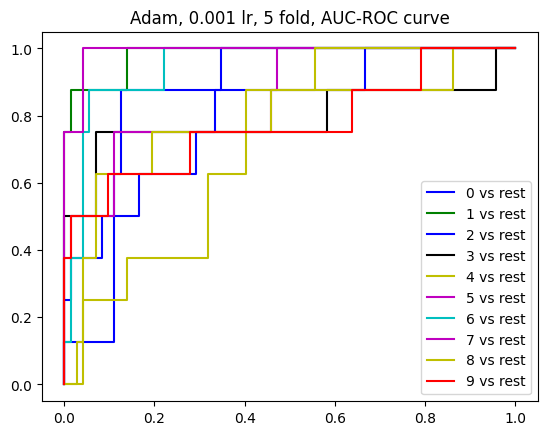

Mean validation accuracy: 57.5
Best test accuracy: 51.25


100%|██████████| 80/80 [00:00<00:00, 11545.81it/s]


2 fold, Epoch 1/100, Training Loss: 2.2961294054985046, Training Accuracy: 12.083333333333334
2 fold, Epoch 1/100, Validation Loss: 2.277392625808716, Validation Accuracy: 13.75
2 fold, Epoch 2/100, Training Loss: 2.2080391943454742, Training Accuracy: 25.0
2 fold, Epoch 2/100, Validation Loss: 2.2214572429656982, Validation Accuracy: 22.5
2 fold, Epoch 3/100, Training Loss: 2.1647785902023315, Training Accuracy: 26.666666666666668
2 fold, Epoch 3/100, Validation Loss: 2.2419561545054116, Validation Accuracy: 20.0
2 fold, Epoch 4/100, Training Loss: 2.1458292305469513, Training Accuracy: 29.583333333333332
2 fold, Epoch 4/100, Validation Loss: 2.20023250579834, Validation Accuracy: 28.75
2 fold, Epoch 5/100, Training Loss: 2.098795086145401, Training Accuracy: 36.25
2 fold, Epoch 5/100, Validation Loss: 2.14201029141744, Validation Accuracy: 32.5
2 fold, Epoch 6/100, Training Loss: 2.0989830493927, Training Accuracy: 35.833333333333336
2 fold, Epoch 6/100, Validation Loss: 2.1810365517

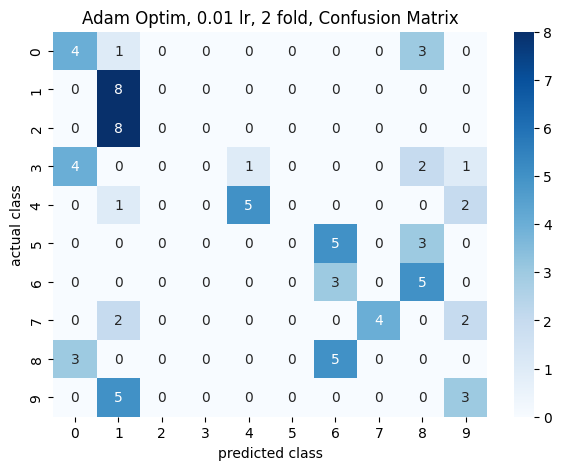

Adam, 0.01 lr, 2 fold, Overall F1 Score: 0.2947567783094099


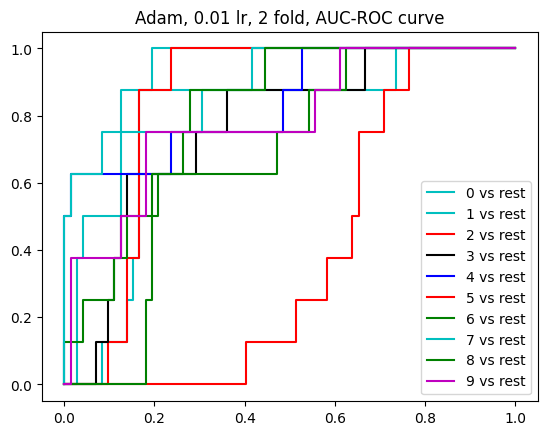

100%|██████████| 80/80 [00:00<00:00, 15841.01it/s]


3 fold, Epoch 1/100, Training Loss: 2.306267589330673, Training Accuracy: 11.25
3 fold, Epoch 1/100, Validation Loss: 2.286163330078125, Validation Accuracy: 11.25
3 fold, Epoch 2/100, Training Loss: 2.2663786113262177, Training Accuracy: 17.083333333333332
3 fold, Epoch 2/100, Validation Loss: 2.2879534562428794, Validation Accuracy: 12.5
3 fold, Epoch 3/100, Training Loss: 2.2329278886318207, Training Accuracy: 20.0
3 fold, Epoch 3/100, Validation Loss: 2.2829643885294595, Validation Accuracy: 12.5
3 fold, Epoch 4/100, Training Loss: 2.1901717483997345, Training Accuracy: 24.583333333333332
3 fold, Epoch 4/100, Validation Loss: 2.204231023788452, Validation Accuracy: 22.5
3 fold, Epoch 5/100, Training Loss: 2.175360769033432, Training Accuracy: 25.416666666666668
3 fold, Epoch 5/100, Validation Loss: 2.1757072607676187, Validation Accuracy: 26.25
3 fold, Epoch 6/100, Training Loss: 2.1860768496990204, Training Accuracy: 27.083333333333332
3 fold, Epoch 6/100, Validation Loss: 2.22869

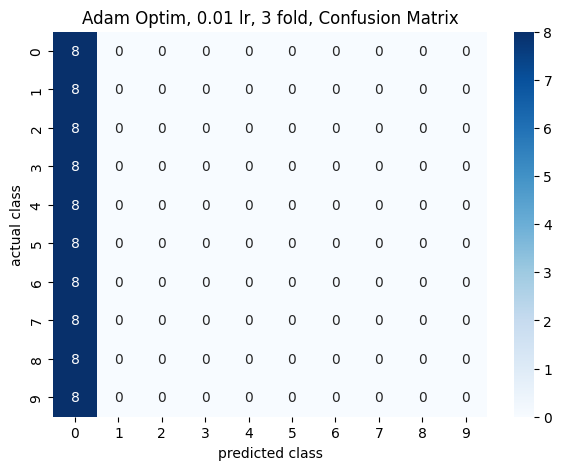

Adam, 0.01 lr, 3 fold, Overall F1 Score: 0.01818181818181818


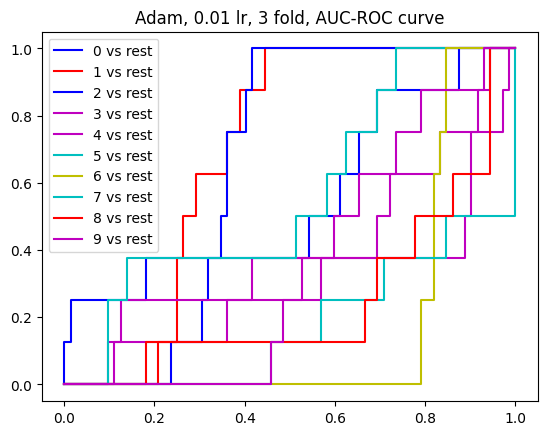

100%|██████████| 80/80 [00:00<00:00, 16410.44it/s]


4 fold, Epoch 1/100, Training Loss: 2.3152607083320618, Training Accuracy: 9.166666666666666
4 fold, Epoch 1/100, Validation Loss: 2.3041866620381675, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.2484834492206573, Training Accuracy: 21.25
4 fold, Epoch 2/100, Validation Loss: 2.3079065481821694, Validation Accuracy: 11.25
4 fold, Epoch 3/100, Training Loss: 2.212883472442627, Training Accuracy: 23.75
4 fold, Epoch 3/100, Validation Loss: 2.3042522271474204, Validation Accuracy: 12.5
4 fold, Epoch 4/100, Training Loss: 2.2008437514305115, Training Accuracy: 23.75
4 fold, Epoch 4/100, Validation Loss: 2.3046130339304605, Validation Accuracy: 11.25
4 fold, Epoch 5/100, Training Loss: 2.1882852613925934, Training Accuracy: 25.416666666666668
4 fold, Epoch 5/100, Validation Loss: 2.2441904544830322, Validation Accuracy: 20.0
4 fold, Epoch 6/100, Training Loss: 2.172243505716324, Training Accuracy: 22.916666666666668
4 fold, Epoch 6/100, Validation Loss: 2.266932805379232,

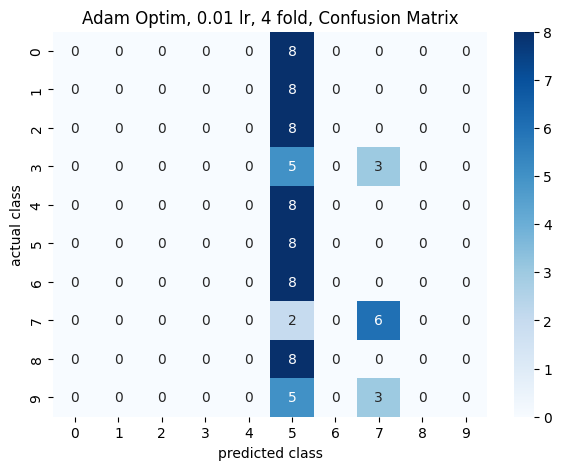

Adam, 0.01 lr, 4 fold, Overall F1 Score: 0.08105263157894736


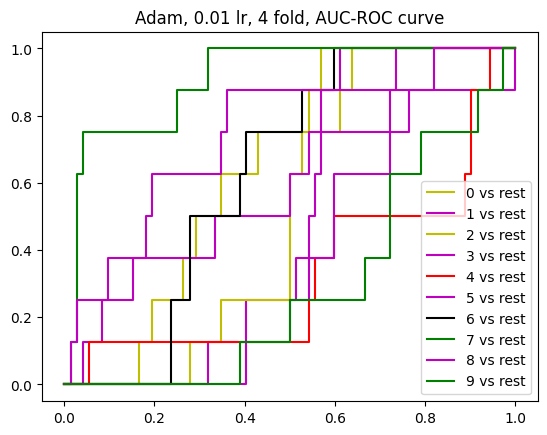

100%|██████████| 80/80 [00:00<00:00, 16076.29it/s]


5 fold, Epoch 1/100, Training Loss: 2.3202202022075653, Training Accuracy: 7.916666666666667
5 fold, Epoch 1/100, Validation Loss: 2.3056623140970864, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.2827487885951996, Training Accuracy: 10.833333333333334
5 fold, Epoch 2/100, Validation Loss: 2.290693680445353, Validation Accuracy: 15.0
5 fold, Epoch 3/100, Training Loss: 2.3146516382694244, Training Accuracy: 8.75
5 fold, Epoch 3/100, Validation Loss: 2.3084203402201333, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.3183987140655518, Training Accuracy: 8.75
5 fold, Epoch 4/100, Validation Loss: 2.3000590801239014, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.3106842637062073, Training Accuracy: 10.0
5 fold, Epoch 5/100, Validation Loss: 2.3052140871683755, Validation Accuracy: 10.0
5 fold, Epoch 6/100, Training Loss: 2.3113918006420135, Training Accuracy: 8.75
5 fold, Epoch 6/100, Validation Loss: 2.3104565938313804, Validation Accur

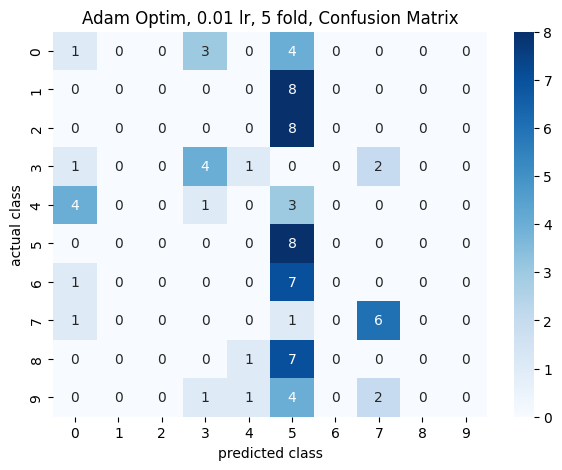

Adam, 0.01 lr, 5 fold, Overall F1 Score: 0.15381169709263015


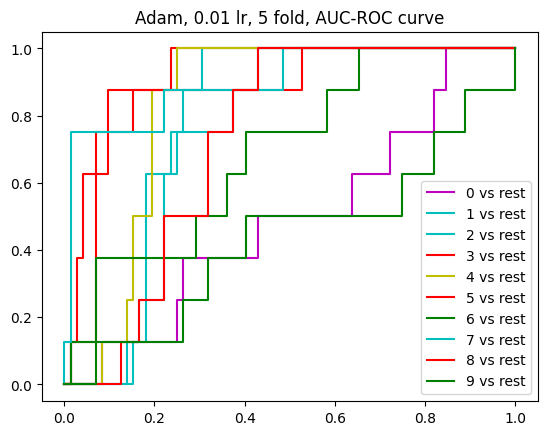

Mean validation accuracy: 24.0625
Best test accuracy: 33.75


100%|██████████| 80/80 [00:00<00:00, 15876.24it/s]


2 fold, Epoch 1/100, Training Loss: 2.304941773414612, Training Accuracy: 7.916666666666667
2 fold, Epoch 1/100, Validation Loss: 2.3023692766825357, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.3049584329128265, Training Accuracy: 8.75
2 fold, Epoch 2/100, Validation Loss: 2.3021864096323648, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.3060198724269867, Training Accuracy: 8.333333333333334
2 fold, Epoch 3/100, Validation Loss: 2.3020571867624917, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.304284989833832, Training Accuracy: 8.333333333333334
2 fold, Epoch 4/100, Validation Loss: 2.301970640818278, Validation Accuracy: 10.0
2 fold, Epoch 5/100, Training Loss: 2.305163025856018, Training Accuracy: 9.166666666666666
2 fold, Epoch 5/100, Validation Loss: 2.301979382832845, Validation Accuracy: 10.0
2 fold, Epoch 6/100, Training Loss: 2.3052802979946136, Training Accuracy: 9.166666666666666
2 fold, Epoch 6/100, Validation Loss: 2.

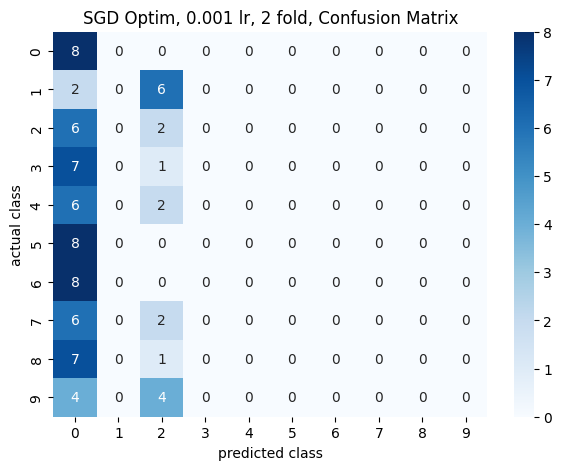

SGD, 0.001 lr, 2 fold, Overall F1 Score: 0.03824175824175824


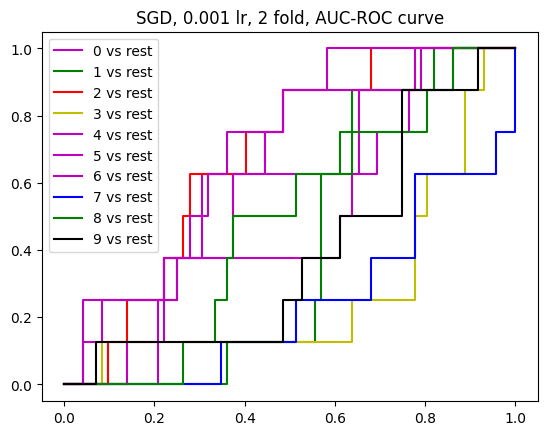

100%|██████████| 80/80 [00:00<00:00, 17337.21it/s]


3 fold, Epoch 1/100, Training Loss: 2.303500086069107, Training Accuracy: 10.0
3 fold, Epoch 1/100, Validation Loss: 2.3006800015767417, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.303092211484909, Training Accuracy: 10.0
3 fold, Epoch 2/100, Validation Loss: 2.300560633341471, Validation Accuracy: 10.0
3 fold, Epoch 3/100, Training Loss: 2.301898330450058, Training Accuracy: 10.0
3 fold, Epoch 3/100, Validation Loss: 2.300386905670166, Validation Accuracy: 10.0
3 fold, Epoch 4/100, Training Loss: 2.302085816860199, Training Accuracy: 10.0
3 fold, Epoch 4/100, Validation Loss: 2.2998239994049072, Validation Accuracy: 10.0
3 fold, Epoch 5/100, Training Loss: 2.302875280380249, Training Accuracy: 10.0
3 fold, Epoch 5/100, Validation Loss: 2.2991758982340493, Validation Accuracy: 10.0
3 fold, Epoch 6/100, Training Loss: 2.3027577996253967, Training Accuracy: 10.0
3 fold, Epoch 6/100, Validation Loss: 2.2986974716186523, Validation Accuracy: 10.0
3 fold, Epoch 7/100, Tr

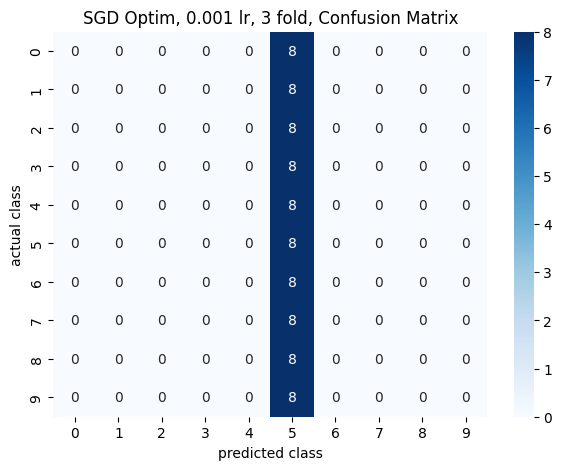

SGD, 0.001 lr, 3 fold, Overall F1 Score: 0.01818181818181818


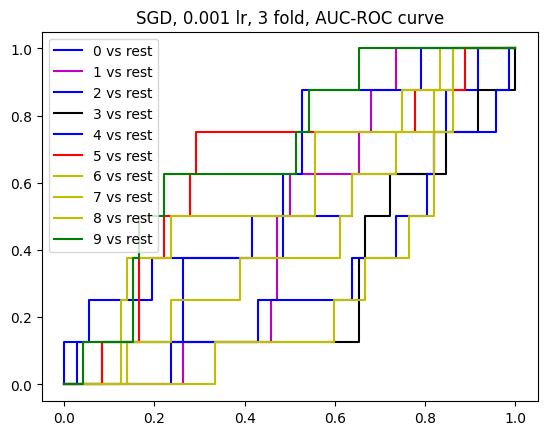

100%|██████████| 80/80 [00:00<00:00, 16216.14it/s]


4 fold, Epoch 1/100, Training Loss: 2.299722820520401, Training Accuracy: 6.666666666666667
4 fold, Epoch 1/100, Validation Loss: 2.301946004231771, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.2998523116111755, Training Accuracy: 7.083333333333333
4 fold, Epoch 2/100, Validation Loss: 2.3017678260803223, Validation Accuracy: 7.5
4 fold, Epoch 3/100, Training Loss: 2.2993993163108826, Training Accuracy: 7.083333333333333
4 fold, Epoch 3/100, Validation Loss: 2.301467498143514, Validation Accuracy: 8.75
4 fold, Epoch 4/100, Training Loss: 2.2998728454113007, Training Accuracy: 7.5
4 fold, Epoch 4/100, Validation Loss: 2.300844589869181, Validation Accuracy: 8.75
4 fold, Epoch 5/100, Training Loss: 2.299719750881195, Training Accuracy: 7.083333333333333
4 fold, Epoch 5/100, Validation Loss: 2.2998580932617188, Validation Accuracy: 10.0
4 fold, Epoch 6/100, Training Loss: 2.299293100833893, Training Accuracy: 7.083333333333333
4 fold, Epoch 6/100, Validation Loss: 2.298

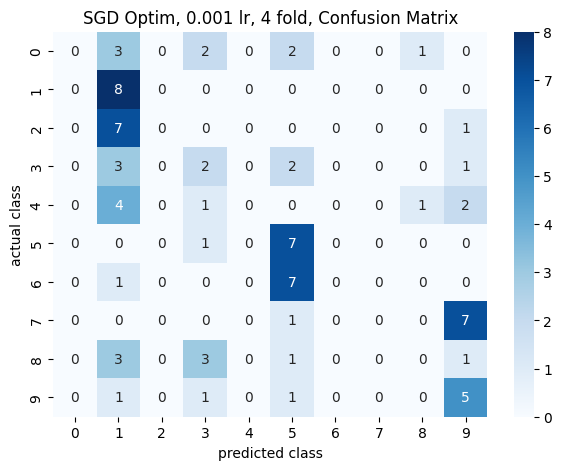

SGD, 0.001 lr, 4 fold, Overall F1 Score: 0.1526033474490825


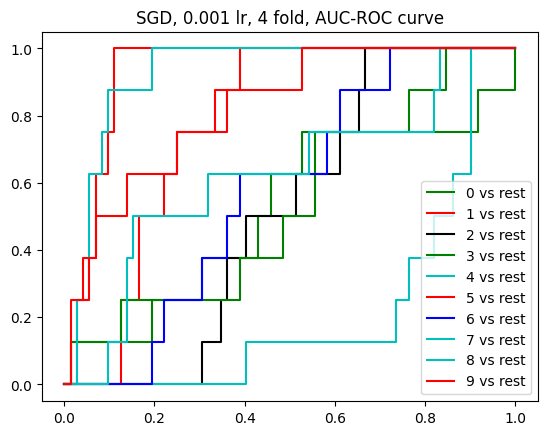

100%|██████████| 80/80 [00:00<00:00, 17482.64it/s]


5 fold, Epoch 1/100, Training Loss: 2.305212050676346, Training Accuracy: 7.083333333333333
5 fold, Epoch 1/100, Validation Loss: 2.3052701155344644, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.3047052025794983, Training Accuracy: 6.25
5 fold, Epoch 2/100, Validation Loss: 2.3053623040517173, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.3036124408245087, Training Accuracy: 8.333333333333334
5 fold, Epoch 3/100, Validation Loss: 2.305447816848755, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.305000424385071, Training Accuracy: 8.75
5 fold, Epoch 4/100, Validation Loss: 2.3055445353190103, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.3050501346588135, Training Accuracy: 7.5
5 fold, Epoch 5/100, Validation Loss: 2.3055667082468667, Validation Accuracy: 10.0
5 fold, Epoch 6/100, Training Loss: 2.3050438463687897, Training Accuracy: 7.083333333333333
5 fold, Epoch 6/100, Validation Loss: 2.305567502975464, Validati

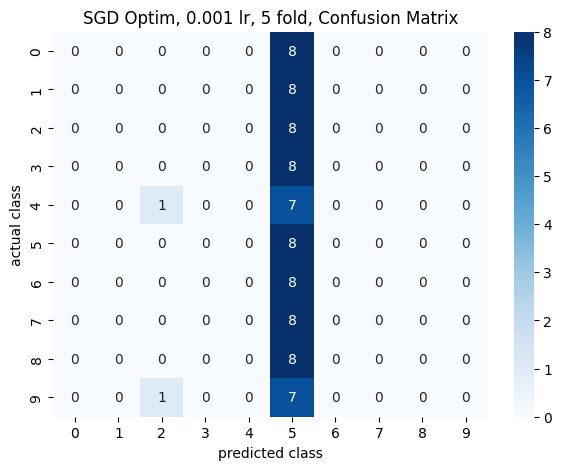

SGD, 0.001 lr, 5 fold, Overall F1 Score: 0.018604651162790694


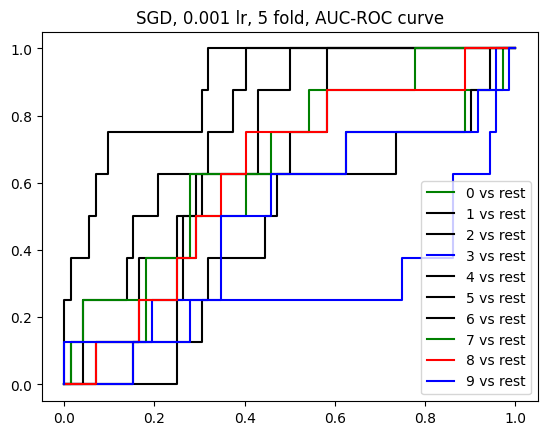

Mean validation accuracy: 13.4375
Best test accuracy: 27.5


100%|██████████| 80/80 [00:00<00:00, 17767.77it/s]


2 fold, Epoch 1/100, Training Loss: 2.3049159049987793, Training Accuracy: 9.583333333333334
2 fold, Epoch 1/100, Validation Loss: 2.305948575337728, Validation Accuracy: 10.0
2 fold, Epoch 2/100, Training Loss: 2.3069619238376617, Training Accuracy: 10.416666666666666
2 fold, Epoch 2/100, Validation Loss: 2.305816968282064, Validation Accuracy: 10.0
2 fold, Epoch 3/100, Training Loss: 2.3051273226737976, Training Accuracy: 10.0
2 fold, Epoch 3/100, Validation Loss: 2.3057591915130615, Validation Accuracy: 10.0
2 fold, Epoch 4/100, Training Loss: 2.3052506148815155, Training Accuracy: 10.833333333333334
2 fold, Epoch 4/100, Validation Loss: 2.305963118871053, Validation Accuracy: 10.0
2 fold, Epoch 5/100, Training Loss: 2.304141104221344, Training Accuracy: 7.916666666666667
2 fold, Epoch 5/100, Validation Loss: 2.306300163269043, Validation Accuracy: 10.0
2 fold, Epoch 6/100, Training Loss: 2.3048634827136993, Training Accuracy: 10.416666666666666
2 fold, Epoch 6/100, Validation Loss:

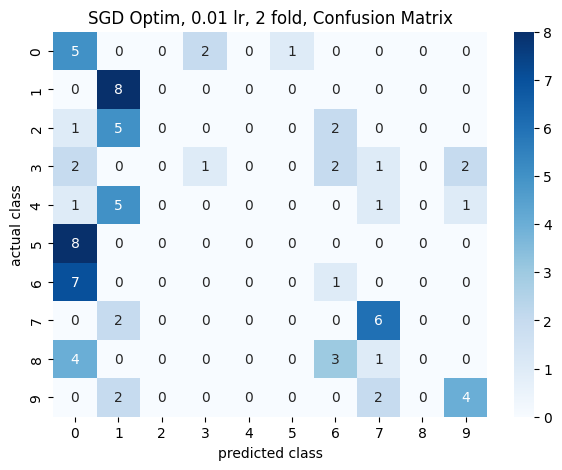

SGD, 0.01 lr, 2 fold, Overall F1 Score: 0.22828415736310476


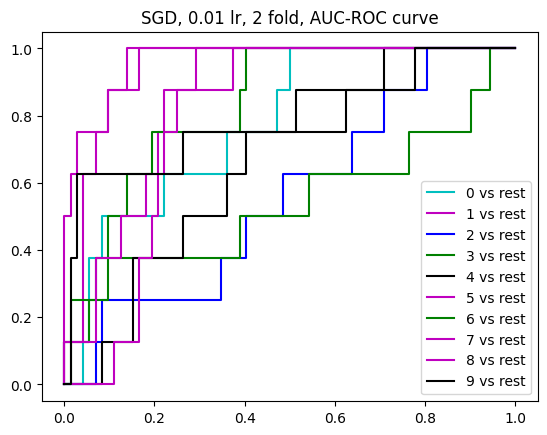

100%|██████████| 80/80 [00:00<00:00, 17478.09it/s]


3 fold, Epoch 1/100, Training Loss: 2.305253118276596, Training Accuracy: 9.583333333333334
3 fold, Epoch 1/100, Validation Loss: 2.3026859760284424, Validation Accuracy: 10.0
3 fold, Epoch 2/100, Training Loss: 2.303068459033966, Training Accuracy: 10.0
3 fold, Epoch 2/100, Validation Loss: 2.3029561042785645, Validation Accuracy: 10.0
3 fold, Epoch 3/100, Training Loss: 2.3043479323387146, Training Accuracy: 10.833333333333334
3 fold, Epoch 3/100, Validation Loss: 2.3027495543162027, Validation Accuracy: 10.0
3 fold, Epoch 4/100, Training Loss: 2.3028361201286316, Training Accuracy: 10.833333333333334
3 fold, Epoch 4/100, Validation Loss: 2.3024398485819497, Validation Accuracy: 10.0
3 fold, Epoch 5/100, Training Loss: 2.3032663464546204, Training Accuracy: 11.25
3 fold, Epoch 5/100, Validation Loss: 2.30171807607015, Validation Accuracy: 10.0
3 fold, Epoch 6/100, Training Loss: 2.303158074617386, Training Accuracy: 11.25
3 fold, Epoch 6/100, Validation Loss: 2.3005239168802896, Vali

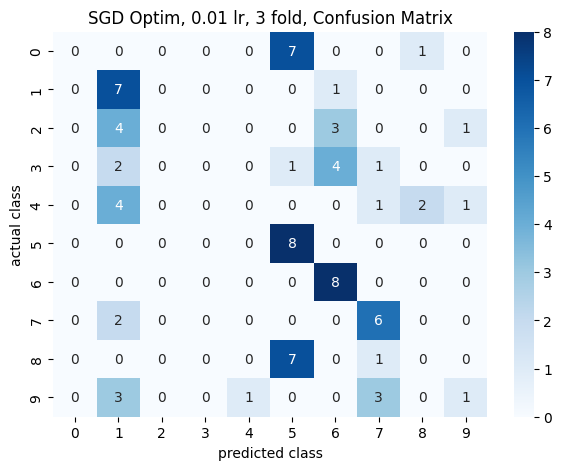

SGD, 0.01 lr, 3 fold, Overall F1 Score: 0.24312805474095794


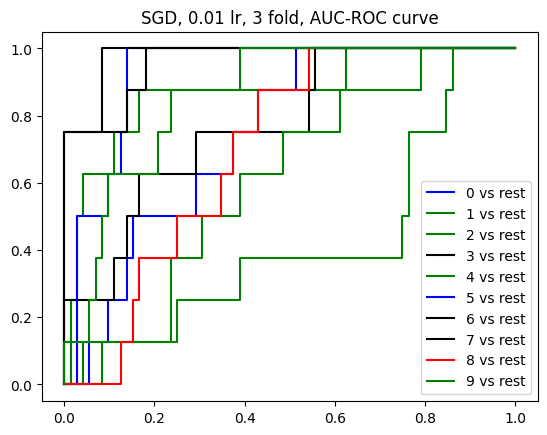

100%|██████████| 80/80 [00:00<00:00, 15976.78it/s]


4 fold, Epoch 1/100, Training Loss: 2.306058317422867, Training Accuracy: 10.0
4 fold, Epoch 1/100, Validation Loss: 2.3033101558685303, Validation Accuracy: 10.0
4 fold, Epoch 2/100, Training Loss: 2.3077836632728577, Training Accuracy: 9.166666666666666
4 fold, Epoch 2/100, Validation Loss: 2.30285636583964, Validation Accuracy: 10.0
4 fold, Epoch 3/100, Training Loss: 2.3055355846881866, Training Accuracy: 7.916666666666667
4 fold, Epoch 3/100, Validation Loss: 2.302373727162679, Validation Accuracy: 10.0
4 fold, Epoch 4/100, Training Loss: 2.3044422268867493, Training Accuracy: 9.166666666666666
4 fold, Epoch 4/100, Validation Loss: 2.3019063472747803, Validation Accuracy: 11.25
4 fold, Epoch 5/100, Training Loss: 2.3041635155677795, Training Accuracy: 10.0
4 fold, Epoch 5/100, Validation Loss: 2.301187515258789, Validation Accuracy: 11.25
4 fold, Epoch 6/100, Training Loss: 2.3037108182907104, Training Accuracy: 9.583333333333334
4 fold, Epoch 6/100, Validation Loss: 2.30076766014

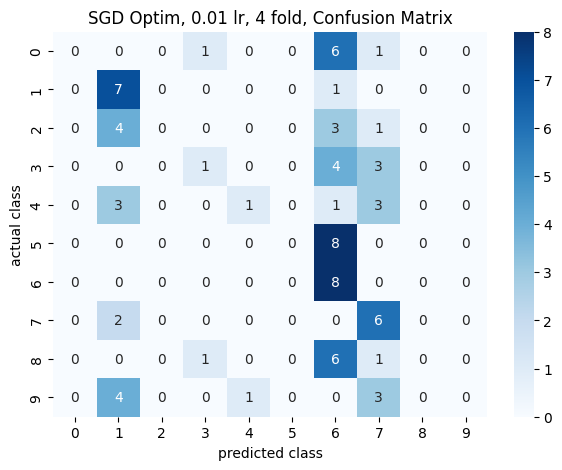

SGD, 0.01 lr, 4 fold, Overall F1 Score: 0.16989121989121986


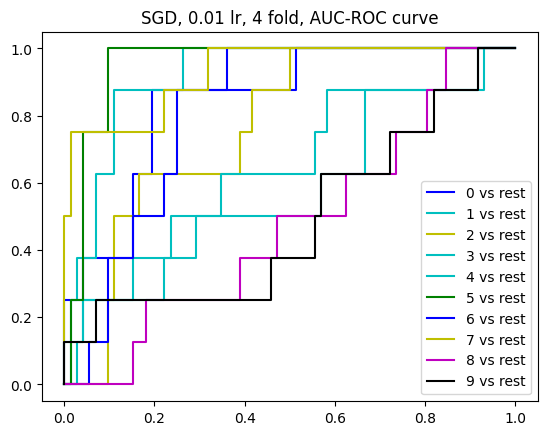

100%|██████████| 80/80 [00:00<00:00, 17262.29it/s]


5 fold, Epoch 1/100, Training Loss: 2.307435154914856, Training Accuracy: 5.833333333333333
5 fold, Epoch 1/100, Validation Loss: 2.3062907059987388, Validation Accuracy: 10.0
5 fold, Epoch 2/100, Training Loss: 2.305723935365677, Training Accuracy: 6.25
5 fold, Epoch 2/100, Validation Loss: 2.3061880270640054, Validation Accuracy: 10.0
5 fold, Epoch 3/100, Training Loss: 2.3055115938186646, Training Accuracy: 6.25
5 fold, Epoch 3/100, Validation Loss: 2.306222597757975, Validation Accuracy: 10.0
5 fold, Epoch 4/100, Training Loss: 2.3050184547901154, Training Accuracy: 6.666666666666667
5 fold, Epoch 4/100, Validation Loss: 2.3062970638275146, Validation Accuracy: 10.0
5 fold, Epoch 5/100, Training Loss: 2.305388957262039, Training Accuracy: 7.916666666666667
5 fold, Epoch 5/100, Validation Loss: 2.306313991546631, Validation Accuracy: 8.75
5 fold, Epoch 6/100, Training Loss: 2.304499387741089, Training Accuracy: 8.333333333333334
5 fold, Epoch 6/100, Validation Loss: 2.30613557497660

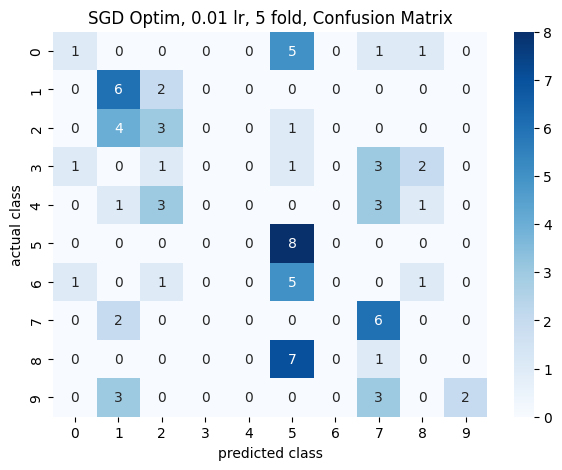

SGD, 0.01 lr, 5 fold, Overall F1 Score: 0.23522943722943723


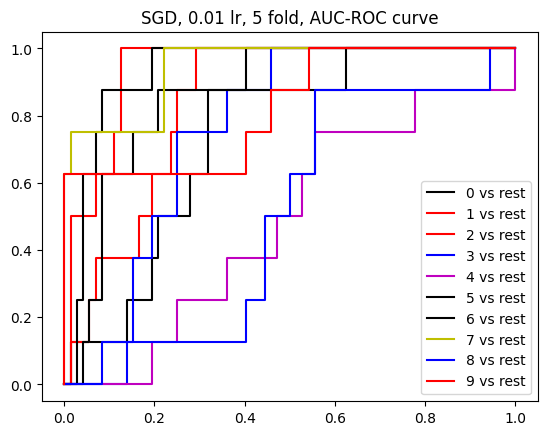

Mean validation accuracy: 34.0625
Best test accuracy: 37.5


In [12]:
for optimizer_type in optimizers:
    for lr_type in learning_rates:

        all_test_accuracy = []
        all_validation_accuracy = []
        valid_samples = [2,3,4,5]
        
        for i in valid_samples:
            # Data Setup
            test_samp = 1 #Do not change this!!
            valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = 32 # Free to change
            num_workers = 2 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                num_workers=num_workers,
                                                data_directory=path,
                                                data_frame=df,
                                                validation_fold=valid_samp,
                                                testing_fold=test_samp,  # set to 0 for no test set
                                                esc_10_flag=True,
                                                file_column='filename',
                                                label_column='category',
                                                sampling_rate=44100,
                                                new_sampling_rate=16000,  # new sample rate for input
                                                sample_length_seconds=1  # new length of input in seconds
                                                )

            custom_data_module.setup()
            
            # Hyperparameters
            num_classes = 10
            lr = lr_type
            epochs = 100
            # Model, Optimizer, Loss function
            model2 = Architecture2().to(device)
            # model2 = Architecture2()
            # optimizer = optim.Adam(model1.parameters(), lr=lr)  
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model2.parameters(), lr=lr)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model2.parameters(), lr=lr)

            criterion = nn.CrossEntropyLoss()

            # WandB initialization
            wandb.init(project="Architecture2_Model2_Head4", name=f"{optimizer_type}, {lr} lr, {i} fold")

            # Training loop
            train_acc_track = []
            val_acc_track = []
            train_loss_track = []
            val_loss_track = []

            for epoch in range(epochs):
                model2.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for data, target in custom_data_module.train_dataloader():
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model2(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = output.max(1)

                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()

                train_loss = running_loss / len(custom_data_module.train_dataloader())
                train_acc = 100. * correct / total

                train_loss_track.append(train_loss)
                train_acc_track.append(train_acc)

                print(f'{i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

                # Validation
                model2.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for data, target in custom_data_module.val_dataloader():
                        data, target = data.to(device), target.to(device)
                        output = model2(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()
                        _, predicted = output.max(1)

                        val_total += target.size(0)
                        val_correct += predicted.eq(target).sum().item()

                val_loss /= len(custom_data_module.val_dataloader())
                val_acc = 100. * val_correct / val_total

                val_loss_track.append(val_loss)
                val_acc_track.append(val_acc)

                print(f'{i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

                # # Logging
                wandb.log({"Train Loss": train_loss, "Train Acc": train_acc, "Val Loss": val_loss, "Val Acc": val_acc, "Learning rate": lr, "Optimizer": optimizer_type})


            all_validation_accuracy.append(val_acc)

            # Testing
            model2.eval()
            test_correct = 0
            test_total = 0
            all_labels_test = []
            all_preds_test = []
            all_probabilities = []

            with torch.no_grad():
                for data, target in custom_data_module.test_dataloader():
                    data, target = data.to(device), target.to(device)          
                    output = model2(data)
                    all_probabilities.extend(output.cpu().numpy())
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
                    all_labels_test.extend(target.cpu().numpy())
                    all_preds_test.extend(predicted.cpu().numpy())

            test_acc = 100. * test_correct / test_total
            print(f'{optimizer_type}, {lr} lr, {i} fold, Test Accuracy: {test_acc:.2f}%')
            # print(f'Test Accuracy: {test_acc:.2f}%')
            all_test_accuracy.append(test_acc)

            # Confusion Matrix for test set
            cm = confusion_matrix(all_labels_test, all_preds_test)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, Confusion Matrix')
            # plt.title(f'Confusion Matrix')
            plt.xlabel("predicted class",size=10)
            plt.ylabel("actual class",size=10)
            plt.show()

            # Calculate overall F1 score
            overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

            # print(f'Overall F1 Score: {overall_f1_score}')
            print(f'{optimizer_type}, {lr} lr, {i} fold, Overall F1 Score: {overall_f1_score}')

            # roc curve for classes
            fpr = {}
            tpr = {}
            thresh ={}
            n_class = 10

            for j in range(n_class):
                fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
                plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
            plt.legend()    
            # plt.title("AUC-ROC curve")
            plt.title(f'{optimizer_type}, {lr} lr, {i} fold, AUC-ROC curve')
            plt.show()  

            wandb.summary["Test accuracy"] = test_acc
            wandb.finish()

        print(f'Mean validation accuracy: {mean(all_validation_accuracy)}')
        print(f'Best test accuracy: {max(all_test_accuracy)}')

In [25]:
# valid_samples = [2,3,4,5]
# all_test_accuracy = []
# all_validation_accuracy = []

# for i in valid_samples:
#     # Data Setup
#     test_samp = 1 #Do not change this!!
#     valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
#     batch_size = 32 # Free to change
#     num_workers = 2 # Free to change
#     custom_data_module = CustomDataModule(batch_size=batch_size,
#                                         num_workers=num_workers,
#                                         data_directory=path,
#                                         data_frame=df,
#                                         validation_fold=valid_samp,
#                                         testing_fold=test_samp,  # set to 0 for no test set
#                                         esc_10_flag=True,
#                                         file_column='filename',
#                                         label_column='category',
#                                         sampling_rate=44100,
#                                         new_sampling_rate=16000,  # new sample rate for input
#                                         sample_length_seconds=1  # new length of input in seconds
#                                         )

#     custom_data_module.setup()

#     # WandB initialization
#     wandb.init(project="Architecture2-Model2", name=f"{i} fold")
    
#     # Hyperparameters
#     # input_size = x[0][0].shape[1]
#     num_classes = 10
#     lr = 0.001
#     epochs = 1
#     # Model, Optimizer, Loss function
#     model2 = Architecture2().to(device)
#     # model2 = Architecture2()
#     optimizer = optim.Adam(model2.parameters(), lr=lr)
#     criterion = nn.CrossEntropyLoss()

#     # Training loop
#     train_acc_track = []
#     val_acc_track = []
#     train_loss_track = []
#     val_loss_track = []

#     for epoch in range(epochs):
#         model2.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for data, target in custom_data_module.train_dataloader():
#             data, target = data.to(device), target.to(device)
#             optimizer.zero_grad()
#             output = model2(data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, predicted = output.max(1)

#             total += target.size(0)
#             correct += predicted.eq(target).sum().item()

#         train_loss = running_loss / len(custom_data_module.train_dataloader())
#         train_acc = 100. * correct / total

#         train_loss_track.append(train_loss)
#         train_acc_track.append(train_acc)

#         print(f'{i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
#         # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

#         # Validation
#         model2.eval()
#         val_loss = 0.0
#         val_correct = 0
#         val_total = 0

#         with torch.no_grad():
#             for data, target in custom_data_module.val_dataloader():
#                 data, target = data.to(device), target.to(device)
#                 output = model2(data)
#                 loss = criterion(output, target)
#                 val_loss += loss.item()
#                 _, predicted = output.max(1)

#                 val_total += target.size(0)
#                 val_correct += predicted.eq(target).sum().item()

#         val_loss /= len(custom_data_module.val_dataloader())
#         val_acc = 100. * val_correct / val_total

#         val_loss_track.append(val_loss)
#         val_acc_track.append(val_acc)

#         print(f'{i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
#         # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

#         # # Logging
#         wandb.log({"Train Loss": train_loss, "Train Acc": train_acc, "Val Loss": val_loss, "Val Acc": val_acc})
    
#     all_validation_accuracy.append(val_acc)

#     # Testing
#     model2.eval()
#     test_correct = 0
#     test_total = 0
#     all_labels_test = []
#     all_preds_test = []
#     all_probabilities = []

#     with torch.no_grad():
#         for data, target in custom_data_module.test_dataloader():
#             data, target = data.to(device), target.to(device)          
#             output = model2(data)
#             all_probabilities.extend(output.cpu().numpy())
#             _, predicted = output.max(1)
#             test_total += target.size(0)
#             test_correct += predicted.eq(target).sum().item()
#             all_labels_test.extend(target.cpu().numpy())
#             all_preds_test.extend(predicted.cpu().numpy())

#     test_acc = 100. * test_correct / test_total
#     print(f'{i} fold, Test Accuracy: {test_acc:.2f}%')
#     # print(f'Test Accuracy: {test_acc:.2f}%')

#     all_test_accuracy.append(test_acc)

#     # Confusion Matrix for test set
#     cm = confusion_matrix(all_labels_test, all_preds_test)
#     plt.figure(figsize=(7, 5))
#     sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
#     plt.title(f'{i} fold, Confusion Matrix')
#     # plt.title(f'Confusion Matrix')
#     plt.xlabel("predicted class",size=10)
#     plt.ylabel("actual class",size=10)
#     plt.show()

#     # Calculate overall F1 score
#     overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

#     # print(f'Overall F1 Score: {overall_f1_score}')
#     print(f'{i} fold, Overall F1 Score: {overall_f1_score}')

#     # roc curve for classes
#     fpr = {}
#     tpr = {}
#     thresh ={}
#     n_class = 10

#     for j in range(n_class):
#         fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
#         plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
#     plt.legend()    
#     # plt.title("AUC-ROC curve")
#     plt.title(f'{i} fold, AUC-ROC curve')
#     plt.show()  

#     # wandb.summary["Validation loss"] = val_loss
#     wandb.summary["Test accuracy"] = test_acc
#     wandb.finish()

# print(f'Mean validation accuracy: {mean(all_validation_accuracy)}')
# print(f'Best test accuracy: {max(all_test_accuracy)}')

In [26]:
def numel(model2: torch.nn.Module, only_trainable: bool = False):

    parameters = list(model2.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)
               
numel(model2,only_trainable=True),numel(model2,only_trainable=False)-numel(model2,only_trainable=True)

(61290, 0)